# Sequence Aware Recommender Systems
> A tutorial on Sequence-Aware Recommender Systems

- toc: true
- badges: true
- comments: true
- categories: [sequence, music]
- image: 

In [ ]:
#hide
!pip install pymining
!pip install treelib==1.5.3
!pip install networkx==1.11
!pip install theano==1.0.3

  Created wheel for treelib: filename=treelib-1.5.3-cp37-none-any.whl size=13474 sha256=0dfa924c56ed16692713222b317dc9ca51481125539a56da4823fa54a0a01b0f
  Stored in directory: /root/.cache/pip/wheels/c4/29/a2/1bd8145c2898f2b9f2a23a97659580e38043e1065560f8df60
Successfully built treelib
     |████████████████████████████████| 1.3MB 8.7MB/s 
ERROR: scikit-image 0.16.2 has requirement networkx>=2.0, but you'll have networkx 1.11 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5.1
    Uninstalling networkx-2.5.1:
      Successfully uninstalled networkx-2.5.1
     |████████████████████████████████| 2.8MB 8.9MB/s 
  Created wheel for theano: filename=Theano-1.0.3-cp37-none-any.whl size=2658318 sha256=d75872ba034c040dea8615b3a12d63a21b2576fa5ae4003d61410ec913695b03
  Stored in directory: /root/.cache/pip/wheels/10/82/05/9ef5e43bfcf906b4810f85f91b09d6daf7ad213

In [ ]:
#hide
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import calendar
import datetime
import os
import time
from collections import Counter
import random
from scipy.sparse import find
import logging
import operator
from tqdm import tqdm
import gc
from functools import reduce
import networkx as nx
import uuid
import treelib
import theano
from theano import tensor as T
from collections import OrderedDict
from theano import function
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pickle

import warnings
warnings.filterwarnings("ignore")

import subprocess

import csv
import math
from numba import jit
import pickle
import random

import gensim

2021-04-25 14:00:03,787 - INFO - 'pattern' package not found; tag filters are not available for English


In [ ]:
#hide
# WnB Remote Logging Setup
!pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 2.1MB 9.5MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 133kB 52.8MB/s 
     |████████████████████████████████| 163kB 42.7MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#hide
# Helper functions
def get_test_sequences(test_data, given_k):
  # we can run evaluation only over sequences longer than abs(LAST_K)
  test_sequences = test_data.loc[test_data['sequence'].map(len) > abs(given_k), 'sequence'].values
  return test_sequences

  def get_test_sequences_and_users(test_data, given_k, train_users):
    # we can run evaluation only over sequences longer than abs(LAST_K)
    mask = test_data['sequence'].map(len) > abs(given_k)
    mask &= test_data['user_id'].isin(train_users)
    test_sequences = test_data.loc[mask, 'sequence'].values
    test_users = test_data.loc[mask, 'user_id'].values
    return test_sequences, test_users

### Data loading

In [ ]:
#hide-output
!mkdir datasets && \
cd datasets && \
wget https://raw.githubusercontent.com/mquad/sars_tutorial/master/datasets/sessions.zip && \
unzip sessions.zip

--2021-04-25 13:55:24--  https://raw.githubusercontent.com/mquad/sars_tutorial/master/datasets/sessions.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36954879 (35M) [application/zip]
Saving to: ‘sessions.zip’

sessions.zip        100%[===================>]  35.24M   105MB/s    in 0.3s    

2021-04-25 13:55:25 (105 MB/s) - ‘sessions.zip’ saved [36954879/36954879]

Archive:  sessions.zip
  inflating: sessions.csv            
  inflating: sessions_sample_10.csv  


In [ ]:
#hide
dataset_path = 'datasets/sessions.csv'
# load this sample if you experience a severe slowdown with the previous dataset
dataset_path = 'datasets/sessions_sample_10.csv' 

In [ ]:
#hide
def load_and_adapt(path, last_months=0):
    file_ext = os.path.splitext(path)[-1]
    if file_ext == '.csv':
        data = pd.read_csv(path, header=0)
    elif file_ext == '.hdf':
        data = pd.read_hdf(path)
    else:
        raise ValueError('Unsupported file {} having extension {}'.format(path, file_ext))

    col_names = ['session_id', 'user_id', 'item_id', 'ts'] + data.columns.values.tolist()[4:]
    data.columns = col_names

    if last_months > 0:
        def add_months(sourcedate, months):
            month = sourcedate.month - 1 + months
            year = int(sourcedate.year + month / 12)
            month = month % 12 + 1
            day = min(sourcedate.day, calendar.monthrange(year, month)[1])
            return datetime.date(year, month, day)

        lastdate = datetime.datetime.fromtimestamp(data.ts.max())
        firstdate = add_months(lastdate, -last_months)
        initial_unix = time.mktime(firstdate.timetuple())

        # filter out older interactions
        data = data[data['ts'] >= initial_unix]

    return data

In [ ]:
#hide
def create_seq_db_filter_top_k(path, topk=0, last_months=0):
    file = load_and_adapt(path, last_months=last_months)

    c = Counter(list(file['item_id']))

    if topk > 1:
        keeper = set([x[0] for x in c.most_common(topk)])
        file = file[file['item_id'].isin(keeper)]

    # group by session id and concat song_id
    groups = file.groupby('session_id')

    # convert item ids to string, then aggregate them to lists
    aggregated = groups['item_id'].agg(sequence = lambda x: list(map(str, x)))
    init_ts = groups['ts'].min()
    users = groups['user_id'].min()  # it's just fast, min doesn't actually make sense

    result = aggregated.join(init_ts).join(users)
    result.reset_index(inplace=True)
    return result

In [ ]:
# for the sake of speed, let's keep only the top-1k most popular items in the last month
dataset = create_seq_db_filter_top_k(path=dataset_path, topk=1000, last_months=1)

In [ ]:
dataset.head()

,session_id,sequence,ts,user_id
0,357,"[793, 3489]",1421003874,4296
1,359,[1762],1421018535,4296
2,394,[1256],1421007470,30980
3,4127,"[1948, 1364, 2060, 1115, 6488, 2060]",1421416896,28117
4,6400,"[687, 1394]",1420807778,35247


### Data statistics

In [ ]:
#hide-input
cnt = Counter()
dataset.sequence.map(cnt.update);

sequence_length = dataset.sequence.map(len).values
n_sessions_per_user = dataset.groupby('user_id').size()

print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(dataset.user_id.nunique()))
print('Number of sessions: {}'.format(len(dataset)) )

print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))

print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

print('Most popular items: {}'.format(cnt.most_common(5)))

Number of items: 1000
Number of users: 4165
Number of sessions: 6765

Session length:
	Average: 4.29
	Median: 3.0
	Min: 1
	Max: 148
Sessions per user:
	Average: 1.62
	Median: 1.0
	Min: 1
	Max: 13
Most popular items: [('443', 207), ('1065', 155), ('67', 146), ('2308', 138), ('658', 131)]


### Split the dataset

In [ ]:
#collapse
def random_holdout(dataset, perc=0.8, seed=1234):
    """
    Split sequence dataset randomly
    :param dataset: the sequence dataset
    :param perc: the training percentange
    :param seed: the random seed
    :return: the training and test splits
    """
    dataset = dataset.sample(frac=1, random_state=seed)
    nseqs = len(dataset)
    train_size = int(nseqs * perc)
    # split data according to the shuffled index and the holdout size
    train_split = dataset[:train_size]
    test_split = dataset[train_size:]

    return train_split, test_split


def temporal_holdout(dataset, ts_threshold):
    """
    Split sequence dataset using timestamps
    :param dataset: the sequence dataset
    :param ts_threshold: the timestamp from which test sequences will start
    :return: the training and test splits
    """
    train = dataset.loc[dataset['ts'] < ts_threshold]
    test = dataset.loc[dataset['ts'] >= ts_threshold]
    train, test = clean_split(train, test)

    return train, test


def last_session_out_split(data,
                           user_key='user_id',
                           session_key='session_id',
                           time_key='ts'):
    """
    Assign the last session of every user to the test set and the remaining ones to the training set
    """
    sessions = data.sort_values(by=[user_key, time_key]).groupby(user_key)[session_key]
    last_session = sessions.last()
    train = data[~data.session_id.isin(last_session.values)].copy()
    test = data[data.session_id.isin(last_session.values)].copy()
    train, test = clean_split(train, test)
    return train, test


def clean_split(train, test):
    """
    Remove new items from the test set.
    :param train: The training set.
    :param test: The test set.
    :return: The cleaned training and test sets.
    """
    train_items = set()
    train['sequence'].apply(lambda seq: train_items.update(set(seq)))
    test['sequence'] = test['sequence'].apply(lambda seq: [it for it in seq if it in train_items])
    return train, test


def balance_dataset(x, y):
    number_of_elements = y.shape[0]
    nnz = set(find(y)[0])
    zero = set(range(number_of_elements)).difference(nnz)

    max_samples = min(len(zero), len(nnz))

    nnz_indices = random.sample(nnz, max_samples)
    zero_indeces = random.sample(zero, max_samples)
    indeces = nnz_indices + zero_indeces

    return x[indeces, :], y[indeces, :]

For simplicity, let's split the dataset by assigning the last session of every user to the test set, and all the previous ones to the training set.

In [ ]:
train_data, test_data = last_session_out_split(dataset)
print("Train sessions: {} - Test sessions: {}".format(len(train_data), len(test_data)))

Train sessions: 2600 - Test sessions: 4165


## Fitting the recommender

### Algorithm summary

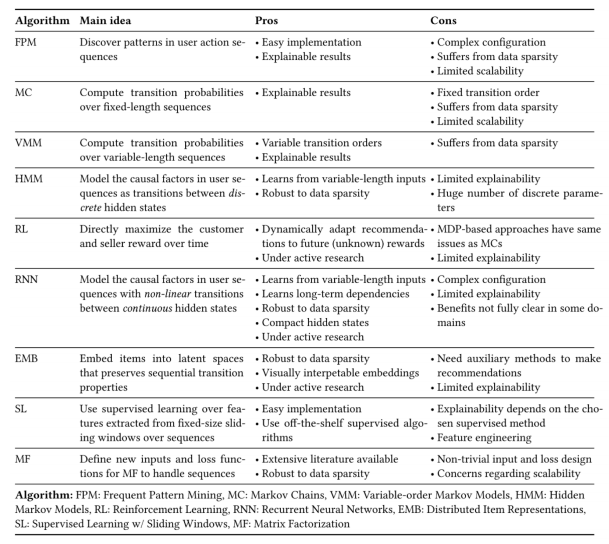

In [ ]:
#collapse
class ISeqRecommender(object):
    """Abstract Recommender class"""

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    def __init__(self):
        super(ISeqRecommender, self).__init__()

    def fit(self, train_data):
        pass

    def recommend(self, user_profile, user_id=None):
        """
        Given the user profile return a list of recommendation
        :param user_profile: the user profile as a list of item identifiers
        :param user_id: (optional) the user id
        :return: list of recommendations e.g. [([2], 0.875), ([6], 1.0)]
        """
        pass

    @staticmethod
    def get_recommendation_list(recommendation):
        return list(map(lambda x: x[0], recommendation))

    @staticmethod
    def get_recommendation_confidence_list(recommendation):
        return list(map(lambda x: x[1], recommendation))

    def activate_debug_print(self):
        self.logger.setLevel(logging.DEBUG)

    def deactivate_debug_print(self):
        self.logger.setLevel(logging.INFO)

### Popularity recommender

```PopularityRecommender``` simply recommends items ordered by their popularity in the training set.

It doesn't have any hyper-parameter, so we can move on!

In [ ]:
#collapse
class PopularityRecommender(ISeqRecommender):

    def __init__(self):
        super(PopularityRecommender, self).__init__()

    def fit(self, train_data):
        sequences = train_data['sequence'].values

        count_dict = {}
        for s in sequences:
            for item in s:
                if item not in count_dict:
                    count_dict[item] = 1
                else:
                    count_dict[item] += 1

        self.top = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)
        self.top = [([x[0]], x[1]) for x in self.top]

    def recommend(self, user_profile, user_id=None):
        return self.top

    def get_popular_list(self):
        return self.top

In [ ]:
poprecommender = PopularityRecommender()
poprecommender.fit(train_data)

### Frequent Sequential Patterns

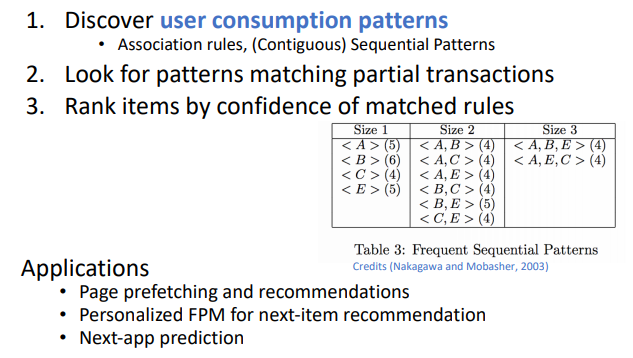

This algorithm extract Frequent Sequential Patterns from all the training sequences. Patterns are having support lower than `minsup` are discarded (support = # occurrences of a pattern in the traning data).  
Recommendations are then generated by looking for patterns having a _prefix_ corresponding to the last `[max_context, min_context]` elements in the user profile, taken in order. Matches are then sorted by decreasing _confidence_ score (ratio between the support of the matched rule and the support of the context). Matches having confidence below `minconf` are discarded.

The class `FSMRecommender` has the following initialization hyper-parameters:
* `minsup`: the minimum support threshold. It is interpreted as relative count if in \[0-1\], otherwise as an absolute count. NOTE: Relative count required for training with SPFM (faster).
* `minconf`: the minimum confidence threshold. Use to filter irrelevent recommendations.
* `max_context`: the maximum number of items in the user profile (starting from the last) that will be used for lookup in the database of frequent sequences.
* `min_context`: the minimum number of items in the user profile (starting from the last) that will be used for lookup in the database of frequent sequences.
* `spmf_path`: path to SPMF jar file. If provided, SPFM library will be used for pattern extraction (algorithm: Prefix Span). Otherwise, use pymining, which can be significantly slower depending on the sequence database size.
* `db_path`: path to the sequence database file

In [ ]:
#hide
def callSPMF(spmfPath, command):
    # java -jar spmf.jar run PrefixSpan contextPrefixSpan.txt output.txt 50%
    comm = ' '.join(['java -jar', spmfPath, 'run', command])
    print(comm)
    p = subprocess.Popen(comm,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT,
                         shell=True)
    p.communicate()  # wait for completion

In [ ]:
#hide
class SmartTree(treelib.Tree):
    _PATH_NOT_FOUND = -1

    def find_path(self, origin, path):
        """
        Takes the nodeId where to start the path search and the path to look for,
        :returns -1 if path not found, nodeId of the last node if path found
        """

        if not path:
            # path found
            return origin

        res = self._PATH_NOT_FOUND
        # note: fpointer getting deprecation warning, would improve in next ver.
        for nodeId in self[origin].fpointer:
            node = self[nodeId]
            if node.tag == path[0]:
                res = self.find_path(nodeId, path[1:])
                break

        if res is None:
            # path not found
            return self._PATH_NOT_FOUND
        else:
            return res

    def longest_subpath(self, origin, path):
        """
        Takes the nodeId where to start the path search and the path to look for,
        :returns the nodeId of the node where the path is broken and the number of missing element for the complete path
        """

        if not path:  # path empty, all nodes matched
            # path found
            return origin, 0

        res = ()

        for nodeId in self[origin].fpointer:
            node = self[nodeId]
            if node.tag == path[0]:
                res = self.longest_subpath(nodeId, path[1:])
                break

        if res == ():
            # path not found
            return origin, len(path)
        else:
            return res

    def add_path(self, origin, path, support=None):
        """add a path, starting from origin"""
        sub = self.longest_subpath(origin, path)
        if sub[1] == 0:
            # path already exists, updating support
            self[sub[0]].data = {'support': support}

        else:
            # add what's missing
            missingPath = path[-sub[1]:]

            par = sub[0]
            for item in missingPath:
                itemId = uuid.uuid4()
                self.create_node(item, itemId, parent=par, data={'support': support})
                par = itemId

    def path_is_valid(self, path):
        return path != self._PATH_NOT_FOUND

    def create_node(self, tag=None, identifier=None, parent=None, data=None):
        """override to get a random id if none provided"""
        id = uuid.uuid4() if identifier is None else identifier
        if id == self._PATH_NOT_FOUND:
            raise NameError("Cannot create a node with special id " + str(self._PATH_NOT_FOUND))
        super(SmartTree, self).create_node(tag, id, parent, data)

    def set_root(self, root_tag=None, root_id=None):
        id = uuid.uuid4()
        root_id = root_id if root_id is not None else id
        root_tag = root_tag if root_tag is not None else 'root'
        self.create_node(root_tag, root_id)
        self.root = root_id
        return root_id

    def get_root(self):
        try:
            return self.root
        except AttributeError:
            return None

    def find_n_length_paths(self, origin, length, exclude_origin=True):

        if length == 0:
            return [[]] if exclude_origin else [[origin]]

        else:
            children = self[origin].fpointer
            paths = []
            for c in children:
                children_paths = self.find_n_length_paths(c, length - 1, False)
                # this line is magic, if there are no children the all path gets lost,
                # that's how i get paths of exactly length wanted
                l = list(map(lambda x: [] + x, children_paths)) if exclude_origin else list(
                    map(lambda x: [origin] + x, children_paths))
                for el in l:
                    paths.append(el)
            return paths

    def get_paths_tag(self, list_of_paths):
        return list(map(lambda x: self.get_nodes_tag(x), list_of_paths))

    def get_nodes_tag(self, list_of_nids):
        return list(map(lambda y: self[y].tag, list_of_nids))

In [ ]:
#collapse
class FSMRecommender(ISeqRecommender):
    """Frequent Sequence Mining recommender"""

    def __init__(self, minsup, minconf, max_context=1, min_context=1, spmf_path=None, db_path=None):
        """

        :param minsup: the minimum support threshold. It is interpreted as relative count if in [0-1],
                otherwise as an absolute count. NOTE: Relative count required for training with SPFM (faster).
        :param minconf: the minimum confidence threshold.
        :param max_context: (optional) the maximum number of items in the user profile (starting from the last) that will be used
                for lookup in the database of frequent sequences.
        :param min_context: (optional) the minimum number of items in the user profile (starting from the last) that will be used
                for lookup in the database of frequent sequences.
        :param spmf_path: (optional) path to SPMF jar file. If provided, SPFM library will be used for pattern extraction (algorithm: Prefix Span).
                Otherwise, use pymining, which can be significantly slower depending on the sequence database size.
        :param db_path: (optional) path to the sequence database file
        """

        super(FSMRecommender, self).__init__()
        self.minsup = minsup
        self.minconf = minconf
        self.max_context = max_context
        self.min_context = min_context
        self.recommendation_length = 1
        self.db_path = db_path
        self.spmf_path = spmf_path
        self.spmf_algorithm = "PrefixSpan"
        self.output_path = "tmp/tmp_output.txt"

    def __str__(self):
        return 'FreqSeqMiningRecommender: ' \
               'minsup={minsup}, ' \
               'minconf={minconf}, ' \
               'max_context={max_context}, ' \
               'min_context={min_context}, ' \
               'spmf_path={spmf_path}, ' \
               'db_path={db_path}'.format(**self.__dict__)

    def fit(self, train_data=None):
        """
        Fit the model
        :param train_data: (optional) DataFrame with the training sequences, which must be assigned to column "sequence".
            If None, run FSM using SPFM over the sequence database stored in `self.db_path`.
            Otherwise, run FSM using `pymining.seqmining` (slower).
        """

        if train_data is None:
            if self.spmf_path is None or self.db_path is None:
                raise ValueError("You should set db_path and spfm_path before calling fit() without arguments.")

            self.logger.info('Using SPFM (Java) for Frequent Sequence Mining')
            if 0 <= self.minsup <= 1:
                percentage_min_sup = self.minsup * 100
            else:
                raise NameError("SPMF only accepts 0<=minsup<=1")

            # call spmf
            command = ' '.join([self.spmf_algorithm, self.db_path, self.output_path, str(percentage_min_sup) + '%'])
            callSPMF(self.spmf_path, command)

            # parse back output from text file
            self._parse_spfm_output()
        else:
            # use pymining
            self.logger.info('Using pymining.seqmining (python) for Frequent Sequence Mining')
            sequences = train_data['sequence'].values
            msup = int(self.minsup * len(sequences)) if 0 <= self.minsup <= 1 else self.minsup
            self.logger.info('Mining frequent sequences (minsup={})'.format(msup))
            self.freq_seqs = seqmining.freq_seq_enum(sequences, msup)

        self.logger.info('{} frequent sequences found'.format(len(self.freq_seqs)))
        self.logger.info('Building the prefix tree')
        self.tree = SmartTree()
        self.root_node = self.tree.set_root()
        for pattern, support in self.freq_seqs:
            if len(pattern) == 1:
                # add node to root
                self.tree.create_node(pattern[0], parent=self.root_node, data={"support": support})
            elif len(pattern) > 1:
                # add entire path starting from root
                self.tree.add_path(self.root_node, pattern, support)
            else:
                raise ValueError('Frequent sequence of length 0')
        self.logger.info('Training completed')

    def recommend(self, user_profile, user_id=None):
        n = len(user_profile)
        c = min(n, self.max_context)
        match = []
        # iterate over decreasing context lengths until a match with sufficient confidence is found
        while not match and c >= self.min_context:
            q = user_profile[n - c:n]
            match = self._find_match(q, self.recommendation_length)
            c -= 1
        return match

    def _find_match(self, context, recommendation_length):
        # search context
        lastNode = self.tree.find_path(self.root_node, context)

        if lastNode == -1:
            return []
        else:  # context matched
            context_support = self.tree[lastNode].data['support']
            children = self.tree[lastNode].fpointer

            if not children:
                return []

            # find all path of length recommendation_length from match
            paths = self.tree.find_n_length_paths(lastNode, recommendation_length)
            return sorted(self._filter_confidence(context_support, paths), key=lambda x: x[1], reverse=True)

    def _filter_confidence(self, context_support, path_list):
        goodPaths = []
        for p in path_list:
            confidence = self.tree[p[len(p) - 1]].data['support'] / float(context_support)
            if confidence >= self.minconf:
                goodPaths.append((self.tree.get_nodes_tag(p), confidence))
        return goodPaths

    def _set_tree_debug_only(self, tree):
        self.tree = tree
        self.root_node = tree.get_root()

    def get_freq_seqs(self):
        return self.freq_seqs

    def get_sequence_tree(self):
        return self.tree

    def show_tree(self):
        self.tree.show()

    def get_confidence_list(self, recommendation):
        return list(map(lambda x: x[1], recommendation))

    def _parse_spfm_output(self):
        with open(self.output_path, 'r') as fin:
            self.freq_seqs = []
            for line in fin:
                pieces = line.split('#SUP: ')
                support = pieces[1].strip()
                items = pieces[0].split(' ')
                seq = tuple(x for x in items if x != '' and x != '-1')
                seq_and_support = (seq, int(support))
                self.freq_seqs.append(seq_and_support)

In [ ]:
#hide
def sequences_to_spfm_format(sequences, tmp_path='tmp/sequences.txt'):
    """
    Convert a list of sequences to SPFM format and write them to `tmp_path`
    :param sequences: the list of sequences
    :param tmp_path: the path where sequences will be written in the SPFM format
    """
    basedir = os.path.split(tmp_path)[0]
    os.makedirs(basedir, exist_ok=True)
    with open(tmp_path, 'w') as fout:
        for s in sequences:
            fout.write(' -1 '.join(map(str, s)))
            fout.write(' -2\n')

In [ ]:
#hide
!mkdir spmf && \
cd spmf && \
wget https://raw.githubusercontent.com/mquad/sars_tutorial/master/spmf/spmf.jar

--2021-04-25 13:56:27--  https://raw.githubusercontent.com/mquad/sars_tutorial/master/spmf/spmf.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5650348 (5.4M) [application/octet-stream]
Saving to: ‘spmf.jar’

spmf.jar            100%[===================>]   5.39M  28.4MB/s    in 0.2s    

2021-04-25 13:56:29 (28.4 MB/s) - ‘spmf.jar’ saved [5650348/5650348]



In [ ]:
# convert the training sequences to SPFM format first
db_path = 'tmp/sequences.txt'
sequences_to_spfm_format(train_data['sequence'], tmp_path=db_path)

# then we instantiate and fit the recommender
fsmrecommender = FSMRecommender(minsup=0.002, 
                             minconf=0.1, 
                             min_context=1, 
                             max_context=10,
                             spmf_path='spmf/spmf.jar',
                             db_path=db_path)

# calling fit() without arguments to use SPFM and the sequences stored in db_path
fsmrecommender.fit()

2021-04-25 13:57:15,144 - INFO - Using SPFM (Java) for Frequent Sequence Mining


java -jar spmf/spmf.jar run PrefixSpan tmp/sequences.txt tmp/tmp_output.txt 0.2%


2021-04-25 13:57:16,823 - INFO - 66730 frequent sequences found
2021-04-25 13:57:16,827 - INFO - Building the prefix tree
2021-04-25 13:57:29,086 - INFO - Training completed


### Markov Chains

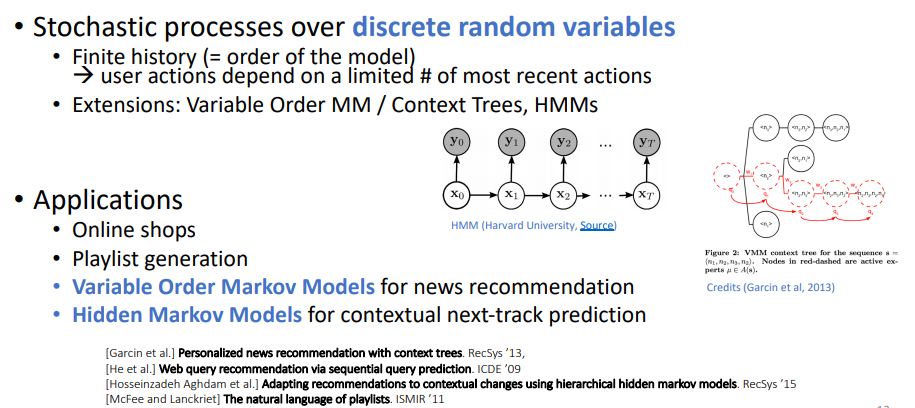

Here we fit the recommedation algorithm over the sessions in the training set.  
This recommender is based on the `MarkovChainRecommender` implemented from:

_Shani, Guy, David Heckerman, and Ronen I. Brafman. "An MDP-based recommender system." Journal of Machine Learning Research 6, no. Sep (2005): 1265-1295. Chapter 3-4_

This recommender computes the item transition matrices for any Markov Chain having order in `[min_order, max_order]`. Each individual Markov Chain model employes some heristics like skipping or clustering to deal better with data sparsity. Recommendations are generated by sorting items by their transition probability to being next, given the user profile. The scores coming from different MC are weighted _inversely_ wrt to their order.

The class `MixedMarkovChainRecommender` has the following initialization hyper-parameters:
* `min_order`: the minimum order of the Mixed Markov Chain
* `max_order`: the maximum order of the Mixed Markov Chain

In [ ]:
#hide
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
#hide
def add_nodes_to_graph(seqs, last_k):
    t = SmartTree()
    rootNode = t.set_root()

    countDict = {}
    G = nx.DiGraph()
    for s in seqs:
        nearHistory = tuple(s[-(last_k):])
        if nearHistory in countDict:
            # increment count
            countDict[nearHistory] += 1
        else:
            # init count
            countDict[nearHistory] = 1
            # add seq to sequence tree
            t.add_path(rootNode, list(nearHistory))
            # add node to graph
            G.add_node(nearHistory)

        ## i also have to save the sequence of length k+1 because otherwise I cannot calculate the count
        ## from state x to state y. So the seqeunces of length k+1 are in the tree but not in the states
        nearHistoryLong = tuple(
            s[-(last_k + 1):])  # +1 because I need one more element to calculate the transition prob
        if nearHistory != nearHistoryLong:  # otherwise short seq are counted double
            if nearHistoryLong in countDict:
                # increment count
                countDict[nearHistoryLong] += 1
            else:
                # init count
                countDict[nearHistoryLong] = 1
    return (t, countDict, G)


def add_edges(t, countDict, G, last_k):
    """
    :param t: Tree of the sequnces available as states
    :param countDict: dicionary counting the occurence for each sequence
    :param G: the graph containing the states (each one is a sequence)
    :param last_k: the number of recent item considered
    :return: the same graph G, with edges connecting states
    """
    # add links
    rootNode = t.get_root()
    for node in G.nodes_iter():
        # if the sequence is shorter than states's len, the next state has all the sequence as prefix
        next_state_prefix = node[1:] if len(node) == last_k else node
        p = t.find_path(rootNode, next_state_prefix)
        if t.path_is_valid(p):
            children = t.get_nodes_tag(t[p].fpointer)
            for c in children:
                # the tree may suggest a children which is not a state of the graph, because it was part of a longer
                # sequence, in that case no edge has to be added
                if next_state_prefix + (c,) in G.nodes():
                    if countDict.get(node + (c,), 0) != 0:  # do not add edge if count is 0
                        G.add_edge(node, next_state_prefix + (c,), {'count': countDict.get(node + (c,), 0)})
    return G


def apply_skipping(G, last_k, seqs):
    # iterate over seqs to add skipping count
    window = last_k

    for us in seqs:
        s = tuple(us)
        for i in range(len(s) - window):
            previous_state = s[i:i + window]
            next_state_prefix = previous_state[1:]
            for j in range(i + window + 1, len(s)):
                fractional_count = 1 / (2 ** (j - (i + window)))
                next_state = next_state_prefix + (s[j],)
                # update count
                old_count = G.get_edge_data(previous_state, next_state, {}).get('count', 0)
                if G.has_edge(previous_state, next_state):
                    G[previous_state][next_state]['count'] = old_count + fractional_count
                else:
                    G.add_edge(previous_state, next_state, {'count': fractional_count})
                # print('updating '+str(previous_state)+'->'+str(next_state)+' from '+str(old_count)+' to '+str(old_count+fractional_count))

    # normalize
    for n in G.nodes_iter():
        edges = G.out_edges(n)
        countSum = reduce(lambda x, y: x + y, [G[x[0]][x[1]]['count'] for x in edges], 0)
        for e in edges:
            G[e[0]][e[1]]['count'] = G[e[0]][e[1]]['count'] / float(countSum) if countSum else 0

    return G


def apply_clustering(G):
    ##clustering
    def sequence_similarity(s, t):
        sum = 0
        for i in range(min(len(s), len(t))):
            sum += 0 if s[i] != t[i] else (i + 2)
        return sum

    similarity_dict = {}
    # for each state in the graph, calculate similarity
    for node in G.nodes_iter():
        for deno in G.nodes_iter():
            if node == deno or (node, deno) in similarity_dict:
                continue  # skip if same or already done
            else:
                sim = sequence_similarity(node, deno)
                if sim:  # save only if different from zero
                    similarity_dict[node, deno] = similarity_dict[deno, node] = sim

    similarity_count_dict = {}

    for node in G.nodes_iter():
        for deno in G.nodes_iter():
            if node == deno: continue
            sum = 0
            for in_edge in G.in_edges_iter([deno]):
                intermediate_node = in_edge[0]
                if intermediate_node != node:  # I want to count the effect of going through Other nodes
                    sum += similarity_dict.get((node, intermediate_node), 0) * G[intermediate_node][deno]['count']
            if sum:
                similarity_count_dict[node, deno] = sum

    def compute_normalization_similarity_count(G, node):
        normalization_sum = 0
        for other_state in G.nodes_iter():
            # skip similarity with myself is 0 because of how similarity_dict is calculated
            normalization_sum += similarity_count_dict.get((node, other_state), 0)
        return normalization_sum

    ##update transition probability
    ### this can be made faster(?) if I store the adjancency matrix where node are connected if
    # there is a probability due to the clustering (i.e. there is an entry in similarity_count_dict
    # in this way I only have to check those edges. now it's already pretty optimized anyway
    ALPHA = 0.5
    for node in G.nodes_iter():
        normalization_sum = compute_normalization_similarity_count(G, node)

        # first half the original transition prob
        for u, v in G.out_edges_iter([node]):
            G[u][v]['count'] *= ALPHA

        # if there is similarity probability somewhere
        if normalization_sum:
            # add similarity probability
            for deno in G.nodes_iter():
                # skip if same node or there is nothing that can be added to that node
                if node == deno or similarity_count_dict.get((node, deno), 0) == 0: continue

                partial_prob = (1 - ALPHA) * similarity_count_dict.get((node, deno), 0) / normalization_sum

                if G.has_edge(node, deno):
                    G[node][deno]['count'] += partial_prob
                elif partial_prob:  # there wasn't an edge but now there is partial prob from other nodes
                    G.add_edge(node, deno, {'count': partial_prob})

    return G, similarity_dict, similarity_count_dict


In [ ]:
#collapse
class MarkovChainRecommender(ISeqRecommender):
    """
    Implementation from Shani, Guy, David Heckerman, and Ronen I. Brafman. "An MDP-based recommender system."
    Journal of Machine Learning Research 6, no. Sep (2005): 1265-1295. Chapter 3-4
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def __init__(self, order):
        """
        :param order: the order of the Markov Chain
        """
        super(MarkovChainRecommender, self).__init__()
        self.order = order

    def fit(self, train_data):
        sequences = train_data['sequence'].values

        logging.info('Building Markov Chain model with k = ' + str(self.order))
        logging.info('Adding nodes')
        self.tree, self.count_dict, self.G = add_nodes_to_graph(sequences, self.order)
        logging.info('Adding edges')
        self.G = add_edges(self.tree, self.count_dict, self.G, self.order)
        logging.info('Applying skipping')
        self.G = apply_skipping(self.G, self.order, sequences)
        logging.info('Applying clustering')
        logging.info('{} states in the graph'.format(len(self.G.nodes())))
        self.G, _, _ = apply_clustering(self.G)
        # drop not useful resources
        self.tree = None
        self.count_dict = None
        gc.collect()

    def recommend(self, user_profile, user_id=None):

        # if the user profile is longer than the markov order, chop it keeping recent history
        state = tuple(user_profile[-self.order:])
        # see if graph has that state
        recommendations = []
        if self.G.has_node(state):
            # search for recommendations in the forward star
            rec_dict = {}
            for u, v in self.G.out_edges_iter([state]):
                lastElement = tuple(v[-1:])
                if lastElement in rec_dict:
                    rec_dict[lastElement] += self.G[u][v]['count']
                else:
                    rec_dict[lastElement] = self.G[u][v]['count']
            for k, v in rec_dict.items():
                recommendations.append((list(k), v))

        return recommendations

    def _set_graph_debug(self, G):
        self.G = G


In [ ]:
#collapse
class MixedMarkovChainRecommender(ISeqRecommender):
    """
    Creates markov models with different values of k, and return recommendation by weighting the list of
    recommendation of each model.

    Reference: Shani, Guy, David Heckerman, and Ronen I. Brafman. "An MDP-based recommender system."
    Journal of Machine Learning Research 6, no. Sep (2005): 1265-1295. Chapter 3-4
    """

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    recommenders = {}

    def __init__(self, min_order=1, max_order=1):
        """
        :param min_order: the minimum order of the Mixed Markov Chain
        :param max_order: the maximum order of the Mixed Markov Chain
        """
        super(MixedMarkovChainRecommender, self).__init__()
        self.min_order = min_order
        self.max_order = max_order
        # define the models
        for i in range(self.min_order, self.max_order + 1):
            self.recommenders[i] = MarkovChainRecommender(i)

    def fit(self, user_profile):
        for order in self.recommenders:
            self.recommenders[order].fit(user_profile)

    def recommend(self, user_profile, user_id=None):
        rec_dict = {}
        recommendations = []
        sum_of_weights = 0
        for order, r in self.recommenders.items():
            rec_list = r.recommend(user_profile)
            sum_of_weights += 1 / order
            for i in rec_list:
                if tuple(i[0]) in rec_dict:
                    rec_dict[tuple(i[0])] += 1 / order * i[1]
                else:
                    rec_dict[tuple(i[0])] = 1 / order * i[1]
        for k, v in rec_dict.items():
            recommendations.append((list(k), v / sum_of_weights))

        return recommendations

    def _set_model_debug(self, recommender, order):
        self.recommenders[order] = recommender


In [ ]:
# You can try with max_order=2 or higher too, but it will take some time to complete though due to slow heristic computations
mmcrecommender = MixedMarkovChainRecommender(min_order=1, max_order=1)
mmcrecommender.fit(train_data)

2021-04-25 13:57:40,210 - INFO - Building Markov Chain model with k = 1
2021-04-25 13:57:40,213 - INFO - Adding nodes
2021-04-25 13:57:40,499 - INFO - Adding edges
2021-04-25 13:57:58,752 - INFO - Applying skipping
2021-04-25 13:57:58,973 - INFO - Applying clustering
2021-04-25 13:57:58,974 - INFO - 999 states in the graph


### FPMC

Here we fit the recommedation algorithm over the sessions in the training set.  
This recommender is based on the following paper:

_Rendle, S., Freudenthaler, C., & Schmidt-Thieme, L. (2010). Factorizing personalized Markov chains for next-basket recommendation. Proceedings of the 19th International Conference on World Wide Web - WWW ’10, 811_

In short, FPMC factorizes a personalized order-1 transition tensor using Tensor Factorization with pairwise loss function akin to BPR (Bayesian Pairwise Ranking).

TF allows to impute values for the missing transitions between items for each user. For this reason, FPMC can be used for generating _personalized_ recommendations in session-aware recommenders as well.

In this notebook, you will be able to change the number of latent factors and a few other learning hyper-parameters and see the impact on the recommendation quality.

The class `FPMCRecommender` has the following initialization hyper-parameters:
* `n_factor`: (optional) the number of latent factors
* `learn_rate`: (optional) the learning rate
* `regular`: (optional) the L2 regularization coefficient
* `n_epoch`: (optional) the number of training epochs
* `n_neg`: (optional) the number of negative samples used in BPR learning

In [ ]:
#hide
def sigmoid(x):
    if x >= 0:
        return math.exp(-np.logaddexp(0, -x))
    else:
        return math.exp(x - np.logaddexp(x, 0))


def load_data_from_dir(dirname):
    fname_user_idxseq = dirname + '/' + 'idxseq.txt'
    fname_user_list = dirname + '/' + 'user_idx_list.txt'
    fname_item_list = dirname + '/' + 'item_idx_list.txt'
    user_set = load_idx_list_file(fname_user_list)
    item_set = load_idx_list_file(fname_item_list)

    data_list = []
    with open(fname_user_idxseq, 'r') as f:
        for l in f:
            l = [int(s) for s in l.strip().split()]
            user = l[0]
            b_tm1 = list(set(l[1:-1]))
            label = l[-1]

            data_list.append((user, label, b_tm1))

    return data_list, user_set, item_set


def load_idx_list_file(fname, delimiter=','):
    idx_set = set()
    with open(fname, 'r') as f:
        # dicard header
        f.readline()

        for l in csv.reader(f, delimiter=delimiter, quotechar='"'):
            idx = int(l[0])
            idx_set.add(idx)
    return idx_set


def data_to_3_list(data_list):
    u_list = []
    i_list = []
    b_tm1_list = []
    max_l = 0
    for d in data_list:
        u_list.append(d[0])
        i_list.append(d[1])
        b_tm1_list.append(d[2])
        if len(d[2]) > max_l:
            max_l = len(d[2])
    for b_tm1 in b_tm1_list:
        b_tm1.extend([-1 for i in range(max_l - len(b_tm1))])
    b_tm1_list = np.array(b_tm1_list)

    return (u_list, i_list, b_tm1_list)


In [ ]:
#hide
class FPMC_basic:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    def __init__(self, n_user, n_item, n_factor, learn_rate, regular):
        self.user_set = set()
        self.item_set = set()

        self.n_user = n_user
        self.n_item = n_item

        self.n_factor = n_factor
        self.learn_rate = learn_rate
        self.regular = regular

    @staticmethod
    def dump(fpmcObj, fname):
        pickle.dump(fpmcObj, open(fname, 'wb'))

    @staticmethod
    def load(fname):
        return pickle.load(open(fname, 'rb'))

    def init_model(self, std=0.01):
        self.VUI = np.random.normal(0, std, size=(self.n_user, self.n_factor))
        self.VIU = np.random.normal(0, std, size=(self.n_item, self.n_factor))
        self.VIL = np.random.normal(0, std, size=(self.n_item, self.n_factor))
        self.VLI = np.random.normal(0, std, size=(self.n_item, self.n_factor))
        self.VUI_m_VIU = np.dot(self.VUI, self.VIU.T)
        self.VIL_m_VLI = np.dot(self.VIL, self.VLI.T)

    def compute_x(self, u, i, b_tm1):
        acc_val = 0.0
        for l in b_tm1:
            acc_val += np.dot(self.VIL[i], self.VLI[l])
        return (np.dot(self.VUI[u], self.VIU[i]) + (acc_val / len(b_tm1)))

    def compute_x_batch(self, u, b_tm1):
        former = self.VUI_m_VIU[u]
        latter = np.mean(self.VIL_m_VLI[:, b_tm1], axis=1).T
        return (former + latter)

    def evaluation(self, data_list):
        np.dot(self.VUI, self.VIU.T, out=self.VUI_m_VIU)
        np.dot(self.VIL, self.VLI.T, out=self.VIL_m_VLI)

        correct_count = 0
        rr_list = []
        for (u, i, b_tm1) in data_list:
            scores = self.compute_x_batch(u, b_tm1)

            if i == scores.argmax():
                correct_count += 1

            rank = len(np.where(scores > scores[i])[0]) + 1
            rr = 1.0 / rank
            rr_list.append(rr)

        try:
            acc = correct_count / len(rr_list)
            mrr = (sum(rr_list) / len(rr_list))
            return (acc, mrr)
        except:
            return (0.0, 0.0)

    def learn_epoch(self, tr_data, neg_batch_size):
        for iter_idx in range(len(tr_data)):
            (u, i, b_tm1) = random.choice(tr_data)

            exclu_set = self.item_set - set([i])
            j_list = random.sample(exclu_set, neg_batch_size)

            z1 = self.compute_x(u, i, b_tm1)
            for j in j_list:
                z2 = self.compute_x(u, j, b_tm1)
                delta = 1 - sigmoid(z1 - z2)

                VUI_update = self.learn_rate * (delta * (self.VIU[i] - self.VIU[j]) - self.regular * self.VUI[u])
                VIUi_update = self.learn_rate * (delta * self.VUI[u] - self.regular * self.VIU[i])
                VIUj_update = self.learn_rate * (-delta * self.VUI[u] - self.regular * self.VIU[j])

                self.VUI[u] += VUI_update
                self.VIU[i] += VIUi_update
                self.VIU[j] += VIUj_update

                eta = np.mean(self.VLI[b_tm1], axis=0)
                VILi_update = self.learn_rate * (delta * eta - self.regular * self.VIL[i])
                VILj_update = self.learn_rate * (-delta * eta - self.regular * self.VIL[j])
                VLI_update = self.learn_rate * (
                        (delta * (self.VIL[i] - self.VIL[j]) / len(b_tm1)) - self.regular * self.VLI[b_tm1])

                self.VIL[i] += VILi_update
                self.VIL[j] += VILj_update
                self.VLI[b_tm1] += VLI_update

    def learnSBPR_FPMC(self, tr_data, n_epoch=10, neg_batch_size=10):
        for epoch in range(n_epoch):
            self.learn_epoch(tr_data, neg_batch_size=neg_batch_size)
            self.logger.info('epoch %d done' % epoch)
            # if eval_per_epoch == True:
            #     acc_in, mrr_in = self.evaluation(tr_data)
            #     if te_data != None:
            #         acc_out, mrr_out = self.evaluation(te_data)
            #         self.logger.info ('In sample:%.4f\t%.4f \t Out sample:%.4f\t%.4f' % (acc_in, mrr_in, acc_out, mrr_out))
            #     else:
            #         self.logger.info ('In sample:%.4f\t%.4f' % (acc_in, mrr_in))
            # else:
            #

        # if eval_per_epoch == False:
        #     acc_in, mrr_in = self.evaluation(tr_data)
        #     if te_data != None:
        #         acc_out, mrr_out = self.evaluation(te_data)
        #         print ('In sample:%.4f\t%.4f \t Out sample:%.4f\t%.4f' % (acc_in, mrr_in, acc_out, mrr_out))
        #     else:
        #         print ('In sample:%.4f\t%.4f' % (acc_in, mrr_in))
        #
        # if te_data != None:
        #     return (acc_out, mrr_out)
        # else:
        #     return None


In [ ]:
#hide
class FPMC(FPMC_basic):

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger()

    def __init__(self, n_user, n_item, n_factor, learn_rate, regular):
        super(FPMC, self).__init__(n_user, n_item, n_factor, learn_rate, regular)

    def evaluation(self, data_3_list):
        np.dot(self.VUI, self.VIU.T, out=self.VUI_m_VIU)
        np.dot(self.VIL, self.VLI.T, out=self.VIL_m_VLI)
        acc, mrr = evaluation_jit(data_3_list[0], data_3_list[1], data_3_list[2], self.VUI_m_VIU, self.VIL_m_VLI)

        return acc, mrr

    def evaluation_recommender(self, user, user_profile):
        np.dot(self.VUI, self.VIU.T, out=self.VUI_m_VIU)
        np.dot(self.VIL, self.VLI.T, out=self.VIL_m_VLI)
        scores = evaluation_jit_recommender(user, user_profile, self.VUI_m_VIU, self.VIL_m_VLI)
        return sorted(range(len(scores)), key=lambda x: -scores[x]), sorted(scores, reverse=True)

    def learn_epoch(self, data_3_list, neg_batch_size):
        VUI, VIU, VLI, VIL = learn_epoch_jit(data_3_list[0], data_3_list[1], data_3_list[2], neg_batch_size,
                                             np.array(list(self.item_set)), self.VUI, self.VIU, self.VLI, self.VIL,
                                             self.learn_rate, self.regular)
        self.VUI = VUI
        self.VIU = VIU
        self.VLI = VLI
        self.VIL = VIL

    def learnSBPR_FPMC(self, tr_data, n_epoch=10, neg_batch_size=10):
        tr_3_list = data_to_3_list(tr_data)

        for epoch in range(n_epoch):
            self.learn_epoch(tr_3_list, neg_batch_size)
            self.logger.info('epoch %d done' % epoch)

        # if eval_per_epoch == False:
        #     acc_in, mrr_in = self.evaluation(tr_3_list)
        #     if te_data != None:
        #         acc_out, mrr_out = self.evaluation(te_3_list)
        #         print ('In sample:%.4f\t%.4f \t Out sample:%.4f\t%.4f' % (acc_in, mrr_in, acc_out, mrr_out))
        #     else:
        #         print ('In sample:%.4f\t%.4f' % (acc_in, mrr_in))
        #
        #
        # if te_data != None:
        #     if ret_in_score:
        #         return (acc_in, mrr_in, acc_out, mrr_out)
        #     else:
        #         return (acc_out, mrr_out)
        # else:
        #     return None


@jit(nopython=True)
def compute_x_jit(u, i, b_tm1, VUI, VIU, VLI, VIL):
    acc_val = 0.0
    for l in b_tm1:
        acc_val += np.dot(VIL[i], VLI[l])
    return (np.dot(VUI[u], VIU[i]) + (acc_val / len(b_tm1)))


@jit(nopython=True)
def learn_epoch_jit(u_list, i_list, b_tm1_list, neg_batch_size, item_set, VUI, VIU, VLI, VIL, learn_rate, regular):
    for iter_idx in range(len(u_list)):
        d_idx = np.random.randint(0, len(u_list))
        u = u_list[d_idx]
        i = i_list[d_idx]
        b_tm1 = b_tm1_list[d_idx][b_tm1_list[d_idx] != -1]

        j_list = np.random.choice(item_set, size=neg_batch_size, replace=False)
        z1 = compute_x_jit(u, i, b_tm1, VUI, VIU, VLI, VIL)
        for j in j_list:
            z2 = compute_x_jit(u, j, b_tm1, VUI, VIU, VLI, VIL)
            delta = 1 - sigmoid_jit(z1 - z2)

            VUI_update = learn_rate * (delta * (VIU[i] - VIU[j]) - regular * VUI[u])
            VIUi_update = learn_rate * (delta * VUI[u] - regular * VIU[i])
            VIUj_update = learn_rate * (-delta * VUI[u] - regular * VIU[j])

            VUI[u] += VUI_update
            VIU[i] += VIUi_update
            VIU[j] += VIUj_update

            eta = np.zeros(VLI.shape[1])
            for l in b_tm1:
                eta += VLI[l]
            eta = eta / len(b_tm1)

            VILi_update = learn_rate * (delta * eta - regular * VIL[i])
            VILj_update = learn_rate * (-delta * eta - regular * VIL[j])
            VLI_updates = np.zeros((len(b_tm1), VLI.shape[1]))
            for idx, l in enumerate(b_tm1):
                VLI_updates[idx] = learn_rate * ((delta * (VIL[i] - VIL[j]) / len(b_tm1)) - regular * VLI[l])

            VIL[i] += VILi_update
            VIL[j] += VILj_update
            for idx, l in enumerate(b_tm1):
                VLI[l] += VLI_updates[idx]

    return VUI, VIU, VLI, VIL


@jit(nopython=True)
def sigmoid_jit(x):
    if x >= 0:
        return math.exp(-np.logaddexp(0, -x))
    else:
        return math.exp(x - np.logaddexp(x, 0))


@jit(nopython=True)
def compute_x_batch_jit(u, b_tm1, VUI_m_VIU, VIL_m_VLI):
    former = VUI_m_VIU[u]
    latter = np.zeros(VIL_m_VLI.shape[0])
    for idx in range(VIL_m_VLI.shape[0]):
        for l in b_tm1:
            latter[idx] += VIL_m_VLI[idx, l]
    latter = latter / len(b_tm1)

    return (former + latter)


@jit(nopython=True)
def evaluation_jit(u_list, i_list, b_tm1_list, VUI_m_VIU, VIL_m_VLI):
    correct_count = 0
    acc_rr = 0
    for d_idx in range(len(u_list)):
        u = u_list[d_idx]
        i = i_list[d_idx]
        b_tm1 = b_tm1_list[d_idx][b_tm1_list[d_idx] != -1]
        scores = compute_x_batch_jit(u, b_tm1, VUI_m_VIU, VIL_m_VLI)

        if i == scores.argmax():
            correct_count += 1

        rank = len(np.where(scores > scores[i])[0]) + 1
        rr = 1.0 / rank
        acc_rr += rr

    acc = correct_count / len(u_list)
    mrr = acc_rr / len(u_list)
    return (acc, mrr)


@jit(nopython=True)
def evaluation_jit_recommender(user, b_tm1_list, VUI_m_VIU, VIL_m_VLI):
    u = user
    # b_tm1 = [x for x in b_tm1_list if x!=-1]
    b_tm1 = b_tm1_list
    scores = compute_x_batch_jit(u, b_tm1, VUI_m_VIU, VIL_m_VLI)

    return scores


In [ ]:
#collapse
class FPMCRecommender(ISeqRecommender):
    """
    Implementation of
    Rendle, S., Freudenthaler, C., & Schmidt-Thieme, L. (2010). Factorizing personalized Markov chains for next-basket recommendation.
    Proceedings of the 19th International Conference on World Wide Web - WWW ’10, 811

    Based on the implementation available at https://github.com/khesui/FPMC
    """

    def __init__(self, n_factor=32, learn_rate=0.01, regular=0.001, n_epoch=15, n_neg=10):
        """
        :param n_factor: (optional) the number of latent factors
        :param learn_rate: (optional) the learning rate
        :param regular: (optional) the L2 regularization coefficient
        :param n_epoch: (optional) the number of training epochs
        :param n_neg: (optional) the number of negative samples used in BPR learning
        """
        super(FPMCRecommender, self).__init__()
        self.n_epoch = n_epoch
        self.n_neg = n_neg
        self.n_factor = n_factor
        self.learn_rate = learn_rate
        self.regular = regular

    def __str__(self):
        return 'FPMCRecommender(n_epoch={n_epoch}, ' \
               'n_neg={n_neg}, ' \
               'n_factor={n_factor}, ' \
               'learn_rate={learn_rate}, ' \
               'regular={regular})'.format(**self.__dict__)

    def fit(self, train_data):
        self._declare(train_data)

        train_data_supervised = []

        for i, row in train_data.iterrows():
            u = self.user_mapping[row['user_id']]

            seq = []
            if len(row['sequence']) > 1:  # cannot use sequences with length 1 for supervised learning
                for item in row['sequence']:
                    i = self.item_mapping[item]
                    seq.append(i)

                train_data_supervised.append((u, seq[len(seq) - 1], seq[:len(seq) - 1]))

        self.fpmc = FPMC(n_user=len(self.user_mapping), n_item=len(self.item_mapping),
                         n_factor=self.n_factor, learn_rate=self.learn_rate, regular=self.regular)

        self.fpmc.user_set = set(self.user_mapping.values())
        self.fpmc.item_set = set(self.item_mapping.values())
        self.fpmc.init_model()

        self.fpmc.learnSBPR_FPMC(train_data_supervised, n_epoch=self.n_epoch, neg_batch_size=self.n_neg)

    def recommend(self, user_profile, user_id=None):
        context = []
        for item in user_profile:
            context.append(self.item_mapping[item])

        items, scores = self.fpmc.evaluation_recommender(self.user_mapping[user_id], context)
        recommendations = []

        for i, it in enumerate(items):
            recommendations.append(([self.reverse_item_mapping[it]], scores[i]))
        return recommendations

    def _declare(self, data):
        self.user_mapping = {}
        self.item_mapping = {}
        self.reverse_item_mapping = {}

        user_counter = 0
        item_counter = 0
        for i, row in data.iterrows():
            if row['user_id'] not in self.user_mapping:
                self.user_mapping[row['user_id']] = user_counter
                user_counter += 1

            for item in row['sequence']:
                if item not in self.item_mapping:
                    self.item_mapping[item] = item_counter
                    self.reverse_item_mapping[item_counter] = item
                    item_counter += 1


In [ ]:
fpmcrecommender = FPMCRecommender(n_factor=16, n_epoch=5)
fpmcrecommender.fit(train_data)

2021-04-25 13:59:28,886 - INFO - epoch 0 done
2021-04-25 13:59:28,992 - INFO - epoch 1 done
2021-04-25 13:59:29,107 - INFO - epoch 2 done
2021-04-25 13:59:29,217 - INFO - epoch 3 done
2021-04-25 13:59:29,330 - INFO - epoch 4 done


### Prod2vec

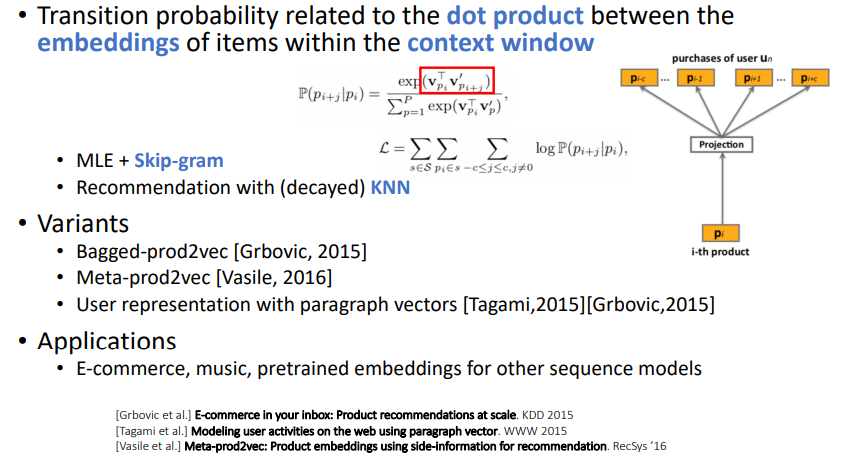

Here we fit the recommedation algorithm over the sessions in the training set.  

This is simplified implementation of the following:

_Grbovic, Mihajlo, Vladan Radosavljevic, Nemanja Djuric, Narayan Bhamidipati,
Jaikit Savla, Varun Bhagwan, and Doug Sharp. "E-commerce in your inbox: Product recommendations at scale."
 In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1809-1818. ACM, 2015._
 
This implementation uses the `gensim` implementation of Word2Vec to compute item embeddings using the skip-gram model.

Recommendations are generated by returning the k-nearest neighbors of the last items in the user profile, whose relevance is weighted using a simple *exponential decay* (the *last item* in the user profile is the *most relevant* one, and the *first item* the *least relevant*).

The original paper contains other variants of this algorithm (namely bagged-prod2vec and prod2vec-cluster) which are not subject of this tutorial. 

The class `Prod2VecRecommender` has the following initialization hyper-parameters:
* `min_count`: the minimum item frequency. Items less frequent that min_count will be pruned
* `size`: the size of the embeddings
* `window`: the size of the context window
* `decay_alpha`: the exponential decay factor used to discount the similarity scores for items  back in the user profile. Lower values mean higher discounting of past user interactions. Allows values in [0-1]
* `workers`: the number of threads used for training

In [ ]:
#collapse
class Prod2VecRecommender(ISeqRecommender):
    """
    Implementation of the Prod2Vec skipgram model from
    Grbovic Mihajlo, Vladan Radosavljevic, Nemanja Djuric, Narayan Bhamidipati, Jaikit Savla, Varun Bhagwan, and Doug Sharp.
    "E-commerce in your inbox: Product recommendations at scale."
    In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining,
    pp. 1809-1818. ACM, 2015.
    """

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def __init__(self, min_count=2, size=100, window=5, decay_alpha=0.9, workers=4):
        """
        :param min_count: (optional) the minimum item frequency. Items less frequent that min_count will be pruned
        :param size: (optional) the size of the embeddings
        :param window: (optional) the size of the context window
        :param decay_alpha: (optional) the exponential decay factor used to discount the similarity scores for items
                back in the user profile. Lower values mean higher discounting of past user interactions. Allows values in [0-1].
        :param workers: (optional) the number of threads used for training
        """
        super(Prod2VecRecommender, self).__init__()
        self.min_count = min_count
        self.size = size
        self.window = window
        self.decay_alpha = decay_alpha
        self.workers = workers

    def __str__(self):
        return 'Prod2VecRecommender(min_count={min_count}, ' \
               'size={size}, ' \
               'window={window}, ' \
               'decay_alpha={decay_alpha}, ' \
               'workers={workers})'.format(**self.__dict__)

    def fit(self, train_data):
        sequences = train_data['sequence'].values
        self.model = gensim.models.Word2Vec(sequences,
                                            min_count=self.min_count,
                                            window=self.window,
                                            hs=1,
                                            size=self.size,
                                            sg=1,
                                            workers=self.workers)

    def recommend(self, user_profile, user_id=None):
        user_profile = list(map(str, user_profile))
        rec = []
        try:
            # iterate the user profile backwards
            for i, item in enumerate(user_profile[::-1]):
                ms = self.model.most_similar(positive=item)
                # apply exponential decay to the similarity scores
                decay = self.decay_alpha ** i
                ms = [(x[0], decay * x[1]) for x in ms]
                rec.extend(ms)
            # sort items by similarity score
            rec = sorted(rec, key=lambda x: -x[1])
        except KeyError:
            rec = []
        return [([x[0]], x[1]) for x in rec]


In [ ]:
#hide-output
p2vrecommender = Prod2VecRecommender(min_count=2, 
                                  size=50, 
                                  window=5,
                                  decay_alpha=0.9,
                                  workers=4)
p2vrecommender.fit(train_data)

2021-04-25 14:00:15,839 - WARNING - consider setting layer size to a multiple of 4 for greater performance
2021-04-25 14:00:15,842 - INFO - collecting all words and their counts
2021-04-25 14:00:15,844 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-25 14:00:15,853 - INFO - collected 999 word types from a corpus of 12146 raw words and 2600 sentences
2021-04-25 14:00:15,855 - INFO - Loading a fresh vocabulary
2021-04-25 14:00:15,860 - INFO - effective_min_count=2 retains 997 unique words (99% of original 999, drops 2)
2021-04-25 14:00:15,862 - INFO - effective_min_count=2 leaves 12144 word corpus (99% of original 12146, drops 2)
2021-04-25 14:00:15,869 - INFO - deleting the raw counts dictionary of 999 items
2021-04-25 14:00:15,871 - INFO - sample=0.001 downsamples 37 most-common words
2021-04-25 14:00:15,873 - INFO - downsampling leaves estimated 11838 word corpus (97.5% of prior 12144)
2021-04-25 14:00:15,876 - INFO - constructing a huffman tree from

### Session based RNN

Here we fit the recommedation algorithm over the sessions in the training set.  

This is a **simplified** interface to Recurrent Neural Network models for Session-based recommendation.
Based on the following two papers:

* Recurrent Neural Networks with Top-k Gains for Session-based Recommendations, Hidasi and Karatzoglou, CIKM 2018
* Personalizing Session-based Recommendation with Hierarchical Recurrent Neural Networks, Quadrana et al, Recsys 2017

In this notebook, we will consider the session-based (**non-personalized**) version of the algorithm. 
Here's a schematic representation of the model:

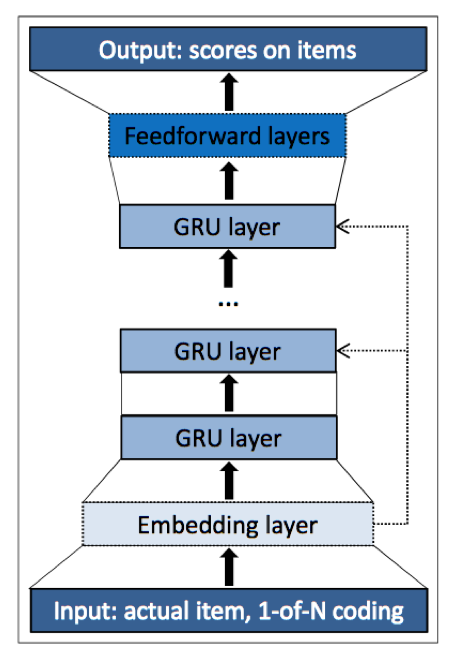

Each item in the current user session is first encoded either using _1-hot encoding_ or a _dense embedding vector_. The item representation is then forwarded to one or more Gated Reucurrent Unit (GRU) layers, which "mix" the information coming from the past steps of the sequence with the representation of the current item. The last hidden state of the network is finally use to compute the likelihood scores for the next items by using one out of several loss functions (e.g. cross-entropy, BPR, TOP1, BPR-max, TOP1-max, etc.).

For simplicity, we only support _1-hot encoded_ inputs and the _BPR-max_ loss function here.

The hyper-parameters of the model are:

* `session_layers`: number of units per layer used at session level.
    It has to be a list of integers for multi-layer networks, or a integer value for single-layer networks.
* `user_layers`: number of units per layer used at user level. Required only by personalized models. (`None` in this case)
* `batch_size`: the mini-batch size used in training
* `learning_rate`: the learning rate used in training (Adagrad optimized)
* `momentum`: the momentum coefficient used in training
* `dropout`: it's a float value for the hidden-layer(s) dropout.
* `epochs`: number of training epochs
* `personalized`: whether to train a personalized model using the HRNN model (`False` in this case).


**NOTE: GRU4Rec originally has many more hyper-parameters. Going through all of them is out from the scope of this tutorial, but we suggest to check-out the original source code [here](https://github.com/hidasib/GRU4Rec) if you are interested.**


In [ ]:
#hide
def dataset_to_gru4rec_format(dataset):
    """
    Convert a list of sequences to GRU4Rec format.
    Based on this StackOverflow answer: https://stackoverflow.com/a/48532692

    :param dataset: the dataset to be transformed
    """

    lst_col = 'sequence'
    df = dataset.reset_index()
    unstacked = pd.DataFrame({
        col: np.repeat(df[col].values, df[lst_col].str.len()) for col in df.columns.drop(lst_col)}
    ).assign(**{lst_col: np.concatenate(df[lst_col].values)})[df.columns]
    # ensure that events in the session have increasing timestamps
    unstacked['ts'] = unstacked['ts'] + unstacked.groupby('user_id').cumcount()
    unstacked.rename(columns={'sequence': 'item_id'}, inplace=True)
    return unstacked

In [ ]:
#hide
def gpu_diag_wide(X):
    E = T.eye(*X.shape)
    return T.sum(X*E, axis=1)

def gpu_diag_tall(X):
    E = T.eye(*X.shape)
    return T.sum(X*E, axis=0)

In [ ]:
#hide
mrng = MRG_RandomStreams()

In [ ]:
#collapse
class GRU4Rec:
    '''
    GRU4Rec(loss='bpr-max', final_act='elu-1', hidden_act='tanh', layers=[100],
                 n_epochs=10, batch_size=32, dropout_p_hidden=0.0, dropout_p_embed=0.0, learning_rate=0.1, momentum=0.0, lmbd=0.0, embedding=0, n_sample=2048, sample_alpha=0.75, smoothing=0.0, constrained_embedding=False,
                 adapt='adagrad', adapt_params=[], grad_cap=0.0, bpreg=1.0,
                 sigma=0.0, init_as_normal=False, train_random_order=False, time_sort=True,
                 session_key='SessionId', item_key='ItemId', time_key='Time')
    Initializes the network.

    Parameters
    -----------
    loss : 'top1', 'bpr', 'cross-entropy', 'xe_logit', 'top1-max', 'bpr-max'
        selects the loss function (default : 'bpr-max')
    final_act : 'softmax', 'linear', 'relu', 'tanh', 'softmax_logit', 'leaky-<X>', 'elu-<X>', 'selu-<X>-<Y>'
        selects the activation function of the final layer, <X> and <Y> are the parameters of the activation function (default : 'elu-1')
    hidden_act : 'linear', 'relu', 'tanh', 'leaky-<X>', 'elu-<X>', 'selu-<X>-<Y>'
        selects the activation function on the hidden states, <X> and <Y> are the parameters of the activation function (default : 'tanh')
    layers : list of int values
        list of the number of GRU units in the layers (default : [100])
    n_epochs : int
        number of training epochs (default: 10)
    batch_size : int
        size of the minibacth, also effect the number of negative samples through minibatch based sampling (default: 32)
    dropout_p_hidden : float
        probability of dropout of hidden units (default: 0.0)
    dropout_p_embed : float
        probability of dropout of the input units, applicable only if embeddings are used (default: 0.0)
    learning_rate : float
        learning rate (default: 0.05)
    momentum : float
        if not zero, Nesterov momentum will be applied during training with the given strength (default: 0.0)
    lmbd : float
        coefficient of the L2 regularization (default: 0.0)
    embedding : int
        size of the embedding used, 0 means not to use embedding (default: 0)
    n_sample : int
        number of additional negative samples to be used (besides the other examples of the minibatch) (default: 2048)
    sample_alpha : float
        the probability of an item used as an additional negative sample is supp^sample_alpha (default: 0.75)
        (e.g.: sample_alpha=1 --> popularity based sampling; sample_alpha=0 --> uniform sampling)
    smoothing : float
        (only works with cross-entropy and xe_logit losses) if set to non-zero class labels are smoothed with this value, i.e. the expected utput is (e/N, ..., e/N, 1-e+e/N, e/N, ..., e/N) instead of (0, ..., 0, 1, 0, ..., 0), where N is the number of outputs and e is the smoothing value (default: 0.0)
    constrained_embedding : bool
        if True, the output weight matrix is also used as input embedding (default: False)
    adapt : None, 'adagrad', 'rmsprop', 'adam', 'adadelta'
        sets the appropriate learning rate adaptation strategy, use None for standard SGD (default: 'adagrad')
    adapt_params : list
        parameters for the adaptive learning methods (default: [])
    grad_cap : float
        clip gradients that exceede this value to this value, 0 means no clipping (default: 0.0)
    bpreg : float
        score regularization coefficient for the BPR-max loss function (default: 1.0)
    sigma : float
        "width" of initialization; either the standard deviation or the min/max of the init interval (with normal and uniform initializations respectively); 0 means adaptive normalization (sigma depends on the size of the weight matrix); (default: 0.0)
    init_as_normal : boolean
        False: init from uniform distribution on [-sigma,sigma]; True: init from normal distribution N(0,sigma); (default: False)
    train_random_order : boolean
        whether to randomize the order of sessions in each epoch (default: False)
    time_sort : boolean
        whether to ensure the the order of sessions is chronological (default: True)
    session_key : string
        header of the session ID column in the input file (default: 'SessionId')
    item_key : string
        header of the item ID column in the input file (default: 'ItemId')
    time_key : string
        header of the timestamp column in the input file (default: 'Time')

    '''

    def __init__(self, loss='bpr-max', final_act='linear', hidden_act='tanh', layers=[100],
                 n_epochs=10, batch_size=32, dropout_p_hidden=0.0, dropout_p_embed=0.0, learning_rate=0.1, momentum=0.0,
                 lmbd=0.0, embedding=0, n_sample=2048, sample_alpha=0.75, smoothing=0.0, constrained_embedding=False,
                 adapt='adagrad', adapt_params=[], grad_cap=0.0, bpreg=1.0,
                 sigma=0.0, init_as_normal=False, train_random_order=False, time_sort=True,
                 session_key='SessionId', item_key='ItemId', time_key='Time'):
        self.layers = layers
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.dropout_p_hidden = dropout_p_hidden
        self.dropout_p_embed = dropout_p_embed
        self.learning_rate = learning_rate
        self.adapt_params = adapt_params
        self.momentum = momentum
        self.sigma = sigma
        self.init_as_normal = init_as_normal
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.grad_cap = grad_cap
        self.bpreg = bpreg
        self.train_random_order = train_random_order
        self.lmbd = lmbd
        self.embedding = embedding
        self.constrained_embedding = constrained_embedding
        self.time_sort = time_sort
        self.adapt = adapt
        self.loss = loss
        self.set_loss_function(self.loss)
        self.final_act = final_act
        self.set_final_activation(self.final_act)
        self.hidden_act = hidden_act
        self.set_hidden_activation(self.hidden_act)
        self.n_sample = n_sample
        self.sample_alpha = sample_alpha
        self.smoothing = smoothing

    def set_loss_function(self, loss):
        if loss == 'cross-entropy':
            self.loss_function = self.cross_entropy
        elif loss == 'bpr':
            self.loss_function = self.bpr
        elif loss == 'bpr-max':
            self.loss_function = self.bpr_max
        elif loss == 'top1':
            self.loss_function = self.top1
        elif loss == 'top1-max':
            self.loss_function = self.top1_max
        elif loss == 'xe_logit':
            self.loss_function = self.cross_entropy_logits
        else:
            raise NotImplementedError

    def set_final_activation(self, final_act):
        if final_act == 'linear':
            self.final_activation = self.linear
        elif final_act == 'relu':
            self.final_activation = self.relu
        elif final_act == 'softmax':
            self.final_activation = self.softmax
        elif final_act == 'tanh':
            self.final_activation = self.tanh
        elif final_act == 'softmax_logit':
            self.final_activation = self.softmax_logit
        elif final_act.startswith('leaky-'):
            self.final_activation = self.LeakyReLU(float(final_act.split('-')[1])).execute
        elif final_act.startswith('elu-'):
            self.final_activation = self.Elu(float(final_act.split('-')[1])).execute
        elif final_act.startswith('selu-'):
            self.final_activation = self.Selu(*[float(x) for x in final_act.split('-')[1:]]).execute
        else:
            raise NotImplementedError

    def set_hidden_activation(self, hidden_act):
        if hidden_act == 'relu':
            self.hidden_activation = self.relu
        elif hidden_act == 'tanh':
            self.hidden_activation = self.tanh
        elif hidden_act == 'linear':
            self.hidden_activation = self.linear
        elif hidden_act.startswith('leaky-'):
            self.hidden_activation = self.LeakyReLU(float(hidden_act.split('-')[1])).execute
        elif hidden_act.startswith('elu-'):
            self.hidden_activation = self.Elu(float(hidden_act.split('-')[1])).execute
        elif hidden_act.startswith('selu-'):
            self.hidden_activation = self.Selu(*[float(x) for x in hidden_act.split('-')[1:]]).execute
        else:
            raise NotImplementedError

    def set_params(self, **kvargs):
        maxk_len = np.max([len(x) for x in kvargs.keys()])
        maxv_len = np.max([len(x) for x in kvargs.values()])
        for k, v in kvargs.items():
            if not hasattr(self, k):
                print('Unkown attribute: {}'.format(k))
                raise NotImplementedError
            else:
                if k == 'adapt_params':
                    v = [float(l) for l in v.split('/')]
                elif type(getattr(self, k)) == list:
                    v = [int(l) for l in v.split('/')]
                if type(getattr(self, k)) == bool:
                    if v == 'True' or v == '1':
                        v = True
                    elif v == 'False' or v == '0':
                        v = False
                    else:
                        print('Invalid value for boolean parameter: {}'.format(v))
                        raise NotImplementedError
                setattr(self, k, type(getattr(self, k))(v))
                if k == 'loss': self.set_loss_function(self.loss)
                if k == 'final_act': self.set_final_activation(self.final_act)
                if k == 'hidden_act': self.set_hidden_activation(self.hidden_act)
                print('SET   {}{}TO   {}{}(type: {})'.format(k, ' ' * (maxk_len - len(k) + 3), getattr(self, k),
                                                             ' ' * (maxv_len - len(str(getattr(self, k))) + 3),
                                                             type(getattr(self, k))))

    ######################ACTIVATION FUNCTIONS#####################
    def linear(self, X):
        return X

    def tanh(self, X):
        return T.tanh(X)

    def softmax(self, X):
        e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
        return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

    def softmax_logit(self, X):
        X = X - X.max(axis=1).dimshuffle(0, 'x')
        return T.log(T.exp(X).sum(axis=1).dimshuffle(0, 'x')) - X

    def softmax_neg(self, X):
        hm = 1.0 - T.eye(*X.shape)
        X = X * hm
        e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x')) * hm
        return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

    def relu(self, X):
        return T.maximum(X, 0)

    def sigmoid(self, X):
        return T.nnet.sigmoid(X)

    class Selu:
        def __init__(self, lmbd, alpha):
            self.lmbd = lmbd
            self.alpha = alpha

        def execute(self, X):
            return self.lmbd * T.switch(T.ge(X, 0), X, self.alpha * (T.exp(X) - 1))

    class Elu:
        def __init__(self, alpha):
            self.alpha = alpha

        def execute(self, X):
            return T.switch(T.ge(X, 0), X, self.alpha * (T.exp(X) - 1))

    class LeakyReLU:
        def __init__(self, leak):
            self.leak = leak

        def execute(self, X):
            return T.switch(T.ge(X, 0), X, self.leak * X)

    #################################LOSS FUNCTIONS################################
    def cross_entropy(self, yhat, M):
        if self.smoothing:
            n_out = M + self.n_sample
            return T.cast(T.mean(
                (1.0 - (n_out / (n_out - 1)) * self.smoothing) * (-T.log(gpu_diag_wide(yhat) + 1e-24)) + (
                            self.smoothing / (n_out - 1)) * T.sum(-T.log(yhat + 1e-24), axis=1)), theano.config.floatX)
        else:
            return T.cast(T.mean(-T.log(gpu_diag_wide(yhat) + 1e-24)), theano.config.floatX)

    def cross_entropy_logits(self, yhat, M):
        if self.smoothing:
            n_out = M + self.n_sample
            return T.cast(T.mean((1.0 - (n_out / (n_out - 1)) * self.smoothing) * gpu_diag_wide(yhat) + (
                        self.smoothing / (n_out - 1)) * T.sum(yhat, axis=1)), theano.config.floatX)
        else:
            return T.cast(T.mean(gpu_diag_wide(yhat)), theano.config.floatX)

    def bpr(self, yhat, M):
        return T.cast(T.mean(-T.log(T.nnet.sigmoid(gpu_diag_wide(yhat).dimshuffle((0, 'x')) - yhat))),
                      theano.config.floatX)

    def bpr_max(self, yhat, M):
        softmax_scores = self.softmax_neg(yhat)
        return T.cast(T.mean(-T.log(
            T.sum(T.nnet.sigmoid(gpu_diag_wide(yhat).dimshuffle((0, 'x')) - yhat) * softmax_scores,
                  axis=1) + 1e-24) + self.bpreg * T.sum((yhat ** 2) * softmax_scores, axis=1)), theano.config.floatX)

    def top1(self, yhat, M):
        ydiag = gpu_diag_wide(yhat).dimshuffle((0, 'x'))
        return T.cast(T.mean(
            T.mean(T.nnet.sigmoid(-ydiag + yhat) + T.nnet.sigmoid(yhat ** 2), axis=1) - T.nnet.sigmoid(ydiag ** 2) / (
                        M + self.n_sample)), theano.config.floatX)

    def top1_max(self, yhat, M):
        softmax_scores = self.softmax_neg(yhat)
        y = softmax_scores * (
                    T.nnet.sigmoid(-gpu_diag_wide(yhat).dimshuffle((0, 'x')) + yhat) + T.nnet.sigmoid(yhat ** 2))
        return T.cast(T.mean(T.sum(y, axis=1)), theano.config.floatX)

    ###############################################################################
    def floatX(self, X):
        return np.asarray(X, dtype=theano.config.floatX)

    def init_weights(self, shape, name=None):
        return theano.shared(self.init_matrix(shape), borrow=True, name=name)

    def init_matrix(self, shape):
        if self.sigma != 0:
            sigma = self.sigma
        else:
            sigma = np.sqrt(6.0 / (shape[0] + shape[1]))
        if self.init_as_normal:
            return self.floatX(np.random.randn(*shape) * sigma)
        else:
            return self.floatX(np.random.rand(*shape) * sigma * 2 - sigma)

    def extend_weights(self, W, n_new):
        matrix = W.get_value()
        sigma = self.sigma if self.sigma != 0 else np.sqrt(6.0 / (matrix.shape[0] + matrix.shape[1] + n_new))
        if self.init_as_normal:
            new_rows = self.floatX(np.random.randn(n_new, matrix.shape[1]) * sigma)
        else:
            new_rows = self.floatX(np.random.rand(n_new, matrix.shape[1]) * sigma * 2 - sigma)
        W.set_value(np.vstack([matrix, new_rows]))

    def init(self, data):
        data.sort_values([self.session_key, self.time_key], inplace=True)
        offset_sessions = np.zeros(data[self.session_key].nunique() + 1, dtype=np.int32)
        offset_sessions[1:] = data.groupby(self.session_key).size().cumsum()
        np.random.seed(42)
        self.Wx, self.Wh, self.Wrz, self.Bh, self.H = [], [], [], [], []
        if self.constrained_embedding:
            n_features = self.layers[-1]
        elif self.embedding:
            self.E = self.init_weights((self.n_items, self.embedding), name='E')
            n_features = self.embedding
        else:
            n_features = self.n_items
        for i in range(len(self.layers)):
            m = []
            m.append(self.init_matrix((self.layers[i - 1] if i > 0 else n_features, self.layers[i])))
            m.append(self.init_matrix((self.layers[i - 1] if i > 0 else n_features, self.layers[i])))
            m.append(self.init_matrix((self.layers[i - 1] if i > 0 else n_features, self.layers[i])))
            self.Wx.append(
                theano.shared(value=np.hstack(m), borrow=True, name='Wx{}'.format(i)))  # For compatibility's sake
            self.Wh.append(self.init_weights((self.layers[i], self.layers[i]), name='Wh{}'.format(i)))
            m2 = []
            m2.append(self.init_matrix((self.layers[i], self.layers[i])))
            m2.append(self.init_matrix((self.layers[i], self.layers[i])))
            self.Wrz.append(
                theano.shared(value=np.hstack(m2), borrow=True, name='Wrz{}'.format(i)))  # For compatibility's sake
            self.Bh.append(theano.shared(value=np.zeros((self.layers[i] * 3,), dtype=theano.config.floatX), borrow=True,
                                         name='Bh{}'.format(i)))
            self.H.append(theano.shared(value=np.zeros((self.batch_size, self.layers[i]), dtype=theano.config.floatX),
                                        borrow=True, name='H{}'.format(i)))
        self.Wy = self.init_weights((self.n_items, self.layers[-1]), name='Wy')
        self.By = theano.shared(value=np.zeros((self.n_items, 1), dtype=theano.config.floatX), borrow=True, name='By')
        return offset_sessions

    def dropout(self, X, drop_p):
        if drop_p > 0:
            retain_prob = 1 - drop_p
            X *= mrng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) / retain_prob
        return X

    def adam(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        v1 = np.float32(self.adapt_params[0])
        v2 = np.float32(1.0 - self.adapt_params[0])
        v3 = np.float32(self.adapt_params[1])
        v4 = np.float32(1.0 - self.adapt_params[1])
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        meang = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        countt = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = v3 * acc + v4 * (grad ** 2)
            meang_new = v1 * meang + v2 * grad
            countt_new = countt + 1
            updates[acc] = acc_new
            updates[meang] = meang_new
            updates[countt] = countt_new
        else:
            acc_s = acc[sample_idx]
            meang_s = meang[sample_idx]
            countt_s = countt[sample_idx]
            #            acc_new = v3 * acc_s + v4 * (grad**2) #Faster, but inaccurate when an index occurs multiple times
            #            updates[acc] = T.set_subtensor(acc_s, acc_new) #Faster, but inaccurate when an index occurs multiple times
            updates[acc] = T.inc_subtensor(T.set_subtensor(acc_s, acc_s * v3)[sample_idx],
                                           v4 * (grad ** 2))  # Slower, but accurate when an index occurs multiple times
            acc_new = updates[acc][sample_idx]  # Slower, but accurate when an index occurs multiple times
            #            meang_new = v1 * meang_s + v2 * grad
            #            updates[meang] = T.set_subtensor(meang_s, meang_new) #Faster, but inaccurate when an index occurs multiple times
            updates[meang] = T.inc_subtensor(T.set_subtensor(meang_s, meang_s * v1)[sample_idx], v2 * (
                        grad ** 2))  # Slower, but accurate when an index occurs multiple times
            meang_new = updates[meang][sample_idx]  # Slower, but accurate when an index occurs multiple times
            countt_new = countt_s + 1.0
            updates[countt] = T.set_subtensor(countt_s, countt_new)
        return (meang_new / (1 - v1 ** countt_new)) / (T.sqrt(acc_new / (1 - v1 ** countt_new)) + epsilon)

    def adagrad(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = acc + grad ** 2
            updates[acc] = acc_new
        else:
            acc_s = acc[sample_idx]
            acc_new = acc_s + grad ** 2
            updates[acc] = T.set_subtensor(acc_s, acc_new)
        gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
        return grad / gradient_scaling

    def adadelta(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        v1 = np.float32(self.adapt_params[0])
        v2 = np.float32(1.0 - self.adapt_params[0])
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        upd = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = v1 * acc + v2 * (grad ** 2)
            updates[acc] = acc_new
            grad_scaling = (upd + epsilon) / (acc_new + epsilon)
            upd_new = v1 * upd + v2 * grad_scaling * (grad ** 2)
            updates[upd] = upd_new
        else:
            acc_s = acc[sample_idx]
            #            acc_new = v1 * acc_s + v2 * (grad**2) #Faster, but inaccurate when an index occurs multiple times
            #            updates[acc] = T.set_subtensor(acc_s, acc_new) #Faster, but inaccurate when an index occurs multiple times
            updates[acc] = T.inc_subtensor(T.set_subtensor(acc_s, acc_s * v1)[sample_idx],
                                           v2 * (grad ** 2))  # Slower, but accurate when an index occurs multiple times
            acc_new = updates[acc][sample_idx]  # Slower, but accurate when an index occurs multiple times
            upd_s = upd[sample_idx]
            grad_scaling = (upd_s + epsilon) / (acc_new + epsilon)
            #            updates[upd] = T.set_subtensor(upd_s, v1 * upd_s + v2 * grad_scaling * (grad**2)) #Faster, but inaccurate when an index occurs multiple times
            updates[upd] = T.inc_subtensor(T.set_subtensor(upd_s, upd_s * v1)[sample_idx], v2 * grad_scaling * (
                        grad ** 2))  # Slower, but accurate when an index occurs multiple times
        gradient_scaling = T.cast(T.sqrt(grad_scaling), theano.config.floatX)
        if self.learning_rate != 1.0:
            print('Warn: learning_rate is not 1.0 while using adadelta. Setting learning_rate to 1.0')
            self.learning_rate = 1.0
        return grad * gradient_scaling  # Ok, checked

    def rmsprop(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        v1 = np.float32(self.adapt_params[0])
        v2 = np.float32(1.0 - self.adapt_params[0])
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = v1 * acc + v2 * grad ** 2
            updates[acc] = acc_new
        else:
            acc_s = acc[sample_idx]
            #            acc_new = v1 * acc_s + v2 * grad ** 2 #Faster, but inaccurate when an index occurs multiple times
            #            updates[acc] = T.set_subtensor(acc_s, acc_new) #Faster, but inaccurate when an index occurs multiple times
            updates[acc] = T.inc_subtensor(T.set_subtensor(acc_s, acc_s * v1)[sample_idx],
                                           v2 * grad ** 2)  # Slower, but accurate when an index occurs multiple times
            acc_new = updates[acc][sample_idx]  # Slower, but accurate when an index occurs multiple times
        gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
        return grad / gradient_scaling

    def RMSprop(self, cost, params, full_params, sampled_params, sidxs, epsilon=1e-6):
        grads = [T.grad(cost=cost, wrt=param) for param in params]
        sgrads = [T.grad(cost=cost, wrt=sparam) for sparam in sampled_params]
        updates = OrderedDict()
        if self.grad_cap > 0:
            norm = T.cast(T.sqrt(T.sum([T.sum([T.sum(g ** 2) for g in g_list]) for g_list in grads]) + T.sum(
                [T.sum(g ** 2) for g in sgrads])), theano.config.floatX)
            grads = [[T.switch(T.ge(norm, self.grad_cap), g * self.grad_cap / norm, g) for g in g_list] for g_list in
                     grads]
            sgrads = [T.switch(T.ge(norm, self.grad_cap), g * self.grad_cap / norm, g) for g in sgrads]
        for p_list, g_list in zip(params, grads):
            for p, g in zip(p_list, g_list):
                if self.adapt == 'adagrad':
                    g = self.adagrad(p, g, updates)
                elif self.adapt == 'rmsprop':
                    g = self.rmsprop(p, g, updates)
                elif self.adapt == 'adadelta':
                    g = self.adadelta(p, g, updates)
                elif self.adapt == 'adam':
                    g = self.adam(p, g, updates)
                if self.momentum > 0:
                    velocity = theano.shared(p.get_value(borrow=False) * 0., borrow=True)
                    velocity2 = self.momentum * velocity - np.float32(self.learning_rate) * (g + self.lmbd * p)
                    updates[velocity] = velocity2
                    updates[p] = p + velocity2
                else:
                    updates[p] = p * np.float32(1.0 - self.learning_rate * self.lmbd) - np.float32(
                        self.learning_rate) * g
        for i in range(len(sgrads)):
            g = sgrads[i]
            fullP = full_params[i]
            sample_idx = sidxs[i]
            sparam = sampled_params[i]
            if self.adapt == 'adagrad':
                g = self.adagrad(fullP, g, updates, sample_idx)
            elif self.adapt == 'rmsprop':
                g = self.rmsprop(fullP, g, updates, sample_idx)
            elif self.adapt == 'adadelta':
                g = self.adadelta(fullP, g, updates, sample_idx)
            elif self.adapt == 'adam':
                g = self.adam(fullP, g, updates, sample_idx)
            if self.lmbd > 0:
                delta = np.float32(self.learning_rate) * (g + self.lmbd * sparam)
            else:
                delta = np.float32(self.learning_rate) * g
            if self.momentum > 0:
                velocity = theano.shared(fullP.get_value(borrow=False) * 0., borrow=True)
                vs = velocity[sample_idx]
                velocity2 = self.momentum * vs - delta
                updates[velocity] = T.set_subtensor(vs, velocity2)
                updates[fullP] = T.inc_subtensor(sparam, velocity2)
            else:
                updates[fullP] = T.inc_subtensor(sparam, - delta)
        return updates

    def model(self, X, H, M, R=None, Y=None, drop_p_hidden=0.0, drop_p_embed=0.0, predict=False):
        sparams, full_params, sidxs = [], [], []
        if self.constrained_embedding:
            if Y is not None: X = T.concatenate([X, Y], axis=0)
            S = self.Wy[X]
            Sx = S[:M]
            Sy = S[M:]
            y = self.dropout(Sx, drop_p_embed)
            H_new = []
            start = 0
            sparams.append(S)
            full_params.append(self.Wy)
            sidxs.append(X)
        elif self.embedding:
            Sx = self.E[X]
            y = self.dropout(Sx, drop_p_embed)
            H_new = []
            start = 0
            sparams.append(Sx)
            full_params.append(self.E)
            sidxs.append(X)
        else:
            Sx = self.Wx[0][X]
            vec = Sx + self.Bh[0]
            rz = T.nnet.sigmoid(vec[:, self.layers[0]:] + T.dot(H[0], self.Wrz[0]))
            h = self.hidden_activation(T.dot(H[0] * rz[:, :self.layers[0]], self.Wh[0]) + vec[:, :self.layers[0]])
            z = rz[:, self.layers[0]:]
            h = (1.0 - z) * H[0] + z * h
            h = self.dropout(h, drop_p_hidden)
            y = h
            H_new = [T.switch(R.dimshuffle((0, 'x')), 0, h) if not predict else h]
            start = 1
            sparams.append(Sx)
            full_params.append(self.Wx[0])
            sidxs.append(X)
        for i in range(start, len(self.layers)):
            vec = T.dot(y, self.Wx[i]) + self.Bh[i]
            rz = T.nnet.sigmoid(vec[:, self.layers[i]:] + T.dot(H[i], self.Wrz[i]))
            h = self.hidden_activation(T.dot(H[i] * rz[:, :self.layers[i]], self.Wh[i]) + vec[:, :self.layers[i]])
            z = rz[:, self.layers[i]:]
            h = (1.0 - z) * H[i] + z * h
            h = self.dropout(h, drop_p_hidden)
            y = h
            H_new.append(T.switch(R.dimshuffle((0, 'x')), 0, h) if not predict else h)
        if Y is not None:
            if (not self.constrained_embedding) or predict:
                Sy = self.Wy[Y]
                sparams.append(Sy)
                full_params.append(self.Wy)
                sidxs.append(Y)
            SBy = self.By[Y]
            sparams.append(SBy)
            full_params.append(self.By)
            sidxs.append(Y)
            if predict and self.final_act == 'softmax_logit':
                y = self.softmax(T.dot(y, Sy.T) + SBy.flatten())
            else:
                y = self.final_activation(T.dot(y, Sy.T) + SBy.flatten())
            return H_new, y, sparams, full_params, sidxs
        else:
            if predict and self.final_act == 'softmax_logit':
                y = self.softmax(T.dot(y, self.Wy.T) + self.By.flatten())
            else:
                y = self.final_activation(T.dot(y, self.Wy.T) + self.By.flatten())
            return H_new, y, sparams, full_params, sidxs

    def generate_neg_samples(self, pop, length):
        if self.sample_alpha:
            sample = np.searchsorted(pop, np.random.rand(self.n_sample * length))
        else:
            sample = np.random.choice(self.n_items, size=self.n_sample * length)
        if length > 1:
            sample = sample.reshape((length, self.n_sample))
        return sample

    def fit(self, data, sample_store=10000000):
        '''
        Trains the network.

        Parameters
        --------
        data : pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        sample_store : int
            If additional negative samples are used (n_sample > 0), the efficiency of GPU utilization can be sped up, by precomputing a large batch of negative samples (and recomputing when necessary).
            This parameter regulizes the size of this precomputed ID set. Its value is the maximum number of int values (IDs) to be stored. Precomputed IDs are stored in the RAM.
            For the most efficient computation, a balance must be found between storing few examples and constantly interrupting GPU computations for a short time vs. computing many examples and interrupting GPU computations for a long time (but rarely).

        '''
        self.predict = None
        self.error_during_train = False
        itemids = data[self.item_key].unique()
        self.n_items = len(itemids)
        self.itemidmap = pd.Series(data=np.arange(self.n_items), index=itemids)
        data = pd.merge(data, pd.DataFrame({self.item_key: itemids, 'ItemIdx': self.itemidmap[itemids].values}),
                        on=self.item_key, how='inner')
        offset_sessions = self.init(data)
        if self.n_sample:
            pop = data.groupby(self.item_key).size()
            pop = pop[self.itemidmap.index.values].values ** self.sample_alpha
            pop = pop.cumsum() / pop.sum()
            pop[-1] = 1
            if sample_store:
                generate_length = sample_store // self.n_sample
                if generate_length <= 1:
                    sample_store = 0
                    print('No example store was used')
                else:
                    neg_samples = self.generate_neg_samples(pop, generate_length)
                    sample_pointer = 0
            else:
                print('No example store was used')
        X = T.ivector()
        Y = T.ivector()
        M = T.iscalar()
        R = T.bvector()
        H_new, Y_pred, sparams, full_params, sidxs = self.model(X, self.H, M, R, Y, self.dropout_p_hidden,
                                                                self.dropout_p_embed)
        cost = (M / self.batch_size) * self.loss_function(Y_pred, M)
        params = [self.Wx if self.embedding or self.constrained_embedding else self.Wx[1:], self.Wh, self.Wrz, self.Bh]
        updates = self.RMSprop(cost, params, full_params, sparams, sidxs)
        for i in range(len(self.H)):
            updates[self.H[i]] = H_new[i]
        train_function = function(inputs=[X, Y, M, R], outputs=cost, updates=updates, allow_input_downcast=True)
        base_order = np.argsort(
            data.groupby(self.session_key)[self.time_key].min().values) if self.time_sort else np.arange(
            len(offset_sessions) - 1)
        data_items = data.ItemIdx.values
        for epoch in range(self.n_epochs):
            for i in range(len(self.layers)):
                self.H[i].set_value(np.zeros((self.batch_size, self.layers[i]), dtype=theano.config.floatX),
                                    borrow=True)
            c = []
            cc = []
            session_idx_arr = np.random.permutation(len(offset_sessions) - 1) if self.train_random_order else base_order
            iters = np.arange(self.batch_size)
            maxiter = iters.max()
            start = offset_sessions[session_idx_arr[iters]]
            end = offset_sessions[session_idx_arr[iters] + 1]
            finished = False
            while not finished:
                minlen = (end - start).min()
                out_idx = data_items[start]
                for i in range(minlen - 1):
                    in_idx = out_idx
                    out_idx = data_items[start + i + 1]
                    if self.n_sample:
                        if sample_store:
                            if sample_pointer == generate_length:
                                neg_samples = self.generate_neg_samples(pop, generate_length)
                                sample_pointer = 0
                            sample = neg_samples[sample_pointer]
                            sample_pointer += 1
                        else:
                            sample = self.generate_neg_samples(pop, 1)
                        y = np.hstack([out_idx, sample])
                    else:
                        y = out_idx
                        if self.n_sample:
                            if sample_pointer == generate_length:
                                generate_samples()
                                sample_pointer = 0
                            sample_pointer += 1
                    reset = (start + i + 1 == end - 1)
                    cost = train_function(in_idx, y, len(iters), reset)
                    c.append(cost)
                    cc.append(len(iters))
                    if np.isnan(cost):
                        print(str(epoch) + ': NaN error!')
                        self.error_during_train = True
                        return
                start = start + minlen - 1
                finished_mask = (end - start <= 1)
                n_finished = finished_mask.sum()
                iters[finished_mask] = maxiter + np.arange(1, n_finished + 1)
                maxiter += n_finished
                valid_mask = (iters < len(offset_sessions) - 1)
                n_valid = valid_mask.sum()
                if (n_valid == 0) or (n_valid < 2 and self.n_sample == 0):
                    finished = True
                    break
                mask = finished_mask & valid_mask
                sessions = session_idx_arr[iters[mask]]
                start[mask] = offset_sessions[sessions]
                end[mask] = offset_sessions[sessions + 1]
                iters = iters[valid_mask]
                start = start[valid_mask]
                end = end[valid_mask]
                if n_valid < len(valid_mask):
                    for i in range(len(self.H)):
                        tmp = self.H[i].get_value(borrow=True)
                        tmp = tmp[valid_mask]
                        self.H[i].set_value(tmp, borrow=True)
            c = np.array(c)
            cc = np.array(cc)
            avgc = np.sum(c * cc) / np.sum(cc)
            if np.isnan(avgc):
                print('Epoch {}: NaN error!'.format(str(epoch)))
                self.error_during_train = True
                return
            print('Epoch{}\tloss: {:.6f}'.format(epoch, avgc))

    def predict_next_batch(self, session_ids, input_item_ids, predict_for_item_ids=None, batch=100):
        '''
        Gives predicton scores for a selected set of items. Can be used in batch mode to predict for multiple independent events (i.e. events of different sessions) at once and thus speed up evaluation.

        If the session ID at a given coordinate of the session_ids parameter remains the same during subsequent calls of the function, the corresponding hidden state of the network will be kept intact (i.e. that's how one can predict an item to a session).
        If it changes, the hidden state of the network is reset to zeros.

        Parameters
        --------
        session_ids : 1D array
            Contains the session IDs of the events of the batch. Its length must equal to the prediction batch size (batch param).
        input_item_ids : 1D array
            Contains the item IDs of the events of the batch. Every item ID must be must be in the training data of the network. Its length must equal to the prediction batch size (batch param).
        predict_for_item_ids : 1D array (optional)
            IDs of items for which the network should give prediction scores. Every ID must be in the training set. The default value is None, which means that the network gives prediction on its every output (i.e. for all items in the training set).
        batch : int
            Prediction batch size.

        Returns
        --------
        out : pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.

        '''
        if self.error_during_train: raise Exception
        if self.predict is None or self.predict_batch != batch:
            self.predict_batch = batch
            X = T.ivector()
            Y = T.ivector()
            M = T.iscalar() if self.constrained_embedding or (predict_for_item_ids is not None) else None
            for i in range(len(self.layers)):
                self.H[i].set_value(np.zeros((batch, self.layers[i]), dtype=theano.config.floatX), borrow=True)
            if predict_for_item_ids is not None:
                H_new, yhat, _, _, _ = self.model(X, self.H, M, Y=Y, predict=True)
            else:
                H_new, yhat, _, _, _ = self.model(X, self.H, M, predict=True)
            updatesH = OrderedDict()
            for i in range(len(self.H)):
                updatesH[self.H[i]] = H_new[i]
            if predict_for_item_ids is not None:
                if self.constrained_embedding:
                    self.predict = function(inputs=[X, Y, M], outputs=yhat, updates=updatesH, allow_input_downcast=True)
                else:
                    self.predict = function(inputs=[X, Y], outputs=yhat, updates=updatesH, allow_input_downcast=True)
            else:
                if self.constrained_embedding:
                    self.predict = function(inputs=[X, M], outputs=yhat, updates=updatesH, allow_input_downcast=True)
                else:
                    self.predict = function(inputs=[X], outputs=yhat, updates=updatesH, allow_input_downcast=True)
            self.current_session = np.ones(batch) * -1
        session_change = np.arange(batch)[session_ids != self.current_session]
        if len(session_change) > 0:
            for i in range(len(self.H)):
                tmp = self.H[i].get_value(borrow=True)
                tmp[session_change] = 0
                self.H[i].set_value(tmp, borrow=True)
            self.current_session = session_ids.copy()
        in_idxs = self.itemidmap[input_item_ids]
        if np.any(np.isnan(in_idxs)):
            preds = np.random.randn(len(self.itemidmap), len(in_idxs))
            return pd.DataFrame(data=preds, index=self.itemidmap.index)

        if predict_for_item_ids is not None:
            iIdxs = self.itemidmap[predict_for_item_ids]
            if self.constrained_embedding:
                preds = np.asarray(self.predict(in_idxs, iIdxs, batch)).T
            else:
                preds = np.asarray(self.predict(in_idxs, iIdxs)).T
            return pd.DataFrame(data=preds, index=predict_for_item_ids)
        else:
            if self.constrained_embedding:
                preds = np.asarray(self.predict(in_idxs, batch)).T
            else:
                preds = np.asarray(self.predict(in_idxs)).T
            return pd.DataFrame(data=preds, index=self.itemidmap.index)

    def symbolic_predict(self, X, Y, M, items, batch_size):
        if not self.constrained_embedding: M = None
        H = []
        for i in range(len(self.layers)):
            H.append(theano.shared(np.zeros((batch_size, self.layers[i]), dtype=theano.config.floatX)))
        if items is not None:
            H_new, yhat, _, _, _ = self.model(X, H, M, Y=Y, predict=True)
        else:
            H_new, yhat, _, _, _ = self.model(X, H, M, predict=True)
        updatesH = OrderedDict()
        for i in range(len(H)):
            updatesH[H[i]] = H_new[i]
        return yhat, H, updatesH

In [ ]:
#hide
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s: %(name)s: %(levelname)s: %(message)s")

srng = MRG_RandomStreams()


def inspect(tvar):
    return tvar.get_value(borrow=True)


def print_norm(tvar, name='var'):
    logger.info('{}: {:.4f}'.format(name, np.linalg.norm(inspect(tvar))))


class Sampler:
    def __init__(self, data, n_sample, rng=None, item_key='item_id', sample_alpha=0.75, sample_store=10000000):
        self.sample_alpha = sample_alpha
        self.sample_store = sample_store
        self.n_sample = n_sample
        if rng is None:
            self.rng = np.random.RandomState(1234)
        else:
            self.rng = rng

        self.pop = data[item_key].value_counts() ** sample_alpha
        self.pop = self.pop.cumsum() / self.pop.sum()
        if self.sample_store:
            self.generate_length = self.sample_store // self.n_sample
            if self.generate_length <= 1:
                self.sample_store = 0
                logger.info('No example store was used')
            else:
                self.neg_samples = self._generate_neg_samples(self.pop, self.generate_length)
                self.sample_pointer = 0
                logger.info('Created sample store with {} batches of samples'.format(self.generate_length))
        else:
            logger.info('No example store was used')

    def next_sample(self):
        if self.sample_store:
            if self.sample_pointer == self.generate_length:
                self.neg_samples = self._generate_neg_samples(self.pop, self.generate_length)
                self.sample_pointer = 0
            sample = self.neg_samples[self.sample_pointer]
            self.sample_pointer += 1
        else:
            sample = self._generate_neg_samples(self.pop, 1)
        return sample

    def _generate_neg_samples(self, pop, length):
        n_items = pop.shape[0]
        if self.sample_alpha:
            sample = np.searchsorted(pop, self.rng.rand(self.n_sample * length))
        else:
            sample = self.rng.choice(n_items, size=self.n_sample * length)
        if length > 1:
            sample = sample.reshape((length, self.n_sample))
        return sample

In [ ]:
#collapse
class HGRU4Rec:
    """
    HGRU4Rec(session_layers, user_layers, n_epochs=10, batch_size=50,
             learning_rate=0.05, momentum=0.0,
             adapt='adagrad', decay=0.9, grad_cap=0, sigma=0,
             dropout_p_hidden_usr=0.0,
             dropout_p_hidden_ses=0.0, dropout_p_init=0.0,
             init_as_normal=False, reset_after_session=True, loss='top1', hidden_act='tanh', final_act=None,
             train_random_order=False, lmbd=0.0,
             session_key='SessionId', item_key='ItemId', time_key='Time', user_key='UserId', n_sample=0,
             sample_alpha=0.75,
             item_embedding=None, init_item_embeddings=None,
             user_hidden_bias_mode='init', user_output_bias=False,
             user_to_session_act='tanh', seed=42)
    Initializes the network.

    Parameters
    -----------
    session_layers : 1D array
        list of the number of GRU units in the session layers
    user_layers : 1D array
        list of the number of GRU units in the user layers
    n_epochs : int
        number of training epochs (default: 10)
    batch_size : int
        size of the minibatch, also effect the number of negative samples through minibatch based sampling (default: 50)
    dropout_p_hidden_usr : float
        probability of dropout of hidden units for the user layers (default: 0.0)
    dropout_p_hidden_ses : float
        probability of dropout of hidden units for the session layers (default: 0.0)
    dropout_p_init : float
        probability of dropout of the session-level initialization (default: 0.0)
    learning_rate : float
        learning rate (default: 0.05)
    momentum : float
        if not zero, Nesterov momentum will be applied during training with the given strength (default: 0.0)
    adapt : None, 'adagrad', 'rmsprop', 'adam', 'adadelta'
        sets the appropriate learning rate adaptation strategy, use None for standard SGD (default: 'adagrad')
    decay : float
        decay parameter for RMSProp, has no effect in other modes (default: 0.9)
    grad_cap : float
        clip gradients that exceede this value to this value, 0 means no clipping (default: 0.0)
    sigma : float
        "width" of initialization; either the standard deviation or the min/max of the init interval (with normal and uniform initializations respectively); 0 means adaptive normalization (sigma depends on the size of the weight matrix); (default: 0)
    init_as_normal : boolean
        False: init from uniform distribution on [-sigma,sigma]; True: init from normal distribution N(0,sigma); (default: False)
    reset_after_session : boolean
        whether the hidden state is set to zero after a session finished (default: True)
    loss : 'top1', 'bpr' or 'cross-entropy'
        selects the loss function (default: 'top1')
    hidden_act : 'tanh' or 'relu'
        selects the activation function on the hidden states (default: 'tanh')
    final_act : None, 'linear', 'relu' or 'tanh'
        selects the activation function of the final layer where appropriate, None means default (tanh if the loss is brp or top1; softmax for cross-entropy),
        cross-entropy is only affeted by 'tanh' where the softmax layers is preceeded by a tanh nonlinearity (default: None)
    train_random_order : boolean
        whether to randomize the order of sessions in each epoch (default: False)
    lmbd : float
        coefficient of the L2 regularization (default: 0.0)
    session_key : string
        header of the session ID column in the input file (default: 'SessionId')
    item_key : string
        header of the item ID column in the input file (default: 'ItemId')
    time_key : string
        header of the timestamp column in the input file (default: 'Time')
    user_key : string
        header of the user column in the input file (default: 'UserId')
    n_sample : int
        number of additional negative samples to be used (besides the other examples of the minibatch) (default: 0)
    sample_alpha : float
        the probability of an item used as an additional negative sample is supp^sample_alpha (default: 0.75)
        (e.g.: sample_alpha=1 --> popularity based sampling; sample_alpha=0 --> uniform sampling)
    item_embedding: int
        size of the item embedding vector (default: None)
    init_item_embeddings: 2D array or dict
        array with the initial values of the embeddings vector of every item,
        or dict that maps each item id to its embedding vector (default: None)
    user_propagation_mode: string
        'init' to use the (last) user hidden state to initialize the (first) session hidden state;
        'all' to propagate the user hidden also in input the the (first) session layers. (default: 'init')
    user_to_output: boolean
        True to propagate the (last) user hidden state in input to the final output layer, False otherwise (default: False)
    user_to_session_act: string
        activation of the user-to-session initialization network (default: 'tanh')
    seed: int
        random seed (default: 42)
    """

    def __init__(self, session_layers, user_layers, n_epochs=10, batch_size=50, learning_rate=0.05, momentum=0.0,
                 adapt='adagrad', decay=0.9, grad_cap=0, sigma=0, dropout_p_hidden_usr=0.0,
                 dropout_p_hidden_ses=0.0, dropout_p_init=0.0, init_as_normal=False,
                 reset_after_session=True, loss='top1', hidden_act='tanh', final_act=None, train_random_order=False,
                 lmbd=0.0, session_key='SessionId', item_key='ItemId', time_key='Time', user_key='UserId', n_sample=0,
                 sample_alpha=0.75, item_embedding=None, init_item_embeddings=None, user_propagation_mode='init',
                 user_to_output=False, user_to_session_act='tanh', seed=42):
        self.session_layers = session_layers
        self.user_layers = user_layers
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.dropout_p_hidden_usr = dropout_p_hidden_usr
        self.dropout_p_hidden_ses = dropout_p_hidden_ses
        self.dropout_p_init = dropout_p_init
        self.learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.sigma = sigma
        self.init_as_normal = init_as_normal
        self.reset_after_session = reset_after_session
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.user_key = user_key
        self.grad_cap = grad_cap
        self.train_random_order = train_random_order
        self.lmbd = lmbd

        self.user_propagation_mode = user_propagation_mode
        self.user_to_output = user_to_output

        self.item_embedding = item_embedding
        self.init_item_embeddings = init_item_embeddings

        self.rng = np.random.RandomState(seed=seed)

        if adapt == 'rmsprop':
            self.adapt = 'rmsprop'
        elif adapt == 'adagrad':
            self.adapt = 'adagrad'
        elif adapt == 'adadelta':
            self.adapt = 'adadelta'
        elif adapt == 'adam':
            self.adapt = 'adam'
        else:
            self.adapt = False
        if loss == 'cross-entropy':
            if final_act == 'tanh':
                self.final_activation = self.softmaxth
            else:
                self.final_activation = self.softmax
            self.loss_function = self.cross_entropy
        elif loss == 'bpr':
            if final_act == 'linear':
                self.final_activation = self.linear
            elif final_act == 'relu':
                self.final_activation = self.relu
            else:
                self.final_activation = self.tanh
            self.loss_function = self.bpr
        elif loss == 'top1':
            if final_act == 'linear':
                self.final_activation = self.linear
            elif final_act == 'relu':
                self.final_activation = self.relu
            else:
                self.final_activation = self.tanh
            self.loss_function = self.top1
        else:
            raise NotImplementedError('loss {} not implemented'.format(loss))
        if hidden_act == 'relu':
            self.hidden_activation = self.relu
        elif hidden_act == 'tanh':
            self.hidden_activation = self.tanh
        else:
            raise NotImplementedError('hidden activation {} not implemented'.format(hidden_act))
        if user_to_session_act == 'relu':
            self.s_init_act = self.relu
        elif user_to_session_act == 'tanh':
            self.s_init_act = self.tanh
        else:
            raise NotImplementedError('user-to-session activation {} not implemented'.format(hidden_act))

        self.n_sample = n_sample
        self.sample_alpha = sample_alpha

    ######################ACTIVATION FUNCTIONS#####################
    def linear(self, X):
        return X

    def tanh(self, X):
        return T.tanh(X)

    def softmax(self, X):
        e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
        return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

    def softmaxth(self, X):
        X = self.tanh(X)
        e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
        return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

    def relu(self, X):
        return T.maximum(X, 0)

    def sigmoid(self, X):
        return T.nnet.sigmoid(X)

    #################################LOSS FUNCTIONS################################
    def cross_entropy(self, yhat):
        return T.cast(T.mean(-T.log(T.diag(yhat) + 1e-24)), theano.config.floatX)

    def bpr(self, yhat):
        return T.cast(T.mean(-T.log(T.nnet.sigmoid(T.diag(yhat) - yhat.T))), theano.config.floatX)

    def top1(self, yhat):
        yhatT = yhat.T
        return T.cast(T.mean(
            T.mean(T.nnet.sigmoid(-T.diag(yhat) + yhatT) + T.nnet.sigmoid(yhatT ** 2), axis=0) - T.nnet.sigmoid(
                T.diag(yhat) ** 2) / self.batch_size), theano.config.floatX)

    ###############################################################################
    def floatX(self, X):
        return np.asarray(X, dtype=theano.config.floatX)

    def init_weights(self, shape):
        sigma = self.sigma if self.sigma != 0 else np.sqrt(6.0 / (shape[0] + shape[1]))
        if self.init_as_normal:
            return theano.shared(self.floatX(self.rng.randn(*shape) * sigma), borrow=True)
        else:
            return theano.shared(self.floatX(self.rng.rand(*shape) * sigma * 2 - sigma), borrow=True)

    def init_matrix(self, shape):
        sigma = self.sigma if self.sigma != 0 else np.sqrt(6.0 / (shape[0] + shape[1]))
        if self.init_as_normal:
            return self.floatX(self.rng.randn(*shape) * sigma)
        else:
            return self.floatX(self.rng.rand(*shape) * sigma * 2 - sigma)

    def extend_weights(self, W, n_new):
        matrix = W.get_value()
        sigma = self.sigma if self.sigma != 0 else np.sqrt(6.0 / (matrix.shape[0] + matrix.shape[1] + n_new))
        if self.init_as_normal:
            new_rows = self.floatX(self.rng.randn(n_new, matrix.shape[1]) * sigma)
        else:
            new_rows = self.floatX(self.rng.rand(n_new, matrix.shape[1]) * sigma * 2 - sigma)
        W.set_value(np.vstack([matrix, new_rows]))

    def set_item_embeddings(self, E, values):
        if isinstance(values, dict):
            keys, values = values.keys(), np.vstack(list(values.values()))
        elif isinstance(values, np.ndarray):
            # use item ids ranging from 0 to the number of rows in values
            keys, values = np.arange(values.shape[0]), values
        else:
            raise NotImplementedError('Unsupported type')
        # map item ids to the internal indices
        mask = np.in1d(keys, self.itemidmap.index, assume_unique=True)
        idx = self.itemidmap[keys].dropna().values.astype(np.int)
        emb = E.get_value()
        emb[idx] = values[mask]
        E.set_value(emb)

    def preprocess_data(self, data):
        # sort by user and time key in order
        data.sort_values([self.user_key, self.session_key, self.time_key], inplace=True)
        data.reset_index(drop=True, inplace=True)
        offset_session = np.r_[0, data.groupby([self.user_key, self.session_key], sort=False).size().cumsum()[:-1]]
        user_indptr = np.r_[0, data.groupby(self.user_key, sort=False)[self.session_key].nunique().cumsum()[:-1]]
        return user_indptr, offset_session

    def save_state(self):
        state = OrderedDict()
        for i in range(len(self.session_layers)):
            state['Ws_in_' + str(i)] = self.Ws_in[i].get_value()
            state['Ws_hh_' + str(i)] = self.Ws_hh[i].get_value()
            state['Ws_rz_' + str(i)] = self.Ws_rz[i].get_value()
            state['Bs_h_' + str(i)] = self.Bs_h[i].get_value()
            state['Hs_' + str(i)] = self.Hs[i].get_value()
        state['Wsy'] = self.Wsy.get_value()
        state['By'] = self.By.get_value()
        for i in range(len(self.user_layers)):
            state['Wu_in_' + str(i)] = self.Wu_in[i].get_value()
            state['Wu_hh_' + str(i)] = self.Wu_hh[i].get_value()
            state['Wu_rz_' + str(i)] = self.Wu_rz[i].get_value()
            state['Bu_h_' + str(i)] = self.Bu_h[i].get_value()
            state['Hu_' + str(i)] = self.Hu[i].get_value()
        if self.user_to_output:
            state['Wuy'] = self.Wuy.get_value()
        state['Wu_to_s_init'] = self.Ws_init[0].get_value()
        state['Bu_to_s_init'] = self.Bs_init[0].get_value()
        if self.user_propagation_mode == 'all':
            state['Wu_to_s'] = self.Wu_to_s[0].get_value()
        return state

    def load_state(self, state):
        for i in range(len(self.session_layers)):
            self.Ws_in[i].set_value(state['Ws_in_' + str(i)], borrow=True)
            self.Ws_hh[i].set_value(state['Ws_hh_' + str(i)], borrow=True)
            self.Ws_rz[i].set_value(state['Ws_rz_' + str(i)], borrow=True)
            self.Bs_h[i].set_value(state['Bs_h_' + str(i)], borrow=True)
            self.Hs[i].set_value(state['Hs_' + str(i)], borrow=True)
        self.Wsy.set_value(state['Wsy'], borrow=True)
        self.By.set_value(state['By'], borrow=True)
        for i in range(len(self.user_layers)):
            self.Wu_in[i].set_value(state['Wu_in_' + str(i)], borrow=True)
            self.Wu_hh[i].set_value(state['Wu_hh_' + str(i)], borrow=True)
            self.Wu_rz[i].set_value(state['Wu_rz_' + str(i)], borrow=True)
            self.Bu_h[i].set_value(state['Bu_h_' + str(i)], borrow=True)
            self.Hu[i].set_value(state['Hu_' + str(i)], borrow=True)
        if self.user_to_output:
            self.Wuy.set_value(state['Wuy'], borrow=True)
        self.Ws_init[0].set_value(state['Wu_to_s_init'], borrow=True)
        self.Bs_init[0].set_value(state['Bu_to_s_init'], borrow=True)
        if self.user_propagation_mode == 'all':
            self.Wu_to_s[0].set_value(state['Wu_to_s'], borrow=True)

    def print_state(self):
        for i in range(len(self.session_layers)):
            print_norm(self.Ws_in[i], 'Ws_in_' + str(i))
            print_norm(self.Ws_hh[i], 'Ws_hh_' + str(i))
            print_norm(self.Ws_rz[i], 'Ws_rz_' + str(i))
            print_norm(self.Bs_h[i], 'Bs_h_' + str(i))
            print_norm(self.Hs[i], 'Hs_' + str(i))
        print_norm(self.Wsy, 'Wsy')
        print_norm(self.By, 'By')
        for i in range(len(self.user_layers)):
            print_norm(self.Wu_in[i], 'Wu_in_' + str(i))
            print_norm(self.Wu_hh[i], 'Wu_hh_' + str(i))
            print_norm(self.Wu_rz[i], 'Wu_rz_' + str(i))
            print_norm(self.Bu_h[i], 'Bu_h_' + str(i))
            print_norm(self.Hu[i], 'Hu_' + str(i))
        if self.user_to_output:
            print_norm(self.Wuy, 'Wuy')
        print_norm(self.Ws_init[0], 'Wu_to_s_init')
        print_norm(self.Bs_init[0], 'Bu_to_s_init')
        if self.user_propagation_mode == 'all':
            print_norm(self.Wu_to_s[0], 'Wu_to_s')

    def init(self):
        rnn_input_size = self.n_items
        if self.item_embedding is not None:
            self.E_item = self.init_weights((self.n_items, self.item_embedding))
            if self.init_item_embeddings is not None:
                self.set_item_embeddings(self.E_item, self.init_item_embeddings)
            rnn_input_size = self.item_embedding

        # Initialize the session parameters
        self.Ws_in, self.Ws_hh, self.Ws_rz, self.Bs_h, self.Hs = [], [], [], [], []
        for i in range(len(self.session_layers)):
            m = []
            m.append(
                self.init_matrix((self.session_layers[i - 1] if i > 0 else rnn_input_size, self.session_layers[i])))
            m.append(
                self.init_matrix((self.session_layers[i - 1] if i > 0 else rnn_input_size, self.session_layers[i])))
            m.append(
                self.init_matrix((self.session_layers[i - 1] if i > 0 else rnn_input_size, self.session_layers[i])))
            self.Ws_in.append(theano.shared(value=np.hstack(m), borrow=True))
            self.Ws_hh.append(self.init_weights((self.session_layers[i], self.session_layers[i])))
            m2 = []
            m2.append(self.init_matrix((self.session_layers[i], self.session_layers[i])))
            m2.append(self.init_matrix((self.session_layers[i], self.session_layers[i])))
            self.Ws_rz.append(theano.shared(value=np.hstack(m2), borrow=True))
            self.Bs_h.append(
                theano.shared(value=np.zeros((self.session_layers[i] * 3,), dtype=theano.config.floatX), borrow=True))
            self.Hs.append(
                theano.shared(value=np.zeros((self.batch_size, self.session_layers[i]), dtype=theano.config.floatX),
                              borrow=True))
        # Session to output weights
        self.Wsy = self.init_weights((self.n_items, self.session_layers[-1]))
        # Global output bias
        self.By = theano.shared(value=np.zeros((self.n_items, 1), dtype=theano.config.floatX), borrow=True)

        # Initialize the user parameters
        self.Wu_in, self.Wu_hh, self.Wu_rz, self.Bu_h, self.Hu = [], [], [], [], []
        for i in range(len(self.user_layers)):
            m = []
            m.append(self.init_matrix(
                (self.user_layers[i - 1] if i > 0 else self.session_layers[-1], self.user_layers[i])))
            m.append(self.init_matrix(
                (self.user_layers[i - 1] if i > 0 else self.session_layers[-1], self.user_layers[i])))
            m.append(self.init_matrix(
                (self.user_layers[i - 1] if i > 0 else self.session_layers[-1], self.user_layers[i])))
            self.Wu_in.append(theano.shared(value=np.hstack(m), borrow=True))
            self.Wu_hh.append(self.init_weights((self.user_layers[i], self.user_layers[i])))
            m2 = []
            m2.append(self.init_matrix((self.user_layers[i], self.user_layers[i])))
            m2.append(self.init_matrix((self.user_layers[i], self.user_layers[i])))
            self.Wu_rz.append(theano.shared(value=np.hstack(m2), borrow=True))
            self.Bu_h.append(
                theano.shared(value=np.zeros((self.user_layers[i] * 3,), dtype=theano.config.floatX), borrow=True))
            self.Hu.append(
                theano.shared(value=np.zeros((self.batch_size, self.user_layers[i]), dtype=theano.config.floatX),
                              borrow=True))
        if self.user_to_output:
            # User to output weights
            self.Wuy = self.init_weights((self.n_items, self.user_layers[-1]))

        # User-to-Session parameters
        self.Ws_init, self.Bs_init = [], []
        self.Ws_init.append(self.init_weights((self.user_layers[-1], self.session_layers[0])))
        self.Bs_init.append(
            theano.shared(value=np.zeros((self.session_layers[0],), dtype=theano.config.floatX), borrow=True))
        if self.user_propagation_mode == 'all':
            m = []
            m.append(self.init_matrix((self.user_layers[-1], self.session_layers[0])))
            m.append(self.init_matrix((self.user_layers[-1], self.session_layers[0])))
            m.append(self.init_matrix((self.user_layers[-1], self.session_layers[0])))
            self.Wu_to_s = [theano.shared(value=np.hstack(m), borrow=True)]

    def dropout(self, X, drop_p):
        if drop_p > 0:
            retain_prob = 1 - drop_p
            X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) / retain_prob
        return X

    def adam(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        v1 = np.float32(self.decay)
        v2 = np.float32(1.0 - self.decay)
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        meang = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        countt = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = v1 * acc + v2 * grad ** 2
            meang_new = v1 * meang + v2 * grad
            countt_new = countt + 1
            updates[acc] = acc_new
            updates[meang] = meang_new
            updates[countt] = countt_new
        else:
            acc_s = acc[sample_idx]
            meang_s = meang[sample_idx]
            countt_s = countt[sample_idx]
            acc_new = v1 * acc_s + v2 * grad ** 2
            meang_new = v1 * meang_s + v2 * grad
            countt_new = countt_s + 1.0
            updates[acc] = T.set_subtensor(acc_s, acc_new)
            updates[meang] = T.set_subtensor(meang_s, meang_new)
            updates[countt] = T.set_subtensor(countt_s, countt_new)
        return (meang_new / (1 - v1 ** countt_new)) / (T.sqrt(acc_new / (1 - v1 ** countt_new)) + epsilon)

    def adagrad(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = acc + grad ** 2
            updates[acc] = acc_new
        else:
            acc_s = acc[sample_idx]
            acc_new = acc_s + grad ** 2
            updates[acc] = T.set_subtensor(acc_s, acc_new)
        gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
        return grad / gradient_scaling

    def adadelta(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        v1 = np.float32(self.decay)
        v2 = np.float32(1.0 - self.decay)
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        upd = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = acc + grad ** 2
            updates[acc] = acc_new
            grad = T.sqrt(upd + epsilon) * grad
            upd_new = v1 * upd + v2 * grad ** 2
            updates[upd] = upd_new
        else:
            acc_s = acc[sample_idx]
            acc_new = acc_s + grad ** 2
            updates[acc] = T.set_subtensor(acc_s, acc_new)
            upd_s = upd[sample_idx]
            upd_new = v1 * upd_s + v2 * grad ** 2
            updates[upd] = T.set_subtensor(upd_s, upd_new)
            grad = T.sqrt(upd_s + epsilon) * grad
        gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
        return grad / gradient_scaling

    def rmsprop(self, param, grad, updates, sample_idx=None, epsilon=1e-6):
        v1 = np.float32(self.decay)
        v2 = np.float32(1.0 - self.decay)
        acc = theano.shared(param.get_value(borrow=False) * 0., borrow=True)
        if sample_idx is None:
            acc_new = v1 * acc + v2 * grad ** 2
            updates[acc] = acc_new
        else:
            acc_s = acc[sample_idx]
            acc_new = v1 * acc_s + v2 * grad ** 2
            updates[acc] = T.set_subtensor(acc_s, acc_new)
        gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
        return grad / gradient_scaling

    def RMSprop(self, cost, params, full_params, sampled_params, sidxs, epsilon=1e-6):
        grads = [T.grad(cost=cost, wrt=param) for param in params]
        sgrads = [T.grad(cost=cost, wrt=sparam) for sparam in sampled_params]
        updates = OrderedDict()
        if self.grad_cap > 0:
            norm = T.cast(T.sqrt(T.sum([T.sum([T.sum(g ** 2) for g in g_list]) for g_list in grads]) + T.sum(
                [T.sum(g ** 2) for g in sgrads])), theano.config.floatX)
            grads = [[T.switch(T.ge(norm, self.grad_cap), g * self.grad_cap / norm, g) for g in g_list] for g_list in
                     grads]
            sgrads = [T.switch(T.ge(norm, self.grad_cap), g * self.grad_cap / norm, g) for g in sgrads]
        for p_list, g_list in zip(params, grads):
            for p, g in zip(p_list, g_list):
                if self.adapt:
                    if self.adapt == 'adagrad':
                        g = self.adagrad(p, g, updates)
                    if self.adapt == 'rmsprop':
                        g = self.rmsprop(p, g, updates)
                    if self.adapt == 'adadelta':
                        g = self.adadelta(p, g, updates)
                    if self.adapt == 'adam':
                        g = self.adam(p, g, updates)
                if self.momentum > 0:
                    velocity = theano.shared(p.get_value(borrow=False) * 0., borrow=True)
                    velocity2 = self.momentum * velocity - np.float32(self.learning_rate) * (g + self.lmbd * p)
                    updates[velocity] = velocity2
                    updates[p] = p + velocity2
                else:
                    updates[p] = p * np.float32(1.0 - self.learning_rate * self.lmbd) - np.float32(
                        self.learning_rate) * g
        for i in range(len(sgrads)):
            g = sgrads[i]
            fullP = full_params[i]
            sample_idx = sidxs[i]
            sparam = sampled_params[i]
            if self.adapt:
                if self.adapt == 'adagrad':
                    g = self.adagrad(fullP, g, updates, sample_idx)
                if self.adapt == 'rmsprop':
                    g = self.rmsprop(fullP, g, updates, sample_idx)
                if self.adapt == 'adadelta':
                    g = self.adadelta(fullP, g, updates, sample_idx)
                if self.adapt == 'adam':
                    g = self.adam(fullP, g, updates, sample_idx)
            if self.lmbd > 0:
                delta = np.float32(self.learning_rate) * (g + self.lmbd * sparam)
            else:
                delta = np.float32(self.learning_rate) * g
            if self.momentum > 0:
                velocity = theano.shared(fullP.get_value(borrow=False) * 0., borrow=True)
                vs = velocity[sample_idx]
                velocity2 = self.momentum * vs - delta
                updates[velocity] = T.set_subtensor(vs, velocity2)
                updates[fullP] = T.inc_subtensor(sparam, velocity2)
            else:
                updates[fullP] = T.inc_subtensor(sparam, - delta)
        return updates

    def model(self, X, Sstart, Ustart, Hs, Hu, Y=None,
              drop_p_hidden_usr=0.0,
              drop_p_hidden_ses=0.0,
              drop_p_init=0.0):
        #
        # USER GRU
        #
        # update the User GRU with the last hidden state of the Session GRU
        # NOTE: the User GRU gets actually updated only when a new session starts
        user_in = T.dot(Hs[-1], self.Wu_in[0]) + self.Bu_h[0]
        user_in = user_in.T
        # ^ 3 * user_layers[0] x batch_size

        rz_u = T.nnet.sigmoid(user_in[self.user_layers[0]:]
                              + T.dot(Hu[0], self.Wu_rz[0]).T)
        # ^ 2 * user_layers[0] x batch_size

        h_u = self.hidden_activation(T.dot(Hu[0] * rz_u[:self.user_layers[0]].T, self.Wu_hh[0]).T
                                     + user_in[:self.user_layers[0]])
        # ^ user_layers[0] x batch_size

        z = rz_u[self.user_layers[0]:].T
        # batch_size x user_layers[0]
        h_u = (1.0 - z) * Hu[0] + z * h_u.T
        h_u = self.dropout(h_u, drop_p_hidden_usr)
        # ^ batch_size x user_layers[0]

        # update the User GRU only when a new session starts
        # Hu contains the state of the previous session
        h_u = Hu[0] * (1 - Sstart[:, None]) + h_u * Sstart[:, None]
        # ^ batch_size x user_layers[0]

        # reset the user network state for new users
        h_u = T.zeros_like(h_u) * Ustart[:, None] + h_u * (1 - Ustart[:, None])

        Hu_new = [h_u]
        for i in range(1, len(self.user_layers)):
            user_in = T.dot(h_u, self.Wu_in[i]) + self.Bu_h[i]
            user_in = user_in.T
            rz_u = T.nnet.sigmoid(user_in[self.user_layers[i]:]
                                  + T.dot(Hu[i], self.Wu_rz[i]).T)

            h_u = self.hidden_activation(T.dot(Hu[i] * rz_u[:self.user_layers[i]].T, self.Wu_hh[i]).T
                                         + user_in[:self.user_layers[i]])

            z = rz_u[self.user_layers[i]:].T
            h_u = (1.0 - z) * Hu[i] + z * h_u.T
            h_u = self.dropout(h_u, drop_p_hidden_usr)
            h_u = Hu[i] * (1 - Sstart[:, None]) + h_u * Sstart[:, None]
            h_u = T.zeros_like(h_u) * Ustart[:, None] + h_u * (1 - Ustart[:, None])
            Hu_new.append(h_u)

        #
        # SESSION GRU
        #
        # Process the input items
        if self.item_embedding is not None:
            # get the item embedding
            SE_item = self.E_item[X]  # sampled item embedding
            vec = T.dot(SE_item, self.Ws_in[0]) + self.Bs_h[0]
            Sin = SE_item
        else:
            Sx = self.Ws_in[0][X]
            vec = Sx + self.Bs_h[0]
            Sin = Sx
        session_in = vec.T
        # ^ session_layers[0] x batch_size

        # initialize the h_s with h_c only for starting sessions
        h_s_init = self.dropout(self.s_init_act(T.dot(h_u, self.Ws_init[0]) + self.Bs_init), drop_p_init)
        h_s = Hs[0] * (1 - Sstart[:, None]) + h_s_init * Sstart[:, None]
        # reset h_s for starting users
        h_s = h_s * (1 - Ustart[:, None]) + T.zeros_like(h_s) * Ustart[:, None]
        self.h_s_init = h_s

        if self.user_propagation_mode == 'all':
            # this propagates the bias throughout all the session
            user_bias = T.dot(h_u, self.Wu_to_s[0]).T
            # ^ 3*session_layers[0] x batch_size

            # update the Session GRU
            rz_s = T.nnet.sigmoid(user_bias[self.session_layers[0]:]
                                  + session_in[self.session_layers[0]:]
                                  + T.dot(h_s, self.Ws_rz[0]).T)
            # ^ 2*session_layers[0] x batch_size

            h_s = self.hidden_activation(T.dot(h_s * rz_s[:self.session_layers[0]].T, self.Ws_hh[0]).T
                                         + session_in[:self.session_layers[0]])
            # ^ session_layers[0] x batch_size
        else:
            rz_s = T.nnet.sigmoid(session_in[self.session_layers[0]:]
                                  + T.dot(h_s, self.Ws_rz[0]).T)
            h_s = self.hidden_activation(T.dot(h_s * rz_s[:self.session_layers[0]].T, self.Ws_hh[0]).T
                                         + session_in[:self.session_layers[0]])

        z = rz_s[self.session_layers[0]:].T
        # ^ batch_size x session_layers[0]
        h_s = (1.0 - z) * Hs[0] + z * h_s.T
        h_s = self.dropout(h_s, drop_p_hidden_ses)
        # ^ batch_size x session_layers[0]
        Hs_new = [h_s]
        for i in range(1, len(self.session_layers)):
            session_in = T.dot(h_s, self.Ws_in[i]) + self.Bs_h[i]
            session_in = session_in.T
            rz_s = T.nnet.sigmoid(session_in[self.session_layers[i]:]
                                  + T.dot(Hs[i], self.Ws_rz[i]).T)
            h_s = self.hidden_activation(T.dot(Hs[i] * rz_s[:self.session_layers[i]].T, self.Ws_hh[i]).T
                                         + session_in[:self.session_layers[i]])
            z = rz_s[self.session_layers[i]:].T
            h_s = (1.0 - z) * Hs[i] + z * h_s.T
            h_s = self.dropout(h_s, drop_p_hidden_ses)
            Hs_new.append(h_s)

        self.h_s_new = h_s

        if Y is not None:
            Ssy = self.Wsy[Y]
            SBy = self.By[Y]
            preact = T.dot(h_s, Ssy.T) + SBy.flatten()
            sampled_params = [Sin, Ssy, SBy]
            if self.user_to_output:
                Scy = self.Wuy[Y]
                preact += T.dot(h_u, Scy.T)
                sampled_params.append(Scy)
            y = self.final_activation(preact)
            return Hs_new, Hu_new, y, sampled_params
        else:
            preact = T.dot(h_s, self.Wsy.T) + self.By.flatten()
            if self.user_to_output:
                preact += T.dot(h_u, self.Wuy.T)
            y = self.final_activation(preact)
            return Hs_new, Hu_new, y, [Sin]

    def fit(self, train_data, valid_data=None, retrain=False, sample_store=10000000, patience=3, margin=1.003,
            save_to=None, load_from=None):
        '''
        Trains the network.

        Parameters
        --------
        train_data : pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        valid_data: pandas.DataFrame
            Validation data. If not none, it enables early stopping.
             Contains the transactions in the same format as in train_data, and it is used exclusively to compute the loss after each training iteration over train_data.
        retrain : boolean
            If False, do normal train. If True, do additional train (weights from previous trainings are kept as the initial network) (default: False)
        sample_store : int
            If additional negative samples are used (n_sample > 0), the efficiency of GPU utilization can be sped up, by precomputing a large batch of negative samples (and recomputing when necessary).
            This parameter regulizes the size of this precomputed ID set. Its value is the maximum number of int values (IDs) to be stored. Precomputed IDs are stored in the RAM.
            For the most efficient computation, a balance must be found between storing few examples and constantly interrupting GPU computations for a short time vs. computing many examples and interrupting GPU computations for a long time (but rarely).
        patience: int
            Patience of the early stopping procedure. Number of iterations with not decreasing validation loss before terminating the training procedure
        margin: float
            Margin of early stopping. Percentage improvement over the current best validation loss to do not incur into a patience penalty
        save_to: string
            Path where to save the state of the best model resulting from training.
            If early stopping is enabled, saves the model with the lowest validation loss. Otherwise, saves the model corresponding to the last iteration.
        load_from: string
            Path from where to load the state of a previously saved model.
        '''
        self.predict = None
        self.update = None
        self.error_during_train = False
        itemids = train_data[self.item_key].unique()
        self.n_items = len(itemids)
        self.init()  # initialize the network
        if load_from:
            logger.info('Resuming from state: {}'.format(load_from))
            self.load_state(pickle.load(open(load_from, 'rb')))

        if not retrain:
            self.itemidmap = pd.Series(data=np.arange(self.n_items), index=itemids)
            train_data = pd.merge(train_data,
                                  pd.DataFrame({self.item_key: itemids, 'ItemIdx': self.itemidmap[itemids].values}),
                                  on=self.item_key, how='inner')
            user_indptr, offset_sessions = self.preprocess_data(train_data)
        else:
            raise Exception('Not supported yet!')

        if valid_data is not None:
            valid_data = pd.merge(valid_data,
                                  pd.DataFrame({self.item_key: itemids, 'ItemIdx': self.itemidmap[itemids].values}),
                                  on=self.item_key, how='inner')
            user_indptr_valid, offset_sessions_valid = self.preprocess_data(valid_data)

        X, Y = T.ivectors(2)
        Sstart, Ustart = T.fvectors(2)
        Hs_new, Hu_new, Y_pred, sampled_params = self.model(X, Sstart, Ustart, self.Hs, self.Hu, Y,
                                                            drop_p_hidden_usr=self.dropout_p_hidden_usr,
                                                            drop_p_hidden_ses=self.dropout_p_hidden_ses,
                                                            drop_p_init=self.dropout_p_init)
        cost = self.loss_function(Y_pred)
        # set up the parameter and sampled parameter vectors
        if self.item_embedding is None:
            params = [self.Ws_in[1:], self.Ws_hh, self.Ws_rz, self.Bs_h, self.Ws_init, self.Bs_init,
                      self.Wu_in, self.Wu_hh, self.Wu_rz, self.Bu_h]
            full_params = [self.Ws_in[0], self.Wsy, self.By]
        else:
            params = [self.Ws_in, self.Ws_hh, self.Ws_rz, self.Bs_h, self.Ws_init, self.Bs_init,
                      self.Wu_in, self.Wu_hh, self.Wu_rz, self.Bu_h]
            full_params = [self.E_item, self.Wsy, self.By]

        if self.user_propagation_mode == 'all':
            params.append(self.Wu_to_s)
        sidxs = [X, Y, Y]
        if self.user_to_output:
            full_params.append(self.Wuy)
            sidxs.append(Y)

        updates = self.RMSprop(cost, params, full_params, sampled_params, sidxs)
        eval_updates = OrderedDict()
        # Update the hidden states of the Session GRU
        for i in range(len(self.Hs)):
            updates[self.Hs[i]] = Hs_new[i]
            eval_updates[self.Hs[i]] = Hs_new[i]
        # Update the hidden states of the User GRU
        for i in range(len(self.Hu)):
            updates[self.Hu[i]] = Hu_new[i]
            eval_updates[self.Hu[i]] = Hu_new[i]

        # Compile the training and evaluation functions
        self.train_function = function(inputs=[X, Sstart, Ustart, Y], outputs=cost, updates=updates,
                                       allow_input_downcast=True,
                                       on_unused_input='warn')
        self.eval_function = function(inputs=[X, Sstart, Ustart, Y], outputs=cost, updates=eval_updates,
                                      allow_input_downcast=True,
                                      on_unused_input='warn')
        # Negative item sampling
        if self.n_sample:
            self.neg_sampler = Sampler(train_data,
                                       self.n_sample,
                                       rng=self.rng,
                                       item_key=self.item_key,
                                       sample_alpha=self.sample_alpha,
                                       sample_store=sample_store)
        # Training starts here
        best_valid, best_state = None, None
        my_patience = patience
        epoch = 0
        while epoch < self.n_epochs and my_patience > 0:
            train_cost = self.iterate(train_data, self.train_function, offset_sessions, user_indptr)
            # self.print_state()
            if np.isnan(train_cost):
                return
            if valid_data is not None:
                valid_cost = self.iterate(valid_data, self.eval_function, offset_sessions_valid, user_indptr_valid)
                if best_valid is None or valid_cost < best_valid:
                    best_valid = valid_cost
                    best_state = self.save_state()
                    my_patience = patience
                elif valid_cost >= best_valid * margin:
                    my_patience -= 1
                logger.info(
                    'Epoch {} - train cost: {:.4f} - valid cost: {:.4f} (patience: {})'.format(epoch,
                                                                                               train_cost,
                                                                                               valid_cost,
                                                                                               my_patience))
            else:
                logger.info('Epoch {} - train cost: {:.4f}'.format(epoch, train_cost))
            epoch += 1
        if my_patience == 0:
            logger.info('Early stopping condition met!')
        if best_state:
            # always load the state associated with the best validation cost
            self.load_state(best_state)
        if save_to:
            if best_state:
                state = best_state
            else:
                state = self.save_state()
            logger.info('Saving model to: {}'.format(save_to))
            pickle.dump(state, open(save_to, 'wb'), pickle.HIGHEST_PROTOCOL)

    def iterate(self, data, fun, offset_sessions, user_indptr, reset_state=True):
        if reset_state:
            # Reset session layers
            for i in range(len(self.session_layers)):
                self.Hs[i].set_value(np.zeros((self.batch_size, self.session_layers[i]), dtype=theano.config.floatX),
                                     borrow=True)
            # Reset user layers
            for i in range(len(self.user_layers)):
                self.Hu[i].set_value(np.zeros((self.batch_size, self.user_layers[i]), dtype=theano.config.floatX),
                                     borrow=True)
        # variables to manage iterations over users
        n_users = len(user_indptr)
        offset_users = offset_sessions[user_indptr]
        user_idx_arr = np.arange(n_users - 1)
        user_iters = np.arange(self.batch_size)
        user_maxiter = user_iters.max()
        user_start = offset_users[user_idx_arr[user_iters]]
        user_end = offset_users[user_idx_arr[user_iters] + 1]

        # variables to manage iterations over sessions
        session_iters = user_indptr[user_iters]
        session_start = offset_sessions[session_iters]
        session_end = offset_sessions[session_iters + 1]

        sstart = np.zeros((self.batch_size,), dtype=np.float32)
        ustart = np.zeros((self.batch_size,), dtype=np.float32)
        finished = False
        n = 0
        c = []
        while not finished:
            session_minlen = (session_end - session_start).min()
            out_idx = data.ItemIdx.values[session_start]
            for i in range(session_minlen - 1):
                in_idx = out_idx
                out_idx = data.ItemIdx.values[session_start + i + 1]
                if self.n_sample:
                    sample = self.neg_sampler.next_sample()
                    y = np.hstack([out_idx, sample])
                else:
                    y = out_idx
                cost = fun(in_idx, sstart, ustart, y)
                n += 1
                # reset sstart and ustart
                sstart = np.zeros_like(sstart, dtype=np.float32)
                ustart = np.zeros_like(ustart, dtype=np.float32)
                c.append(cost)
                if np.isnan(cost):
                    logger.error('NaN error!')
                    self.error_during_train = True
                    return
            session_start = session_start + session_minlen - 1
            session_start_mask = np.arange(len(session_iters))[(session_end - session_start) <= 1]
            sstart[session_start_mask] = 1
            for idx in session_start_mask:
                session_iters[idx] += 1
                if session_iters[idx] + 1 >= len(offset_sessions):
                    finished = True
                    break
                session_start[idx] = offset_sessions[session_iters[idx]]
                session_end[idx] = offset_sessions[session_iters[idx] + 1]

            # reset the User hidden state at user change
            user_change_mask = np.arange(len(user_iters))[(user_end - session_start <= 0)]
            ustart[user_change_mask] = 1
            for idx in user_change_mask:
                user_maxiter += 1
                if user_maxiter + 1 >= len(offset_users):
                    finished = True
                    break
                user_iters[idx] = user_maxiter
                user_start[idx] = offset_users[user_maxiter]
                user_end[idx] = offset_users[user_maxiter + 1]
                session_iters[idx] = user_indptr[user_maxiter]
                session_start[idx] = offset_sessions[session_iters[idx]]
                session_end[idx] = offset_sessions[session_iters[idx] + 1]
        avgc = np.mean(c)
        return avgc

    def predict_next_batch(self, session_ids, input_item_ids, input_user_ids,
                           predict_for_item_ids=None, batch=100):
        '''
        Gives predicton scores for a selected set of items. Can be used in batch mode to predict for multiple independent events (i.e. events of different sessions) at once and thus speed up evaluation.

        If the session ID at a given coordinate of the session_ids parameter remains the same during subsequent calls of the function, the corresponding hidden state of the network will be kept intact (i.e. that's how one can predict an item to a session).
        If it changes, the hidden state of the network is reset to zeros.

        Parameters
        --------
        session_ids : 1D array
            Contains the session IDs of the events of the batch. Its length must equal to the prediction batch size (batch param).
        input_item_ids : 1D array
            Contains the item IDs of the events of the batch. Every item ID must be must be in the training data of the network. Its length must equal to the prediction batch size (batch param).
        input_user_ids : 1D array
            Contains the user IDs of the events of the batch. Every user ID must be must be in the training data of the network. Its length must equal to the prediction batch size (batch param).
        predict_for_item_ids : 1D array (optional)
            IDs of items for which the network should give prediction scores. Every ID must be in the training set. The default value is None, which means that the network gives prediction on its every output (i.e. for all items in the training set).
        batch : int
            Prediction batch size.

        Returns
        --------
        out : pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.

        '''
        if self.error_during_train: raise Exception
        if self.predict is None or self.predict_batch != batch:
            X, Y = T.ivectors(2)
            Sstart, Ustart = T.fvectors(2)
            for i in range(len(self.session_layers)):
                self.Hs[i].set_value(np.zeros((batch, self.session_layers[i]), dtype=theano.config.floatX), borrow=True)
            for i in range(len(self.user_layers)):
                self.Hu[i].set_value(np.zeros((batch, self.user_layers[i]), dtype=theano.config.floatX), borrow=True)
            if predict_for_item_ids is not None:
                Hs_new, Hu_new, yhat, _ = self.model(X, Sstart, Ustart, self.Hs, self.Hu, Y)
            else:
                Hs_new, Hu_new, yhat, _ = self.model(X, Sstart, Ustart, self.Hs, self.Hu)
            updatesH = OrderedDict()
            for i in range(len(self.Hs)):
                updatesH[self.Hs[i]] = Hs_new[i]
            for i in range(len(self.Hu)):
                updatesH[self.Hu[i]] = Hu_new[i]

            if predict_for_item_ids is not None:
                self.predict = function(inputs=[X, Sstart, Ustart, Y], outputs=yhat, updates=updatesH,
                                        on_unused_input='warn', allow_input_downcast=True)
            else:
                self.predict = function(inputs=[X, Sstart, Ustart], outputs=yhat, updates=updatesH,
                                        on_unused_input='warn', allow_input_downcast=True)
            self.current_session = np.ones(batch) * -1
            self.current_users = np.ones(batch) * -1
            self.predict_batch = batch

        session_change = session_ids != self.current_session
        self.current_session = session_ids.copy()
        user_change = input_user_ids != self.current_users
        self.current_users = input_user_ids.copy()

        in_idxs = self.itemidmap[input_item_ids]
        if predict_for_item_ids is not None:
            iIdxs = self.itemidmap[predict_for_item_ids]
            preds = np.asarray(self.predict(in_idxs, session_change, user_change, iIdxs)).T
            return pd.DataFrame(data=preds, index=predict_for_item_ids)
        else:
            preds = np.asarray(self.predict(in_idxs, session_change, user_change)).T
            return pd.DataFrame(data=preds, index=self.itemidmap.index)

In [ ]:
#collapse
class RNNRecommender(ISeqRecommender):
    """
    A **simplified** interface to Recurrent Neural Network models for Session-based recommendation.
    Based on the following two papers:

    * Recurrent Neural Networks with Top-k Gains for Session-based Recommendations, Hidasi and Karatzoglou, CIKM 2018
    * Personalizing Session-based Recommendation with Hierarchical Recurrent Neural Networks, Quadrana et al, Recsys 2017

    """

    def __init__(self,
                 session_layers,
                 user_layers=None,
                 batch_size=32,
                 learning_rate=0.1,
                 momentum=0.0,
                 dropout=None,
                 epochs=10,
                 personalized=False):
        """
        :param session_layers: number of units per layer used at session level.
            It has to be a list of integers for multi-layer networks, or a integer value for single-layer networks.
        :param user_layers: number of units per layer used at user level. Required only by personalized models.
            It has to be a list of integers for multi-layer networks, or a integer value for single-layer networks.
        :param batch_size: the mini-batch size used in training
        :param learning_rate: the learning rate used in training (Adagrad optimized)
        :param momentum: the momentum coefficient used in training
        :param dropout: dropout coefficients.
            If personalized=False, it's a float value for the hidden-layer(s) dropout.
            If personalized=True, it's a 3-tuple with the values for the dropout of (user hidden, session hidden, user-to-session hidden) layers.
        :param epochs: number of training epochs
        :param personalized: whether to train a personalized model using the HRNN model.
            It will require user ids at prediction time.
        """
        super(RNNRecommender).__init__()
        if isinstance(session_layers, int):
            session_layers = [session_layers]
        if isinstance(user_layers, int):
            user_layers = [user_layers]
        self.session_layers = session_layers
        self.user_layers = user_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        if dropout is None:
            if not personalized:
                dropout = 0.0
            else:
                dropout = (0.0, 0.0, 0.0)
        self.dropout = dropout
        self.epochs = epochs
        self.personalized = personalized
        self.pseudo_session_id = 0

    def __str__(self):
        return 'RNNRecommender(' \
               'session_layers={session_layers}, ' \
               'user_layers={user_layers}, ' \
               'batch_size={batch_size}, ' \
               'learning_rate={learning_rate}, ' \
               'momentum={momentum}, ' \
               'dropout={dropout}, ' \
               'epochs={epochs}, ' \
               'personalized={personalized}, ' \
               ')'.format(**self.__dict__)

    def fit(self, train_data):
        self.logger.info('Converting training data to GRU4Rec format')
        # parse training data to GRU4Rec format
        train_data = dataset_to_gru4rec_format(dataset=train_data)

        if not self.personalized:
            # fit GRU4Rec
            self.model = GRU4Rec(layers=self.session_layers,
                                 n_epochs=self.epochs,
                                 batch_size=self.batch_size,
                                 learning_rate=self.learning_rate,
                                 momentum=self.momentum,
                                 dropout_p_hidden=self.dropout,
                                 session_key='session_id',
                                 item_key='item_id',
                                 time_key='ts')
        else:
            if self.user_layers is None:
                raise ValueError('You should set the value of user_layers before training the personalized model.')

            if len(self.dropout) != 3:
                raise ValueError('dropout should be a 3 tuple with '
                                 '(user hidden, session hidden, user-to-session hidden) dropout values.')

            self.model = HGRU4Rec(session_layers=self.session_layers,
                                  user_layers=self.user_layers,
                                  batch_size=self.batch_size,
                                  n_epochs=self.epochs,
                                  learning_rate=self.learning_rate,
                                  momentum=self.momentum,
                                  dropout_p_hidden_usr=self.dropout[0],
                                  dropout_p_hidden_ses=self.dropout[1],
                                  dropout_p_init=self.dropout[2],
                                  session_key='session_id',
                                  user_key='user_id',
                                  item_key='item_id',
                                  time_key='ts')
        self.logger.info('Training started')
        self.model.fit(train_data)
        self.logger.info('Training completed')

    def recommend(self, user_profile, user_id=None):
        if not self.personalized:
            for item in user_profile:
                pred = self.model.predict_next_batch(np.array([self.pseudo_session_id]),
                                                     np.array([item]),
                                                     batch=1)
        else:
            if user_id is None:
                raise ValueError('user_id required by personalized models')
            for item in user_profile:
                pred = self.model.predict_next_batch(np.array([self.pseudo_session_id]),
                                                     np.array([item]),
                                                     np.array([user_id]),
                                                     batch=1)
        # sort items by predicted score
        pred.sort_values(0, ascending=False, inplace=True)
        # increase the psuedo-session id so that future call to recommend() won't be connected
        self.pseudo_session_id += 1
        # convert to the required output format
        return [([x.index], x._2) for x in pred.reset_index().itertuples()]


In [ ]:
rnnrecommender = RNNRecommender(session_layers=[20], 
                             batch_size=16,
                             learning_rate=0.1,
                             momentum=0.1,
                             dropout=0.1,
                             epochs=5,
                             personalized=False)
rnnrecommender.fit(train_data)

2021-04-25 14:00:57,953 - INFO - Converting training data to GRU4Rec format
2021-04-25 14:00:57,980 - INFO - Training started
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
2021-04-25 14:01:11,615 - WARNING - We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Epoch0	loss: 0.627941
Epoch1	loss: 0.533681
Epoch2	loss: 0.505859
Epoch3	loss: 0.491371


2021-04-25 14:02:15,525 - INFO - Training completed


Epoch4	loss: 0.483965


### Personalized RNN

Here we fit the recommedation algorithm over the sessions in the training set.  

This is a **simplified** interface to Recurrent Neural Network models for Session-based recommendation.
Based on the following two papers:

* Recurrent Neural Networks with Top-k Gains for Session-based Recommendations, Hidasi and Karatzoglou, CIKM 2018
* Personalizing Session-based Recommendation with Hierarchical Recurrent Neural Networks, Quadrana et al, Recsys 2017

In this notebook, we will consider the session-aware (**personalized**) version of the algorithm.
Here's a schematic representation of the model:

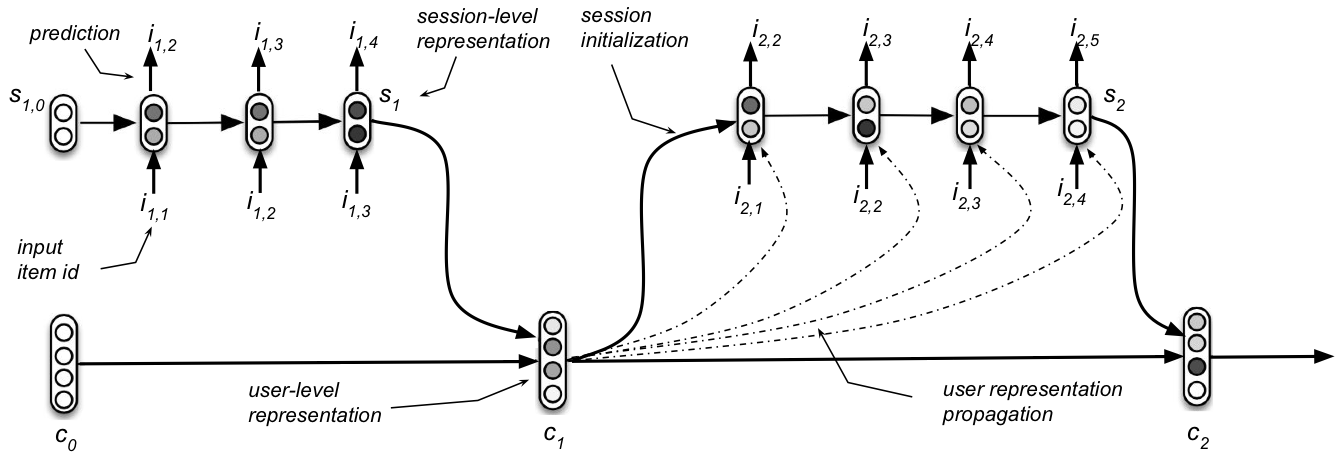

Each user session goes through a _session_ RNN, which models **short-term** user preferences. At the end of each session, the state of the _session_ RNN is used to update a _user_ RNN, which models more **long-term** user preferences. It's state is passed forward to the next _session_ RNN, which can now personalize recommendations depending on both short-term and long-term user interests.

The hyper-parameters of the model are:

* `session_layers`: number of units per layer used at session level.
    It has to be a list of integers for multi-layer networks, or a integer value for single-layer networks.
* `user_layers`: number of units per layer used at user level. Required only by personalized models.
    It has to be a list of integers for multi-layer networks, or a integer value for single-layer networks.
* `batch_size`: the mini-batch size used in training
* `learning_rate`: the learning rate used in training (Adagrad optimized)
* `momentum`: the momentum coefficient used in training
* `dropout`: it's a 3-tuple with the values for the dropout of (user hidden, session hidden, user-to-session hidden) layers.
* `epochs`: number of training epochs
* `personalized`: whether to train a personalized model using the HRNN model (`True` in this case).

**NOTE: HGRU4Rec originally has more hyper-parameters. Going through all of them is out from the scope of this tutorial, but we suggest to check-out the original source code [here](https://github.com/mquad/hgru4rec) in case you are interested.**

In [ ]:
prnnrecommender = RNNRecommender(session_layers=[20], 
                             user_layers=[20],
                             batch_size=16,
                             learning_rate=0.5,
                             momentum=0.1,
                             dropout=(0.1,0.1,0.1),
                             epochs=5,
                             personalized=True)
prnnrecommender.fit(train_data)

2021-04-25 14:02:15,598 - INFO - Converting training data to GRU4Rec format
2021-04-25 14:02:15,633 - INFO - Training started
2021-04-25 14:02:51,671 - INFO - Epoch 0 - train cost: 1.0400
2021-04-25 14:02:52,260 - INFO - Epoch 1 - train cost: 0.9588
2021-04-25 14:02:52,854 - INFO - Epoch 2 - train cost: 0.9023
2021-04-25 14:02:53,433 - INFO - Epoch 3 - train cost: 0.8703
2021-04-25 14:02:54,036 - INFO - Epoch 4 - train cost: 0.8492
2021-04-25 14:02:54,039 - INFO - Training completed


### KNN recommender

The class `KNNRecommender` takes the following initialization hyper-parameters:
- `model`: One among the following KNN models:
    - `iknn`: ItemKNN, item-to-item KNN based on the *last* item in the session to determine the items to be recommended.
    - `sknn`: SessionKNN, compares the *entire* current session with the past sessions in the training data to determine the items to be recommended.
    - `v-sknn`: VMSessionKNN, use linearly decayed real-valued vectors to encode the current session, then compares the current session with the past sessions in the training data using the dot-product to determine the items to be recommended.
    - `s-sknn`: SeqSessionKNN, this variant also puts more weight on elements that appear later in the session by using a custom scoring function (see the paper by Ludewng and Jannach).
    - `sf-sknn`: SeqFilterSessionKNN, this variant also puts more weight on elements that appear later in the session in a more restrictive way by using a custom scoring function (see the paper by Ludewng and Jannach).

- param `init_args`: The model initialization arguments. See the following initializations or check `util.knn` for more details on each model:
    - `iknn`: ItemKNN(n_sims=100, lmbd=20, alpha=0.5)
    - `sknn`: SessionKNN(k, sample_size=500, sampling='recent', similarity='jaccard', remind=False, pop_boost=0)
    - `v-sknn`: VMSessionKNN(k, sample_size=1000, sampling='recent', similarity='cosine', weighting='div',
         dwelling_time=False, last_n_days=None, last_n_clicks=None, extend=False, weighting_score='div_score',
         weighting_time=False, normalize=True)
    - `s-knn`: SeqSessionKNN(k, sample_size=1000, sampling='recent', similarity='jaccard', weighting='div',
        remind=False, pop_boost=0, extend=False, normalize=True)
    - `sf-sknn`: SeqFilterSessionKNN(k, sample_size=1000, sampling='recent', similarity='jaccard', remind=False, pop_boost=0,extend=False, normalize=True)


In [ ]:
#collapse
class ItemKNN:
    '''
    ItemKNN(n_sims = 100, lmbd = 20, alpha = 0.5, session_key = 'SessionId', item_key = 'ItemId', time_key = 'Time')
    
    Item-to-item predictor that computes the the similarity to all items to the given item.
    
    Similarity of two items is given by:
    
    .. math::
        s_{i,j}=\sum_{s}I\{(s,i)\in D & (s,j)\in D\} / (supp_i+\\lambda)^{\\alpha}(supp_j+\\lambda)^{1-\\alpha}
        
    Parameters
    --------
    n_sims : int
        Only give back non-zero scores to the N most similar items. Should be higher or equal than the cut-off of your evaluation. (Default value: 100)
    lmbd : float
        Regularization. Discounts the similarity of rare items (incidental co-occurrences). (Default value: 20)
    alpha : float
        Balance between normalizing with the supports of the two items. 0.5 gives cosine similarity, 1.0 gives confidence (as in association rules).
    session_key : string
        header of the session ID column in the input file (default: 'SessionId')
    item_key : string
        header of the item ID column in the input file (default: 'ItemId')
    time_key : string
        header of the timestamp column in the input file (default: 'Time')
    
    '''

    def __init__(self, n_sims=100, lmbd=20, alpha=0.5, session_key='SessionId', item_key='ItemId', time_key='Time'):
        self.n_sims = n_sims
        self.lmbd = lmbd
        self.alpha = alpha
        self.item_key = item_key
        self.session_key = session_key
        self.time_key = time_key

    def fit(self, data):
        '''
        Trains the predictor.
        
        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
            
        '''
        data.set_index(np.arange(len(data)), inplace=True)
        self.itemids = data[self.item_key].unique()
        n_items = len(self.itemids)
        data = pd.merge(data, pd.DataFrame({self.item_key: self.itemids, 'ItemIdx': np.arange(len(self.itemids))}),
                        on=self.item_key, how='inner')
        sessionids = data[self.session_key].unique()
        data = pd.merge(data, pd.DataFrame({self.session_key: sessionids, 'SessionIdx': np.arange(len(sessionids))}),
                        on=self.session_key, how='inner')
        supp = data.groupby('SessionIdx').size()
        session_offsets = np.zeros(len(supp) + 1, dtype=np.int32)
        session_offsets[1:] = supp.cumsum()
        index_by_sessions = data.sort_values(['SessionIdx', self.time_key]).index.values
        supp = data.groupby('ItemIdx').size()
        item_offsets = np.zeros(n_items + 1, dtype=np.int32)
        item_offsets[1:] = supp.cumsum()
        index_by_items = data.sort_values(['ItemIdx', self.time_key]).index.values
        self.sims = dict()
        for i in range(n_items):
            iarray = np.zeros(n_items)
            start = item_offsets[i]
            end = item_offsets[i + 1]
            for e in index_by_items[start:end]:
                uidx = data.SessionIdx.values[e]
                ustart = session_offsets[uidx]
                uend = session_offsets[uidx + 1]
                user_events = index_by_sessions[ustart:uend]
                iarray[data.ItemIdx.values[user_events]] += 1
            iarray[i] = 0
            norm = np.power((supp[i] + self.lmbd), self.alpha) * np.power((supp.values + self.lmbd), (1.0 - self.alpha))
            norm[norm == 0] = 1
            iarray = iarray / norm
            indices = np.argsort(iarray)[-1:-1 - self.n_sims:-1]
            self.sims[self.itemids[i]] = pd.Series(data=iarray[indices], index=self.itemids[indices])

    def predict_next(self, session_id, input_item_id, predict_for_item_ids=None, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
                
        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event. Must be in the set of item IDs of the training set.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.
            
        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.
        
        '''
        if predict_for_item_ids is None:
            predict_for_item_ids = self.itemids
        preds = np.zeros(len(predict_for_item_ids))
        sim_list = self.sims[input_item_id]
        mask = np.in1d(predict_for_item_ids, sim_list.index)
        preds[mask] = sim_list[predict_for_item_ids[mask]]
        return pd.Series(data=preds, index=predict_for_item_ids)


In [ ]:
#hide
from _operator import itemgetter
from math import sqrt
import random
import time
from math import log10
from datetime import datetime as dt
from datetime import timedelta as td

In [ ]:
#collapse
class SeqFilterSessionKNN:
    '''
    SessionKNN( k, sample_size=500, sampling='recent',  similarity = 'jaccard', remind=False, pop_boost=0, session_key = 'SessionId', item_key= 'ItemId')

    Parameters
    -----------
    k : int
        Number of neighboring session to calculate the item scores from. (Default value: 100)
    sample_size : int
        Defines the length of a subset of all training sessions to calculate the nearest neighbors from. (Default value: 500)
    sampling : string
        String to define the sampling method for sessions (recent, random). (default: recent)
    similarity : string
        String to define the method for the similarity calculation (jaccard, cosine, binary, tanimoto). (default: jaccard)
    remind : bool
        Should the last items of the current session be boosted to the top as reminders
    pop_boost : int
        Push popular items in the neighbor sessions by this factor. (default: 0 to leave out)
    extend : bool
        Add evaluated sessions to the maps
    normalize : bool
        Normalize the scores in the end
    session_key : string
        Header of the session ID column in the input file. (default: 'SessionId')
    item_key : string
        Header of the item ID column in the input file. (default: 'ItemId')
    time_key : string
        Header of the timestamp column in the input file. (default: 'Time')
    '''

    def __init__(self, k, sample_size=1000, sampling='recent', similarity='jaccard', remind=False, pop_boost=0,
                 extend=False, normalize=True, session_key='SessionId', item_key='ItemId', time_key='Time'):

        self.remind = remind
        self.k = k
        self.sample_size = sample_size
        self.sampling = sampling
        self.similarity = similarity
        self.pop_boost = pop_boost
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.extend = extend
        self.normalize = normalize

        # updated while recommending
        self.session = -1
        self.session_items = []
        self.relevant_sessions = set()

        # cache relations once at startup
        self.session_item_map = dict()
        self.item_session_map = dict()
        self.session_time = dict()
        self.followed_by = dict()

        self.sim_time = 0

    def fit(self, train, items=None):
        '''
        Trains the predictor.
        
        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
            
        '''

        index_session = train.columns.get_loc(self.session_key)
        index_item = train.columns.get_loc(self.item_key)
        index_time = train.columns.get_loc(self.time_key)
        self.itemids = train[self.item_key].unique()

        session = -1
        session_items = set()
        last_item = -1
        time = -1
        # cnt = 0
        for row in train.itertuples(index=False):
            # cache items of sessions
            if row[index_session] != session:
                if len(session_items) > 0:
                    self.session_item_map.update({session: session_items})
                    # cache the last time stamp of the session
                    self.session_time.update({session: time})
                session = row[index_session]
                session_items = set()
            else:
                if last_item != -1:  # fill followed by map for filtering of candidate items
                    if not last_item in self.followed_by:
                        self.followed_by[last_item] = set()
                    self.followed_by[last_item].add(row[index_item])

            time = row[index_time]
            session_items.add(row[index_item])

            # cache sessions involving an item
            map_is = self.item_session_map.get(row[index_item])
            if map_is is None:
                map_is = set()
                self.item_session_map.update({row[index_item]: map_is})
            map_is.add(row[index_session])

            last_item = row[index_item]

        # Add the last tuple    
        self.session_item_map.update({session: session_items})
        self.session_time.update({session: time})

    def predict_next(self, session_id, input_item_id, predict_for_item_ids=None, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
                
        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event. Must be in the set of item IDs of the training set.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.
            
        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.
        
        '''

        #         gc.collect()
        #         process = psutil.Process(os.getpid())
        #         print( 'cknn.predict_next: ', process.memory_info().rss, ' memory used')

        if (self.session != session_id):  # new session

            if (self.extend):
                item_set = set(self.session_items)
                self.session_item_map[self.session] = item_set;
                for item in item_set:
                    map_is = self.item_session_map.get(item)
                    if map_is is None:
                        map_is = set()
                        self.item_session_map.update({item: map_is})
                    map_is.add(self.session)

                ts = time.time()
                self.session_time.update({self.session: ts})

                last_item = -1
                for item in self.session_items:
                    if last_item != -1:
                        if not last_item in self.followed_by:
                            self.followed_by[last_item] = set()
                        self.followed_by[last_item].add(item)
                    last_item = item

            self.session = session_id
            self.session_items = list()
            self.relevant_sessions = set()

        if type == 'view':
            self.session_items.append(input_item_id)

        if skip:
            return

        neighbors = self.find_neighbors(set(self.session_items), input_item_id, session_id)
        scores = self.score_items(neighbors, input_item_id)

        # add some reminders
        if self.remind:

            reminderScore = 5
            takeLastN = 3

            cnt = 0
            for elem in self.session_items[-takeLastN:]:
                cnt = cnt + 1
                # reminderScore = reminderScore + (cnt/100)

                oldScore = scores.get(elem)
                newScore = 0
                if oldScore is None:
                    newScore = reminderScore
                else:
                    newScore = oldScore + reminderScore
                # print 'old score ', oldScore
                # update the score and add a small number for the position 
                newScore = (newScore * reminderScore) + (cnt / 100)

                scores.update({elem: newScore})

        # push popular ones
        if self.pop_boost > 0:

            pop = self.item_pop(neighbors)
            # Iterate over the item neighbors
            # print itemScores
            for key in scores:
                item_pop = pop.get(key)
                # Gives some minimal MRR boost?
                scores.update({key: (scores[key] + (self.pop_boost * item_pop))})

        # Create things in the format ..
        if predict_for_item_ids is None:
            predict_for_item_ids = self.itemids
        predictions = np.zeros(len(predict_for_item_ids))
        mask = np.in1d(predict_for_item_ids, list(scores.keys()))

        items = predict_for_item_ids[mask]
        values = [scores[x] for x in items]
        predictions[mask] = values
        series = pd.Series(data=predictions, index=predict_for_item_ids)

        if self.normalize:
            series = series / series.max()

        return series

    def item_pop(self, sessions):
        '''
        Returns a dict(item,score) of the item popularity for the given list of sessions (only a set of ids)
        
        Parameters
        --------
        sessions: set
        
        Returns
        --------
        out : dict            
        '''
        result = dict()
        max_pop = 0
        for session, weight in sessions:
            items = self.items_for_session(session)
            for item in items:

                count = result.get(item)
                if count is None:
                    result.update({item: 1})
                else:
                    result.update({item: count + 1})

                if (result.get(item) > max_pop):
                    max_pop = result.get(item)

        for key in result:
            result.update({key: (result[key] / max_pop)})

        return result

    def jaccard(self, first, second):
        '''
        Calculates the jaccard index for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        sc = time.clock()
        intersection = len(first & second)
        union = len(first | second)
        res = intersection / union

        self.sim_time += (time.clock() - sc)

        return res

    def cosine(self, first, second):
        '''
        Calculates the cosine similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / sqrt(la) * sqrt(lb)

        return result

    def tanimoto(self, first, second):
        '''
        Calculates the cosine tanimoto similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / (la + lb - li)

        return result

    def binary(self, first, second):
        '''
        Calculates the ? for 2 sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        a = len(first & second)
        b = len(first)
        c = len(second)

        result = (2 * a) / ((2 * a) + b + c)

        return result

    def items_for_session(self, session):
        '''
        Returns all items in the session
        
        Parameters
        --------
        session: Id of a session
        
        Returns 
        --------
        out : set           
        '''
        return self.session_item_map.get(session);

    def sessions_for_item(self, item_id):
        '''
        Returns all session for an item
        
        Parameters
        --------
        item: Id of the item session
        
        Returns 
        --------
        out : set           
        '''
        return self.item_session_map.get(item_id)

    def most_recent_sessions(self, sessions, number):
        '''
        Find the most recent sessions in the given set
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''
        sample = set()

        tuples = list()
        for session in sessions:
            time = self.session_time.get(session)
            if time is None:
                print(' EMPTY TIMESTAMP!! ', session)
            tuples.append((session, time))

        tuples = sorted(tuples, key=itemgetter(1), reverse=True)
        # print 'sorted list ', sortedList
        cnt = 0
        for element in tuples:
            cnt = cnt + 1
            if cnt > number:
                break
            sample.add(element[0])
        # print 'returning sample of size ', len(sample)
        return sample

    def possible_neighbor_sessions(self, session_items, input_item_id, session_id):
        '''
        Find a set of session to later on find neighbors in.
        A self.sample_size of 0 uses all sessions in which any item of the current session appears.
        self.sampling can be performed with the options "recent" or "random".
        "recent" selects the self.sample_size most recent sessions while "random" just choses randomly. 
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''

        self.relevant_sessions = self.relevant_sessions | self.sessions_for_item(input_item_id);

        if self.sample_size == 0:  # use all session as possible neighbors

            print('!!!!! runnig KNN without a sample size (check config)')
            return self.relevant_sessions

        else:  # sample some sessions

            self.relevant_sessions = self.relevant_sessions | self.sessions_for_item(input_item_id);

            if len(self.relevant_sessions) > self.sample_size:

                if self.sampling == 'recent':
                    sample = self.most_recent_sessions(self.relevant_sessions, self.sample_size)
                elif self.sampling == 'random':
                    sample = random.sample(self.relevant_sessions, self.sample_size)
                else:
                    sample = self.relevant_sessions[:self.sample_size]

                return sample
            else:
                return self.relevant_sessions

    def calc_similarity(self, session_items, sessions):
        '''
        Calculates the configured similarity for the items in session_items and each session in sessions.
        
        Parameters
        --------
        session_items: set of item ids
        sessions: list of session ids
        
        Returns 
        --------
        out : list of tuple (session_id,similarity)           
        '''

        # print 'nb of sessions to test ', len(sessionsToTest), ' metric: ', self.metric
        neighbors = []
        cnt = 0
        for session in sessions:
            cnt = cnt + 1
            # get items of the session, look up the cache first 
            session_items_test = self.items_for_session(session)

            similarity = getattr(self, self.similarity)(session_items_test, session_items)
            if similarity > 0:
                neighbors.append((session, similarity))

        return neighbors

    # -----------------
    # Find a set of neighbors, returns a list of tuples (sessionid: similarity) 
    # -----------------
    def find_neighbors(self, session_items, input_item_id, session_id):
        '''
        Finds the k nearest neighbors for the given session_id and the current item input_item_id. 
        
        Parameters
        --------
        session_items: set of item ids
        input_item_id: int 
        session_id: int
        
        Returns 
        --------
        out : list of tuple (session_id, similarity)           
        '''
        possible_neighbors = self.possible_neighbor_sessions(session_items, input_item_id, session_id)
        possible_neighbors = self.calc_similarity(session_items, possible_neighbors)

        possible_neighbors = sorted(possible_neighbors, reverse=True, key=lambda x: x[1])
        possible_neighbors = possible_neighbors[:self.k]

        return possible_neighbors

    def score_items(self, neighbors, input_item_id):
        '''
        Compute a set of scores for all items given a set of neighbors.
        
        Parameters
        --------
        neighbors: set of session ids
        
        Returns 
        --------
        out : list of tuple (item, score)           
        '''
        # now we have the set of relevant items to make predictions
        scores = dict()
        # iterate over the sessions
        for session in neighbors:
            # get the items in this session
            items = self.items_for_session(session[0])

            for item in items:

                if input_item_id in self.followed_by and item in self.followed_by[
                    input_item_id]:  # hard filter the candidates

                    old_score = scores.get(item)
                    new_score = session[1]

                    if old_score is None:
                        scores.update({item: new_score})
                    else:
                        new_score = old_score + new_score
                        scores.update({item: new_score})

        return scores


In [ ]:
#collapse
class VMSessionKNN:
    '''
    VMSessionKNN( k, sample_size=1000, sampling='recent', similarity='cosine', weighting='div', dwelling_time=False, last_n_days=None, last_n_clicks=None, extend=False, weighting_score='div_score', weighting_time=False, normalize=True, session_key = 'SessionId', item_key= 'ItemId', time_key= 'Time')

    Parameters
    -----------
    k : int
        Number of neighboring session to calculate the item scores from. (Default value: 100)
    sample_size : int
        Defines the length of a subset of all training sessions to calculate the nearest neighbors from. (Default value: 500)
    sampling : string
        String to define the sampling method for sessions (recent, random). (default: recent)
    similarity : string
        String to define the method for the similarity calculation (jaccard, cosine, binary, tanimoto). (default: jaccard)
    weighting : string
        Decay function to determine the importance/weight of individual actions in the current session (linear, same, div, log, quadratic). (default: div)
    weighting_score : string
        Decay function to lower the score of candidate items from a neighboring sessions that were selected by less recently clicked items in the current session. (linear, same, div, log, quadratic). (default: div_score)
    weighting_time : boolean
        Experimental function to give less weight to items from older sessions (default: False)
    dwelling_time : boolean
        Experimental function to use the dwelling time for item view actions as a weight in the similarity calculation. (default: False)
    last_n_days : int
        Use only data from the last N days. (default: None)
    last_n_clicks : int
        Use only the last N clicks of the current session when recommending. (default: None)
    extend : bool
        Add evaluated sessions to the maps.
    normalize : bool
        Normalize the scores in the end.
    session_key : string
        Header of the session ID column in the input file. (default: 'SessionId')
    item_key : string
        Header of the item ID column in the input file. (default: 'ItemId')
    time_key : string
        Header of the timestamp column in the input file. (default: 'Time')
    '''

    def __init__(self, k, sample_size=1000, sampling='recent', similarity='cosine', weighting='div',
                 dwelling_time=False, last_n_days=None, last_n_clicks=None, extend=False, weighting_score='div_score',
                 weighting_time=False, normalize=True, session_key='SessionId', item_key='ItemId', time_key='Time'):

        self.k = k
        self.sample_size = sample_size
        self.sampling = sampling
        self.weighting = weighting
        self.dwelling_time = dwelling_time
        self.weighting_score = weighting_score
        self.weighting_time = weighting_time
        self.similarity = similarity
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.extend = extend
        self.normalize = normalize
        self.last_n_days = last_n_days
        self.last_n_clicks = last_n_clicks

        # updated while recommending
        self.session = -1
        self.session_items = []
        self.relevant_sessions = set()

        # cache relations once at startup
        self.session_item_map = dict()
        self.item_session_map = dict()
        self.session_time = dict()
        self.min_time = -1

        self.sim_time = 0

    def fit(self, data, items=None):
        '''
        Trains the predictor.
        
        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
            
        '''

        if self.last_n_days != None:

            max_time = dt.fromtimestamp(data[self.time_key].max())
            date_threshold = max_time.date() - td(self.last_n_days)
            stamp = dt.combine(date_threshold, dt.min.time()).timestamp()
            train = data[data[self.time_key] >= stamp]

        else:
            train = data

        self.num_items = train[self.item_key].max()

        index_session = train.columns.get_loc(self.session_key)
        index_item = train.columns.get_loc(self.item_key)
        index_time = train.columns.get_loc(self.time_key)
        self.itemids = train[self.item_key].unique()

        session = -1
        session_items = set()
        time = -1
        # cnt = 0
        for row in train.itertuples(index=False):
            # cache items of sessions
            if row[index_session] != session:
                if len(session_items) > 0:
                    self.session_item_map.update({session: session_items})
                    # cache the last time stamp of the session
                    self.session_time.update({session: time})
                    if time < self.min_time:
                        self.min_time = time
                session = row[index_session]
                session_items = set()
            time = row[index_time]
            session_items.add(row[index_item])

            # cache sessions involving an item
            map_is = self.item_session_map.get(row[index_item])
            if map_is is None:
                map_is = set()
                self.item_session_map.update({row[index_item]: map_is})
            map_is.add(row[index_session])

        # Add the last tuple    
        self.session_item_map.update({session: session_items})
        self.session_time.update({session: time})

    def predict_next(self, session_id, input_item_id, predict_for_item_ids=None, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
                
        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event. Must be in the set of item IDs of the training set.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.
            
        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.
        
        '''

        #         gc.collect()
        #         process = psutil.Process(os.getpid())
        #         print( 'cknn.predict_next: ', process.memory_info().rss, ' memory used')

        if (self.session != session_id):  # new session

            if (self.extend):
                item_set = set(self.session_items)
                self.session_item_map[self.session] = item_set;
                for item in item_set:
                    map_is = self.item_session_map.get(item)
                    if map_is is None:
                        map_is = set()
                        self.item_session_map.update({item: map_is})
                    map_is.add(self.session)

                ts = time.time()
                self.session_time.update({self.session: ts})

            self.last_ts = -1
            self.session = session_id
            self.session_items = list()
            self.dwelling_times = list()
            self.relevant_sessions = set()

        if type == 'view':
            self.session_items.append(input_item_id)
            if self.dwelling_time:
                if self.last_ts > 0:
                    self.dwelling_times.append(timestamp - self.last_ts)
                self.last_ts = timestamp

        if skip:
            return

        items = self.session_items if self.last_n_clicks is None else self.session_items[-self.last_n_clicks:]
        neighbors = self.find_neighbors(items, input_item_id, session_id, self.dwelling_times, timestamp)
        scores = self.score_items(neighbors, items, timestamp)

        # Create things in the format ..
        if predict_for_item_ids is None:
            predict_for_item_ids = self.itemids
        predictions = np.zeros(len(predict_for_item_ids))
        mask = np.in1d(predict_for_item_ids, list(scores.keys()))

        items = predict_for_item_ids[mask]
        values = [scores[x] for x in items]
        predictions[mask] = values
        series = pd.Series(data=predictions, index=predict_for_item_ids)

        if self.normalize:
            series = series / series.max()

        return series

    def item_pop(self, sessions):
        '''
        Returns a dict(item,score) of the item popularity for the given list of sessions (only a set of ids)
        
        Parameters
        --------
        sessions: set
        
        Returns
        --------
        out : dict            
        '''
        result = dict()
        max_pop = 0
        for session, weight in sessions:
            items = self.items_for_session(session)
            for item in items:

                count = result.get(item)
                if count is None:
                    result.update({item: 1})
                else:
                    result.update({item: count + 1})

                if (result.get(item) > max_pop):
                    max_pop = result.get(item)

        for key in result:
            result.update({key: (result[key] / max_pop)})

        return result

    def jaccard(self, first, second):
        '''
        Calculates the jaccard index for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        sc = time.clock()
        intersection = len(first & second)
        union = len(first | second)
        res = intersection / union

        self.sim_time += (time.clock() - sc)

        return res

    def cosine(self, first, second):
        '''
        Calculates the cosine similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / sqrt(la) * sqrt(lb)

        return result

    def tanimoto(self, first, second):
        '''
        Calculates the cosine tanimoto similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / (la + lb - li)

        return result

    def binary(self, first, second):
        '''
        Calculates the ? for 2 sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        a = len(first & second)
        b = len(first)
        c = len(second)

        result = (2 * a) / ((2 * a) + b + c)

        return result

    def vec(self, first, second, map):
        '''
        Calculates the ? for 2 sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        a = first & second
        sum = 0
        for i in a:
            sum += map[i]

        result = sum / len(map)

        return result

    def items_for_session(self, session):
        '''
        Returns all items in the session
        
        Parameters
        --------
        session: Id of a session
        
        Returns 
        --------
        out : set           
        '''
        return self.session_item_map.get(session);

    def vec_for_session(self, session):
        '''
        Returns all items in the session
        
        Parameters
        --------
        session: Id of a session
        
        Returns 
        --------
        out : set           
        '''
        return self.session_vec_map.get(session);

    def sessions_for_item(self, item_id):
        '''
        Returns all session for an item
        
        Parameters
        --------
        item: Id of the item session
        
        Returns 
        --------
        out : set           
        '''
        return self.item_session_map.get(item_id) if item_id in self.item_session_map else set()

    def most_recent_sessions(self, sessions, number):
        '''
        Find the most recent sessions in the given set
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''
        sample = set()

        tuples = list()
        for session in sessions:
            time = self.session_time.get(session)
            if time is None:
                print(' EMPTY TIMESTAMP!! ', session)
            tuples.append((session, time))

        tuples = sorted(tuples, key=itemgetter(1), reverse=True)
        # print 'sorted list ', sortedList
        cnt = 0
        for element in tuples:
            cnt = cnt + 1
            if cnt > number:
                break
            sample.add(element[0])
        # print 'returning sample of size ', len(sample)
        return sample

    def possible_neighbor_sessions(self, session_items, input_item_id, session_id):
        '''
        Find a set of session to later on find neighbors in.
        A self.sample_size of 0 uses all sessions in which any item of the current session appears.
        self.sampling can be performed with the options "recent" or "random".
        "recent" selects the self.sample_size most recent sessions while "random" just choses randomly. 
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''

        self.relevant_sessions = self.relevant_sessions | self.sessions_for_item(input_item_id)

        if self.sample_size == 0:  # use all session as possible neighbors

            print('!!!!! runnig KNN without a sample size (check config)')
            return self.relevant_sessions

        else:  # sample some sessions

            if len(self.relevant_sessions) > self.sample_size:

                if self.sampling == 'recent':
                    sample = self.most_recent_sessions(self.relevant_sessions, self.sample_size)
                elif self.sampling == 'random':
                    sample = random.sample(self.relevant_sessions, self.sample_size)
                else:
                    sample = self.relevant_sessions[:self.sample_size]

                return sample
            else:
                return self.relevant_sessions

    def calc_similarity(self, session_items, sessions, dwelling_times, timestamp):
        '''
        Calculates the configured similarity for the items in session_items and each session in sessions.
        
        Parameters
        --------
        session_items: set of item ids
        sessions: list of session ids
        
        Returns 
        --------
        out : list of tuple (session_id,similarity)           
        '''

        pos_map = {}
        length = len(session_items)

        count = 1
        for item in session_items:
            if self.weighting is not None:
                pos_map[item] = getattr(self, self.weighting)(count, length)
                count += 1
            else:
                pos_map[item] = 1

        dt = dwelling_times.copy()
        dt.append(0)
        dt = pd.Series(dt, index=session_items)
        dt = dt / dt.max()
        # dt[session_items[-1]] = dt.mean() if len(session_items) > 1 else 1
        dt[session_items[-1]] = 1

        if self.dwelling_time:
            # print(dt)
            for i in range(len(dt)):
                pos_map[session_items[i]] *= dt.iloc[i]
            # print(pos_map)
        # print 'nb of sessions to test ', len(sessionsToTest), ' metric: ', self.metric
        items = set(session_items)
        neighbors = []
        cnt = 0
        for session in sessions:
            cnt = cnt + 1
            # get items of the session, look up the cache first 
            n_items = self.items_for_session(session)
            sts = self.session_time[session]

            similarity = self.vec(items, n_items, pos_map)
            if similarity > 0:

                if self.weighting_time:
                    diff = timestamp - sts
                    days = round(diff / 60 / 60 / 24)
                    decay = pow(7 / 8, days)
                    similarity *= decay

                # print("days:",days," => ",decay)

                neighbors.append((session, similarity))

        return neighbors

    # -----------------
    # Find a set of neighbors, returns a list of tuples (sessionid: similarity) 
    # -----------------
    def find_neighbors(self, session_items, input_item_id, session_id, dwelling_times, timestamp):
        '''
        Finds the k nearest neighbors for the given session_id and the current item input_item_id. 
        
        Parameters
        --------
        session_items: set of item ids
        input_item_id: int 
        session_id: int
        
        Returns 
        --------
        out : list of tuple (session_id, similarity)           
        '''
        possible_neighbors = self.possible_neighbor_sessions(session_items, input_item_id, session_id)
        possible_neighbors = self.calc_similarity(session_items, possible_neighbors, dwelling_times, timestamp)

        possible_neighbors = sorted(possible_neighbors, reverse=True, key=lambda x: x[1])
        possible_neighbors = possible_neighbors[:self.k]

        return possible_neighbors

    def score_items(self, neighbors, current_session, timestamp):
        '''
        Compute a set of scores for all items given a set of neighbors.
        
        Parameters
        --------
        neighbors: set of session ids
        
        Returns 
        --------
        out : list of tuple (item, score)           
        '''
        # now we have the set of relevant items to make predictions
        scores = dict()
        # iterate over the sessions
        for session in neighbors:
            # get the items in this session
            items = self.items_for_session(session[0])
            step = 1

            for item in reversed(current_session):
                if item in items:
                    decay = getattr(self, self.weighting_score)(step)
                    break
                step += 1

            for item in items:
                old_score = scores.get(item)
                similarity = session[1]

                if old_score is None:
                    scores.update({item: (similarity * decay)})
                else:
                    new_score = old_score + (similarity * decay)
                    scores.update({item: new_score})

        return scores

    def linear_score(self, i):
        return 1 - (0.1 * i) if i <= 100 else 0

    def same_score(self, i):
        return 1

    def div_score(self, i):
        return 1 / i

    def log_score(self, i):
        return 1 / (log10(i + 1.7))

    def quadratic_score(self, i):
        return 1 / (i * i)

    def linear(self, i, length):
        return 1 - (0.1 * (length - i)) if i <= 10 else 0

    def same(self, i, length):
        return 1

    def div(self, i, length):
        return i / length

    def log(self, i, length):
        return 1 / (log10((length - i) + 1.7))

    def quadratic(self, i, length):
        return (i / length) ** 2


In [ ]:
#collapse
class SessionKNN:
    '''
    SessionKNN( k, sample_size=500, sampling='recent',  similarity = 'jaccard', remind=False, pop_boost=0, session_key = 'SessionId', item_key= 'ItemId')

    Parameters
    -----------
    k : int
        Number of neighboring session to calculate the item scores from. (Default value: 100)
    sample_size : int
        Defines the length of a subset of all training sessions to calculate the nearest neighbors from. (Default value: 500)
    sampling : string
        String to define the sampling method for sessions (recent, random). (default: recent)
    similarity : string
        String to define the method for the similarity calculation (jaccard, cosine, binary, tanimoto). (default: jaccard)
    remind : bool
        Should the last items of the current session be boosted to the top as reminders
    pop_boost : int
        Push popular items in the neighbor sessions by this factor. (default: 0 to leave out)
    extend : bool
        Add evaluated sessions to the maps
    normalize : bool
        Normalize the scores in the end
    session_key : string
        Header of the session ID column in the input file. (default: 'SessionId')
    item_key : string
        Header of the item ID column in the input file. (default: 'ItemId')
    time_key : string
        Header of the timestamp column in the input file. (default: 'Time')
    '''

    def __init__(self, k, sample_size=1000, sampling='recent', similarity='jaccard', remind=False, pop_boost=0,
                 extend=False, normalize=True, session_key='SessionId', item_key='ItemId', time_key='Time'):

        self.remind = remind
        self.k = k
        self.sample_size = sample_size
        self.sampling = sampling
        self.similarity = similarity
        self.pop_boost = pop_boost
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.extend = extend
        self.normalize = normalize

        # updated while recommending
        self.session = -1
        self.session_items = []
        self.relevant_sessions = set()

        # cache relations once at startup
        self.session_item_map = dict()
        self.item_session_map = dict()
        self.session_time = dict()

        self.sim_time = 0

    def fit(self, train):
        '''
        Trains the predictor.
        
        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
            
        '''

        index_session = train.columns.get_loc(self.session_key)
        index_item = train.columns.get_loc(self.item_key)
        index_time = train.columns.get_loc(self.time_key)
        self.itemids = train[self.item_key].unique()

        session = -1
        session_items = set()
        time = -1
        # cnt = 0
        for row in train.itertuples(index=False):
            # cache items of sessions
            if row[index_session] != session:
                if len(session_items) > 0:
                    self.session_item_map.update({session: session_items})
                    # cache the last time stamp of the session
                    self.session_time.update({session: time})
                session = row[index_session]
                session_items = set()
            time = row[index_time]
            session_items.add(row[index_item])

            # cache sessions involving an item
            map_is = self.item_session_map.get(row[index_item])
            if map_is is None:
                map_is = set()
                self.item_session_map.update({row[index_item]: map_is})
            map_is.add(row[index_session])

        # Add the last tuple    
        self.session_item_map.update({session: session_items})
        self.session_time.update({session: time})

    def predict_next(self, session_id, input_item_id, predict_for_item_ids=None, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
                
        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event. Must be in the set of item IDs of the training set.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.
            
        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.
        
        '''

        #         gc.collect()
        #         process = psutil.Process(os.getpid())
        #         print( 'cknn.predict_next: ', process.memory_info().rss, ' memory used')

        if (self.session != session_id):  # new session

            if (self.extend):
                item_set = set(self.session_items)
                self.session_item_map[self.session] = item_set;
                for item in item_set:
                    map_is = self.item_session_map.get(item)
                    if map_is is None:
                        map_is = set()
                        self.item_session_map.update({item: map_is})
                    map_is.add(self.session)

                ts = time.time()
                self.session_time.update({self.session: ts})

            self.session = session_id
            self.session_items = list()
            self.relevant_sessions = set()

        if type == 'view':
            self.session_items.append(input_item_id)

        if skip:
            return

        neighbors = self.find_neighbors(set(self.session_items), input_item_id, session_id)
        scores = self.score_items(neighbors)

        # add some reminders
        if self.remind:

            reminderScore = 5
            takeLastN = 3

            cnt = 0
            for elem in self.session_items[-takeLastN:]:
                cnt = cnt + 1
                # reminderScore = reminderScore + (cnt/100)

                oldScore = scores.get(elem)
                newScore = 0
                if oldScore is None:
                    newScore = reminderScore
                else:
                    newScore = oldScore + reminderScore
                # print 'old score ', oldScore
                # update the score and add a small number for the position 
                newScore = (newScore * reminderScore) + (cnt / 100)

                scores.update({elem: newScore})

        # push popular ones
        if self.pop_boost > 0:

            pop = self.item_pop(neighbors)
            # Iterate over the item neighbors
            # print itemScores
            for key in scores:
                item_pop = pop.get(key)
                # Gives some minimal MRR boost?
                scores.update({key: (scores[key] + (self.pop_boost * item_pop))})

        # Create things in the format ..
        if predict_for_item_ids is None:
            predict_for_item_ids = self.itemids
        predictions = np.zeros(len(predict_for_item_ids))
        mask = np.in1d(predict_for_item_ids, list(scores.keys()))

        items = predict_for_item_ids[mask]
        values = [scores[x] for x in items]
        predictions[mask] = values
        series = pd.Series(data=predictions, index=predict_for_item_ids)

        if self.normalize:
            series = series / series.max()

        return series

    def item_pop(self, sessions):
        '''
        Returns a dict(item,score) of the item popularity for the given list of sessions (only a set of ids)
        
        Parameters
        --------
        sessions: set
        
        Returns
        --------
        out : dict            
        '''
        result = dict()
        max_pop = 0
        for session, weight in sessions:
            items = self.items_for_session(session)
            for item in items:

                count = result.get(item)
                if count is None:
                    result.update({item: 1})
                else:
                    result.update({item: count + 1})

                if (result.get(item) > max_pop):
                    max_pop = result.get(item)

        for key in result:
            result.update({key: (result[key] / max_pop)})

        return result

    def jaccard(self, first, second):
        '''
        Calculates the jaccard index for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        sc = time.clock()
        intersection = len(first & second)
        union = len(first | second)
        res = intersection / union

        self.sim_time += (time.clock() - sc)

        return res

    def cosine(self, first, second):
        '''
        Calculates the cosine similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / sqrt(la) * sqrt(lb)

        return result

    def tanimoto(self, first, second):
        '''
        Calculates the cosine tanimoto similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / (la + lb - li)

        return result

    def binary(self, first, second):
        '''
        Calculates the ? for 2 sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        a = len(first & second)
        b = len(first)
        c = len(second)

        result = (2 * a) / ((2 * a) + b + c)

        return result

    def random(self, first, second):
        '''
        Calculates the ? for 2 sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        return random.random()

    def items_for_session(self, session):
        '''
        Returns all items in the session
        
        Parameters
        --------
        session: Id of a session
        
        Returns 
        --------
        out : set           
        '''
        return self.session_item_map.get(session);

    def sessions_for_item(self, item_id):
        '''
        Returns all session for an item
        
        Parameters
        --------
        item: Id of the item session
        
        Returns 
        --------
        out : set           
        '''
        return self.item_session_map.get(item_id)

    def most_recent_sessions(self, sessions, number):
        '''
        Find the most recent sessions in the given set
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''
        sample = set()

        tuples = list()
        for session in sessions:
            time = self.session_time.get(session)
            if time is None:
                print(' EMPTY TIMESTAMP!! ', session)
            tuples.append((session, time))

        tuples = sorted(tuples, key=itemgetter(1), reverse=True)
        # print 'sorted list ', sortedList
        cnt = 0
        for element in tuples:
            cnt = cnt + 1
            if cnt > number:
                break
            sample.add(element[0])
        # print 'returning sample of size ', len(sample)
        return sample

    def possible_neighbor_sessions(self, session_items, input_item_id, session_id):
        '''
        Find a set of session to later on find neighbors in.
        A self.sample_size of 0 uses all sessions in which any item of the current session appears.
        self.sampling can be performed with the options "recent" or "random".
        "recent" selects the self.sample_size most recent sessions while "random" just choses randomly. 
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''

        self.relevant_sessions = self.relevant_sessions | self.sessions_for_item(input_item_id);

        if self.sample_size == 0:  # use all session as possible neighbors

            print('!!!!! runnig KNN without a sample size (check config)')
            return self.relevant_sessions

        else:  # sample some sessions

            self.relevant_sessions = self.relevant_sessions | self.sessions_for_item(input_item_id);

            if len(self.relevant_sessions) > self.sample_size:

                if self.sampling == 'recent':
                    sample = self.most_recent_sessions(self.relevant_sessions, self.sample_size)
                elif self.sampling == 'random':
                    sample = random.sample(self.relevant_sessions, self.sample_size)
                else:
                    sample = self.relevant_sessions[:self.sample_size]

                return sample
            else:
                return self.relevant_sessions

    def calc_similarity(self, session_items, sessions):
        '''
        Calculates the configured similarity for the items in session_items and each session in sessions.
        
        Parameters
        --------
        session_items: set of item ids
        sessions: list of session ids
        
        Returns 
        --------
        out : list of tuple (session_id,similarity)           
        '''

        # print 'nb of sessions to test ', len(sessionsToTest), ' metric: ', self.metric
        neighbors = []
        cnt = 0
        for session in sessions:
            cnt = cnt + 1
            # get items of the session, look up the cache first 
            session_items_test = self.items_for_session(session)

            similarity = getattr(self, self.similarity)(session_items_test, session_items)
            if similarity > 0:
                neighbors.append((session, similarity))

        return neighbors

    # -----------------
    # Find a set of neighbors, returns a list of tuples (sessionid: similarity) 
    # -----------------
    def find_neighbors(self, session_items, input_item_id, session_id):
        '''
        Finds the k nearest neighbors for the given session_id and the current item input_item_id. 
        
        Parameters
        --------
        session_items: set of item ids
        input_item_id: int 
        session_id: int
        
        Returns 
        --------
        out : list of tuple (session_id, similarity)           
        '''
        possible_neighbors = self.possible_neighbor_sessions(session_items, input_item_id, session_id)
        possible_neighbors = self.calc_similarity(session_items, possible_neighbors)

        possible_neighbors = sorted(possible_neighbors, reverse=True, key=lambda x: x[1])
        possible_neighbors = possible_neighbors[:self.k]

        return possible_neighbors

    def score_items(self, neighbors):
        '''
        Compute a set of scores for all items given a set of neighbors.
        
        Parameters
        --------
        neighbors: set of session ids
        
        Returns 
        --------
        out : list of tuple (item, score)           
        '''
        # now we have the set of relevant items to make predictions
        scores = dict()
        # iterate over the sessions
        for session in neighbors:
            # get the items in this session
            items = self.items_for_session(session[0])

            for item in items:
                old_score = scores.get(item)
                new_score = session[1]

                if old_score is None:
                    scores.update({item: new_score})
                else:
                    new_score = old_score + new_score
                    scores.update({item: new_score})

        return scores


In [ ]:
#collapse
class SeqSessionKNN:
    '''
    SeqSessionKNN( k, sample_size=500, sampling='recent',  similarity = 'jaccard', remind=False, pop_boost=0, session_key = 'SessionId', item_key= 'ItemId')

    Parameters
    -----------
    k : int
        Number of neighboring session to calculate the item scores from. (Default value: 100)
    sample_size : int
        Defines the length of a subset of all training sessions to calculate the nearest neighbors from. (Default value: 500)
    sampling : string
        String to define the sampling method for sessions (recent, random). (default: recent)
    similarity : string
        String to define the method for the similarity calculation (jaccard, cosine, binary, tanimoto). (default: jaccard)
    remind : bool
        Should the last items of the current session be boosted to the top as reminders
    pop_boost : int
        Push popular items in the neighbor sessions by this factor. (default: 0 to leave out)
    extend : bool
        Add evaluated sessions to the maps
    normalize : bool
        Normalize the scores in the end
    session_key : string
        Header of the session ID column in the input file. (default: 'SessionId')
    item_key : string
        Header of the item ID column in the input file. (default: 'ItemId')
    time_key : string
        Header of the timestamp column in the input file. (default: 'Time')
    '''

    def __init__(self, k, sample_size=1000, sampling='recent', similarity='jaccard', weighting='div', remind=False,
                 pop_boost=0, extend=False, normalize=True, session_key='SessionId', item_key='ItemId',
                 time_key='Time'):

        self.remind = remind
        self.k = k
        self.sample_size = sample_size
        self.sampling = sampling
        self.weighting = weighting
        self.similarity = similarity
        self.pop_boost = pop_boost
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.extend = extend
        self.normalize = normalize

        # updated while recommending
        self.session = -1
        self.session_items = []
        self.relevant_sessions = set()

        # cache relations once at startup
        self.session_item_map = dict()
        self.item_session_map = dict()
        self.session_time = dict()

        self.sim_time = 0

    def fit(self, train, items=None):
        '''
        Trains the predictor.
        
        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
            
        '''

        index_session = train.columns.get_loc(self.session_key)
        index_item = train.columns.get_loc(self.item_key)
        index_time = train.columns.get_loc(self.time_key)
        self.itemids = train[self.item_key].unique()

        session = -1
        session_items = set()
        time = -1
        # cnt = 0
        for row in train.itertuples(index=False):
            # cache items of sessions
            if row[index_session] != session:
                if len(session_items) > 0:
                    self.session_item_map.update({session: session_items})
                    # cache the last time stamp of the session
                    self.session_time.update({session: time})
                session = row[index_session]
                session_items = set()
            time = row[index_time]
            session_items.add(row[index_item])

            # cache sessions involving an item
            map_is = self.item_session_map.get(row[index_item])
            if map_is is None:
                map_is = set()
                self.item_session_map.update({row[index_item]: map_is})
            map_is.add(row[index_session])

        # Add the last tuple    
        self.session_item_map.update({session: session_items})
        self.session_time.update({session: time})

    def predict_next(self, session_id, input_item_id, predict_for_item_ids=None, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
                
        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event. Must be in the set of item IDs of the training set.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.
            
        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.
        
        '''

        #         gc.collect()
        #         process = psutil.Process(os.getpid())
        #         print( 'cknn.predict_next: ', process.memory_info().rss, ' memory used')

        if (self.session != session_id):  # new session

            if (self.extend):
                item_set = set(self.session_items)
                self.session_item_map[self.session] = item_set
                for item in item_set:
                    map_is = self.item_session_map.get(item)
                    if map_is is None:
                        map_is = set()
                        self.item_session_map.update({item: map_is})
                    map_is.add(self.session)

                ts = time.time()
                self.session_time.update({self.session: ts})

            self.session = session_id
            self.session_items = list()
            self.relevant_sessions = set()

        if type == 'view':
            self.session_items.append(input_item_id)

        if skip:
            return

        neighbors = self.find_neighbors(set(self.session_items), input_item_id, session_id)
        scores = self.score_items(neighbors, self.session_items)

        # add some reminders
        if self.remind:

            reminderScore = 5
            takeLastN = 3

            cnt = 0
            for elem in self.session_items[-takeLastN:]:
                cnt = cnt + 1
                # reminderScore = reminderScore + (cnt/100)

                oldScore = scores.get(elem)
                newScore = 0
                if oldScore is None:
                    newScore = reminderScore
                else:
                    newScore = oldScore + reminderScore
                # print 'old score ', oldScore
                # update the score and add a small number for the position 
                newScore = (newScore * reminderScore) + (cnt / 100)

                scores.update({elem: newScore})

        # push popular ones
        if self.pop_boost > 0:

            pop = self.item_pop(neighbors)
            # Iterate over the item neighbors
            # print itemScores
            for key in scores:
                item_pop = pop.get(key)
                # Gives some minimal MRR boost?
                scores.update({key: (scores[key] + (self.pop_boost * item_pop))})

        # Create things in the format ..
        if predict_for_item_ids is None:
            predict_for_item_ids = self.itemids
        predictions = np.zeros(len(predict_for_item_ids))
        mask = np.in1d(predict_for_item_ids, list(scores.keys()))

        items = predict_for_item_ids[mask]
        values = [scores[x] for x in items]
        predictions[mask] = values
        series = pd.Series(data=predictions, index=predict_for_item_ids)

        if self.normalize:
            series = series / series.max()

        return series

    def item_pop(self, sessions):
        '''
        Returns a dict(item,score) of the item popularity for the given list of sessions (only a set of ids)
        
        Parameters
        --------
        sessions: set
        
        Returns
        --------
        out : dict            
        '''
        result = dict()
        max_pop = 0
        for session, weight in sessions:
            items = self.items_for_session(session)
            for item in items:

                count = result.get(item)
                if count is None:
                    result.update({item: 1})
                else:
                    result.update({item: count + 1})

                if (result.get(item) > max_pop):
                    max_pop = result.get(item)

        for key in result:
            result.update({key: (result[key] / max_pop)})

        return result

    def jaccard(self, first, second):
        '''
        Calculates the jaccard index for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        sc = time.clock()
        intersection = len(first & second)
        union = len(first | second)
        res = intersection / union

        self.sim_time += (time.clock() - sc)

        return res

    def cosine(self, first, second):
        '''
        Calculates the cosine similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / sqrt(la) * sqrt(lb)

        return result

    def tanimoto(self, first, second):
        '''
        Calculates the cosine tanimoto similarity for two sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        li = len(first & second)
        la = len(first)
        lb = len(second)
        result = li / (la + lb - li)

        return result

    def binary(self, first, second):
        '''
        Calculates the ? for 2 sessions
        
        Parameters
        --------
        first: Id of a session
        second: Id of a session
        
        Returns 
        --------
        out : float value           
        '''
        a = len(first & second)
        b = len(first)
        c = len(second)

        result = (2 * a) / ((2 * a) + b + c)

        return result

    def items_for_session(self, session):
        '''
        Returns all items in the session
        
        Parameters
        --------
        session: Id of a session
        
        Returns 
        --------
        out : set           
        '''
        return self.session_item_map.get(session);

    def sessions_for_item(self, item_id):
        '''
        Returns all session for an item
        
        Parameters
        --------
        item: Id of the item session
        
        Returns 
        --------
        out : set           
        '''
        return self.item_session_map.get(item_id)

    def most_recent_sessions(self, sessions, number):
        '''
        Find the most recent sessions in the given set
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''
        sample = set()

        tuples = list()
        for session in sessions:
            time = self.session_time.get(session)
            if time is None:
                print(' EMPTY TIMESTAMP!! ', session)
            tuples.append((session, time))

        tuples = sorted(tuples, key=itemgetter(1), reverse=True)
        # print 'sorted list ', sortedList
        cnt = 0
        for element in tuples:
            cnt = cnt + 1
            if cnt > number:
                break
            sample.add(element[0])
        # print 'returning sample of size ', len(sample)
        return sample

    def possible_neighbor_sessions(self, session_items, input_item_id, session_id):
        '''
        Find a set of session to later on find neighbors in.
        A self.sample_size of 0 uses all sessions in which any item of the current session appears.
        self.sampling can be performed with the options "recent" or "random".
        "recent" selects the self.sample_size most recent sessions while "random" just choses randomly. 
        
        Parameters
        --------
        sessions: set of session ids
        
        Returns 
        --------
        out : set           
        '''

        self.relevant_sessions = self.relevant_sessions | self.sessions_for_item(input_item_id);

        if self.sample_size == 0:  # use all session as possible neighbors

            print('!!!!! runnig KNN without a sample size (check config)')
            return self.relevant_sessions

        else:  # sample some sessions

            if len(self.relevant_sessions) > self.sample_size:

                if self.sampling == 'recent':
                    sample = self.most_recent_sessions(self.relevant_sessions, self.sample_size)
                elif self.sampling == 'random':
                    sample = random.sample(self.relevant_sessions, self.sample_size)
                else:
                    sample = self.relevant_sessions[:self.sample_size]

                return sample
            else:
                return self.relevant_sessions

    def calc_similarity(self, session_items, sessions):
        '''
        Calculates the configured similarity for the items in session_items and each session in sessions.
        
        Parameters
        --------
        session_items: set of item ids
        sessions: list of session ids
        
        Returns 
        --------
        out : list of tuple (session_id,similarity)           
        '''

        # print 'nb of sessions to test ', len(sessionsToTest), ' metric: ', self.metric
        neighbors = []
        cnt = 0
        for session in sessions:
            cnt = cnt + 1
            # get items of the session, look up the cache first 
            session_items_test = self.items_for_session(session)

            similarity = getattr(self, self.similarity)(session_items_test, session_items)
            if similarity > 0:
                neighbors.append((session, similarity))

        return neighbors

    # -----------------
    # Find a set of neighbors, returns a list of tuples (sessionid: similarity) 
    # -----------------
    def find_neighbors(self, session_items, input_item_id, session_id):
        '''
        Finds the k nearest neighbors for the given session_id and the current item input_item_id. 
        
        Parameters
        --------
        session_items: set of item ids
        input_item_id: int 
        session_id: int
        
        Returns 
        --------
        out : list of tuple (session_id, similarity)           
        '''
        possible_neighbors = self.possible_neighbor_sessions(session_items, input_item_id, session_id)
        possible_neighbors = self.calc_similarity(session_items, possible_neighbors)

        possible_neighbors = sorted(possible_neighbors, reverse=True, key=lambda x: x[1])
        possible_neighbors = possible_neighbors[:self.k]

        return possible_neighbors

    def score_items(self, neighbors, current_session):
        '''
        Compute a set of scores for all items given a set of neighbors.
        
        Parameters
        --------
        neighbors: set of session ids
        
        Returns 
        --------
        out : list of tuple (item, score)           
        '''
        # now we have the set of relevant items to make predictions
        scores = dict()
        # iterate over the sessions
        for session in neighbors:
            # get the items in this session
            items = self.items_for_session(session[0])
            step = 1

            for item in reversed(current_session):
                if item in items:
                    decay = getattr(self, self.weighting)(step)
                    break
                step += 1

            for item in items:
                old_score = scores.get(item)
                similarity = session[1]

                if old_score is None:
                    scores.update({item: (similarity * decay)})
                else:
                    new_score = old_score + (similarity * decay)
                    scores.update({item: new_score})

        return scores

    def linear(self, i):
        return 1 - (0.1 * i) if i <= 100 else 0

    def same(self, i):
        return 1

    def div(self, i):
        return 1 / i

    def log(self, i):
        return 1 / (log10(i + 1.7))

    def quadratic(self, i):
        return 1 / (i * i)


In [ ]:
#collapse
class KNNRecommender(ISeqRecommender):
    """
    Interface to ItemKNN and Session-based KNN methods. Based on:

    Evaluation of Session-based Recommendation Algorithms, Malte Ludewig and Dietmar Jannach
    """
    knn_models = {
        'iknn': ItemKNN,
        'sknn': SessionKNN,
        'v-sknn': VMSessionKNN,
        's-sknn': SeqSessionKNN,
        'sf-sknn': SeqFilterSessionKNN
    }

    def __init__(self,
                 model='cknn',
                 **init_args):
        """
        :param model: One among the following KNN models:
            - iknn: ItemKNN, item-to-item KNN based on the *last* item in the session to determine the items to be recommended.
            - sknn: SessionKNN, compares the *entire* current session with the past sessions in the training data to
                    determine the items to be recommended.
            - v-sknn: VMSessionKNN, use linearly decayed real-valued vectors to encode the current session,
                    then compares the current session with the past sessions in the training data using the dot-product
                    to determine the items to be recommended.
            - s-sknn: SeqSessionKNN, this variant also puts more weight on elements that appear later in the session by
                using a custom scoring function (see the paper by Ludewng and Jannach).
            - sf-sknn: SeqFilterSessionKNN, this variant also puts more weight on elements that appear later in the session
                in a more restrictive way by using a custom scoring function (see the paper by Ludewng and Jannach).

        :param init_args: The model initialization arguments. See the following initializations or
            check `util.knn` for more details on each model:
            - iknn: ItemKNN(n_sims=100, lmbd=20, alpha=0.5)
            - sknn: SessionKNN(k, sample_size=500, sampling='recent', similarity='jaccard', remind=False, pop_boost=0)
            - v-sknn: VMSessionKNN(k, sample_size=1000, sampling='recent', similarity='cosine', weighting='div',
                 dwelling_time=False, last_n_days=None, last_n_clicks=None, extend=False, weighting_score='div_score',
                 weighting_time=False, normalize=True)
            - s-knn: SeqSessionKNN(k, sample_size=1000, sampling='recent', similarity='jaccard', weighting='div',
                remind=False, pop_boost=0, extend=False, normalize=True)
            - sf-sknn: SeqFilterSessionKNN(k, sample_size=1000, sampling='recent', similarity='jaccard', remind=False, pop_boost=0,
                 extend=False, normalize=True)
        """
        super(KNNRecommender).__init__()
        if model not in self.knn_models:
            raise ValueError("Unknown KNN model '{}'. The available ones are: {}".format(
                model, list(self.knn_models.keys())
            ))
        self.init_args = init_args
        self.init_args.update(dict(session_key='session_id',
                                   item_key='item_id',
                                   time_key='ts'))
        self.model = self.knn_models[model](**self.init_args)
        self.pseudo_session_id = 0

    def __str__(self):
        return str(self.model)

    def fit(self, train_data):
        self.logger.info('Converting training data to GRU4Rec format')
        # parse training data to GRU4Rec format
        train_data = dataset_to_gru4rec_format(dataset=train_data)

        self.logger.info('Training started')
        self.model.fit(train_data)
        self.logger.info('Training completed')
        self.pseudo_session_id = 0

    def recommend(self, user_profile, user_id=None):
        for item in user_profile:
            pred = self.model.predict_next(session_id=self.pseudo_session_id,
                                           input_item_id=item)
        # sort items by predicted score
        pred.sort_values(0, ascending=False, inplace=True)
        # increase the psuedo-session id so that future call to recommend() won't be connected
        self.pseudo_session_id += 1
        # convert to the required output format
        return [([x.index], x._2) for x in pred.reset_index().itertuples()]


In [ ]:
knnrecommender = KNNRecommender(model='sknn', k=10)
knnrecommender.fit(train_data)

2021-04-25 14:10:51,373 - INFO - Converting training data to GRU4Rec format
2021-04-25 14:10:51,398 - INFO - Training started
2021-04-25 14:10:51,429 - INFO - Training completed


## Sequential Evaluation

In the evaluation of sequence-aware recommenders, each sequence in the test set is split into:
- the _user profile_, used to compute recommendations, is composed by the first *k* events in the sequence;
- the _ground truth_, used for performance evaluation, is composed by the remainder of the sequence.

In the cells below, you can control the dimension of the _user profile_ by assigning a **positive** value to `GIVEN_K`, which correspond to the number of events from the beginning of the sequence that will be assigned to the initial user profile. This ensures that each user profile in the test set will have exactly the same initial size, but the size of the ground truth will change for every sequence.

Alternatively, by assigning a **negative** value to `GIVEN_K`, you will set the initial size of the _ground truth_. In this way the _ground truth_ will have the same size for all sequences, but the dimension of the user profile will differ.

In [ ]:
#collapse
def precision(ground_truth, prediction):
    """
    Compute Precision metric
    :param ground_truth: the ground truth set or sequence
    :param prediction: the predicted set or sequence
    :return: the value of the metric
    """
    ground_truth = remove_duplicates(ground_truth)
    prediction = remove_duplicates(prediction)
    precision_score = count_a_in_b_unique(prediction, ground_truth) / float(len(prediction))
    assert 0 <= precision_score <= 1
    return precision_score


def recall(ground_truth, prediction):
    """
    Compute Recall metric
    :param ground_truth: the ground truth set or sequence
    :param prediction: the predicted set or sequence
    :return: the value of the metric
    """
    ground_truth = remove_duplicates(ground_truth)
    prediction = remove_duplicates(prediction)
    recall_score = 0 if len(prediction) == 0 else count_a_in_b_unique(prediction, ground_truth) / float(
        len(ground_truth))
    assert 0 <= recall_score <= 1
    return recall_score


def mrr(ground_truth, prediction):
    """
    Compute Mean Reciprocal Rank metric. Reciprocal Rank is set 0 if no predicted item is in contained the ground truth.
    :param ground_truth: the ground truth set or sequence
    :param prediction: the predicted set or sequence
    :return: the value of the metric
    """
    rr = 0.
    for rank, p in enumerate(prediction):
        if p in ground_truth:
            rr = 1. / (rank + 1)
            break
    return rr


def count_a_in_b_unique(a, b):
    """
    :param a: list of lists
    :param b: list of lists
    :return: number of elements of a in b
    """
    count = 0
    for el in a:
        if el in b:
            count += 1
    return count


def remove_duplicates(l):
    return [list(x) for x in set(tuple(x) for x in l)]

In [ ]:
METRICS = {'precision':precision, 
           'recall':recall,
           'mrr': mrr}
TOPN=100 # length of the recommendation list

In [ ]:
#hide
def sequential_evaluation(recommender,
                          test_sequences,
                          evaluation_functions,
                          users=None,
                          given_k=1,
                          look_ahead=1,
                          top_n=10,
                          scroll=True,
                          step=1):
    """
    Runs sequential evaluation of a recommender over a set of test sequences
    :param recommender: the instance of the recommender to test
    :param test_sequences: the set of test sequences
    :param evaluation_functions: list of evaluation metric functions
    :param users: (optional) the list of user ids associated to each test sequence. Required by personalized models like FPMC.
    :param given_k: (optional) the initial size of each user profile, starting from the first interaction in the sequence.
                    If <0, start counting from the end of the sequence. It must be != 0.
    :param look_ahead: (optional) number of subsequent interactions in the sequence to be considered as ground truth.
                    It can be any positive number or 'all' to extend the ground truth until the end of the sequence.
    :param top_n: (optional) size of the recommendation list
    :param scroll: (optional) whether to scroll the ground truth until the end of the sequence.
                If True, expand the user profile and move the ground truth forward of `step` interactions. Recompute and evaluate recommendations every time.
                If False, evaluate recommendations once per sequence without expanding the user profile.
    :param step: (optional) number of interactions that will be added to the user profile at each step of the sequential evaluation.
    :return: the list of the average values for each evaluation metric
    """
    if given_k == 0:
        raise ValueError('given_k must be != 0')

    metrics = np.zeros(len(evaluation_functions))
    with tqdm(total=len(test_sequences)) as pbar:
        for i, test_seq in enumerate(test_sequences):
            if users is not None:
                user = users[i]
            else:
                user = None
            if scroll:
                metrics += sequence_sequential_evaluation(recommender,
                                                          test_seq,
                                                          evaluation_functions,
                                                          user,
                                                          given_k,
                                                          look_ahead,
                                                          top_n,
                                                          step)
            else:
                metrics += evaluate_sequence(recommender,
                                             test_seq,
                                             evaluation_functions,
                                             user,
                                             given_k,
                                             look_ahead,
                                             top_n)
            pbar.update(1)
    return metrics / len(test_sequences)


def evaluate_sequence(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n):
    """
    :param recommender: which recommender to use
    :param seq: the user_profile/ context
    :param given_k: last element used as ground truth. NB if <0 it is interpreted as first elements to keep
    :param evaluation_functions: which function to use to evaluate the rec performance
    :param look_ahead: number of elements in ground truth to consider. if look_ahead = 'all' then all the ground_truth sequence is considered
    :return: performance of recommender
    """
    # safety checks
    if given_k < 0:
        given_k = len(seq) + given_k

    user_profile = seq[:given_k]
    ground_truth = seq[given_k:]

    # restrict ground truth to look_ahead
    ground_truth = ground_truth[:look_ahead] if look_ahead != 'all' else ground_truth
    ground_truth = list(map(lambda x: [x], ground_truth))  # list of list format

    if not user_profile or not ground_truth:
        # if any of the two missing all evaluation functions are 0
        return np.zeros(len(evaluation_functions))

    r = recommender.recommend(user_profile, user)[:top_n]

    if not r:
        # no recommendation found
        return np.zeros(len(evaluation_functions))
    reco_list = recommender.get_recommendation_list(r)

    tmp_results = []
    for f in evaluation_functions:
        tmp_results.append(f(ground_truth, reco_list))
    return np.array(tmp_results)


def sequence_sequential_evaluation(recommender, seq, evaluation_functions, user, given_k, look_ahead, top_n, step):
    if given_k < 0:
        given_k = len(seq) + given_k

    eval_res = 0.0
    eval_cnt = 0
    for gk in range(given_k, len(seq), step):
        eval_res += evaluate_sequence(recommender, seq, evaluation_functions, user, gk, look_ahead, top_n)
        eval_cnt += 1
    return eval_res / eval_cnt


### Evaluation with sequentially revealed user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are revealed _sequentially_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  
The _user profile_ is next expanded to the next `STEP` events, the ground truth is scrolled forward accordingly, and the evaluation continues until the sequence ends.

In typical **next-item recommendation**, we start with `GIVEN_K=1`, generate a set of **alternatives** that will evaluated against the next event in the sequence (`LOOK_AHEAD=1`), move forward of one step (`STEP=1`) and repeat until the sequence ends.

You can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

NOTE: Metrics are averaged over each sequence first, then averaged over all test sequences.

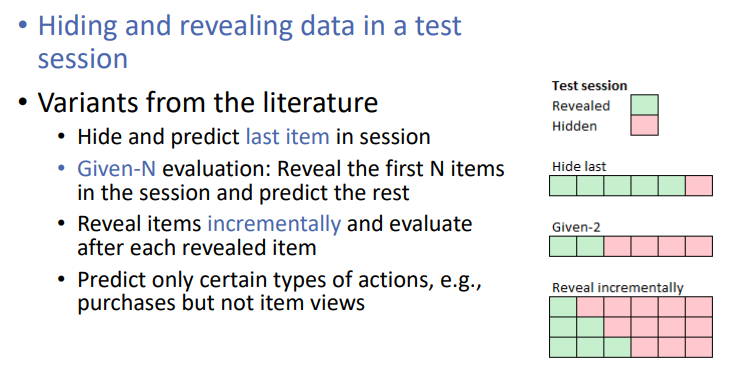

GIVEN_K=1, LOOK_AHEAD=1, STEP=1 corresponds to the classical next-item evaluation

In [ ]:
#collapse
def eval_seqreveal(recommender, user_flg=0):
  GIVEN_K = 1
  LOOK_AHEAD = 1
  STEP=1

  if user_flg:
    test_sequences, test_users = get_test_sequences_and_users(test_data, GIVEN_K, train_data['user_id'].values) # we need user ids now!
    print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
    results = sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           users=test_users,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=True,  # scrolling averages metrics over all profile lengths
                                           step=STEP)
  else:
    test_sequences = get_test_sequences(test_data, GIVEN_K)
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    results = sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=True,  # scrolling averages metrics over all profile lengths
                                           step=STEP)


  
  # print('Sequential evaluation (GIVEN_K={}, LOOK_AHEAD={}, STEP={})'.format(GIVEN_K, LOOK_AHEAD, STEP))
  # for mname, mvalue in zip(METRICS.keys(), results):
  #     print('\t{}@{}: {:.4f}'.format(mname, TOPN, mvalue))
  return [results, GIVEN_K, LOOK_AHEAD, STEP]

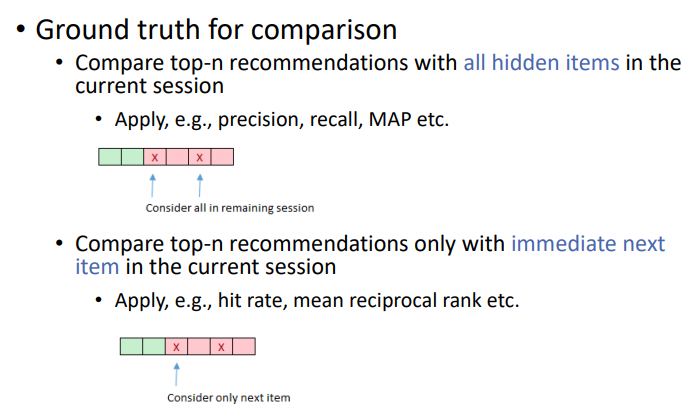

#### Logging

In [ ]:
#hide-output
for model in [poprecommender, fsmrecommender,  mmcrecommender, p2vrecommender,
              rnnrecommender, fpmcrecommender, prnnrecommender,
              ]:
  if model in [fpmcrecommender, prnnrecommender]:
    results = eval_seqreveal(model, user_flg=1)
    # results = eval_staticprofile(model, user_flg=1)
  else:
    results = eval_seqreveal(model)

  wandb.init(name='seqreveal-'+type(model).__name__, 
           project='SARS Music30 x1',
           notes='sequentially revelaed user profile evaluation', 
           tags=['sequence', 'music', 'seqreveal'])
  wandb.log({
      "Model": type(model).__name__,
      "GIVEN_K": results[1],
      "LOOK_AHEAD": results[2],
      "STEP": results[3],
      "Precision@100": results[0][0],
      "Recall@100": results[0][1],
      "MRR@100": results[0][2],
      })

  6%|▌         | 166/2891 [00:00<00:01, 1655.62it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:01<00:00, 1561.24it/s]


Model,Prod2VecRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.01922
Recall@100,0.28801
MRR@100,0.10133
_runtime,144
_timestamp,1619363510
_step,3


GIVEN_K,▁▁▁▁
LOOK_AHEAD,▁▁▁▁
STEP,▁▁▁▁
Precision@100,▁█▆▄
Recall@100,▂▁█▅
MRR@100,▁▅█▆
_runtime,▁▅▅█
_timestamp,▁▅▅█
_step,▁▃▆█


  1%|          | 19/2891 [00:00<00:15, 189.65it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:17<00:00, 163.97it/s]


Model,PopularityRecommende...
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.00176
Recall@100,0.17585
MRR@100,0.01509
_runtime,3
_timestamp,1619364913
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  3%|▎         | 99/2891 [00:00<00:02, 986.59it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:02<00:00, 1312.88it/s]


Model,FSMRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.04325
Recall@100,0.11793
MRR@100,0.0898
_runtime,2
_timestamp,1619364936
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  1%|          | 15/2891 [00:00<00:21, 136.79it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:17<00:00, 164.35it/s]


Model,MixedMarkovChainReco...
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.03049
Recall@100,0.40207
MRR@100,0.13409
_runtime,3
_timestamp,1619364945
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 0/2891 [00:00<?, ?it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [02:02<00:00, 23.66it/s]


Model,Prod2VecRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.01922
Recall@100,0.28801
MRR@100,0.10133
_runtime,3
_timestamp,1619364968
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 0/1079 [00:00<?, ?it/s]

1079 sequences available for evaluation (1079 users)


100%|██████████| 1079/1079 [00:59<00:00, 18.14it/s]


Model,RNNRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.00488
Recall@100,0.48776
MRR@100,0.24084
_runtime,3
_timestamp,1619365096
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 0/1079 [00:00<?, ?it/s]

1079 sequences available for evaluation (1079 users)


100%|██████████| 1079/1079 [00:47<00:00, 22.64it/s]


Model,FPMCRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.00184
Recall@100,0.18351
MRR@100,0.04037
_runtime,3
_timestamp,1619365161
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


### Evaluation with "static" user-profiles

Here we evaluate the quality of the recommendations in a setting in which user profiles are instead _static_.

The _user profile_ starts from the first `GIVEN_K` events (or, alternatively, from the last `-GIVEN_K` events if `GIVEN_K<0`).  
The recommendations are evaluated against the next `LOOK_AHEAD` events (the _ground truth_).  

The user profile is *not extended* and the ground truth *doesn't move forward*.
This allows to obtain "snapshots" of the recommendation performance for different user profile and ground truth lenghts.

Also here you can set the `LOOK_AHEAD='all'` to see what happens if you had to recommend a **whole sequence** instead of a set of a set of alternatives to a user.

In [ ]:
#collapse
def eval_staticprofile(recommender, user_flg=0):
  GIVEN_K = 1
  LOOK_AHEAD = 'all'
  STEP=1

  if user_flg:
    test_sequences, test_users = get_test_sequences_and_users(test_data, GIVEN_K, train_data['user_id'].values) # we need user ids now!
    print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
    results = sequential_evaluation(recommender,
                                           test_sequences=test_sequences,
                                           users=test_users,
                                           given_k=GIVEN_K,
                                           look_ahead=LOOK_AHEAD,
                                           evaluation_functions=METRICS.values(),
                                           top_n=TOPN,
                                           scroll=False  # notice that scrolling is disabled!
                                    )                                
  else:
    test_sequences = get_test_sequences(test_data, GIVEN_K)
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    results = sequential_evaluation(recommender,
                                            test_sequences=test_sequences,
                                            given_k=GIVEN_K,
                                            look_ahead=LOOK_AHEAD,
                                            evaluation_functions=METRICS.values(),
                                            top_n=TOPN,
                                            scroll=False  # notice that scrolling is disabled!
                                    )
    
  return [results, GIVEN_K, LOOK_AHEAD, STEP]

#### Logging

In [ ]:
#hide-output
for model in [poprecommender, fsmrecommender,  mmcrecommender, p2vrecommender,
              rnnrecommender, fpmcrecommender, prnnrecommender,
              ]:
  if model in [fpmcrecommender, prnnrecommender]:
    results = eval_staticprofile(model, user_flg=1)
  else:
    results = eval_staticprofile(model)


  wandb.init(name='staticprofile-'+type(model).__name__, 
           project='SARS Music30 x1',
           notes='sequentially static user profile evaluation', 
           tags=['sequence', 'music', 'staticprofile'])
  wandb.log({
      "Model": type(model).__name__,
      "GIVEN_K": results[1],
      "LOOK_AHEAD": results[2],
      "STEP": results[3],
      "Precision@100": results[0][0],
      "Recall@100": results[0][1],
      "MRR@100": results[0][2],
      })

 16%|█▌        | 450/2891 [00:00<00:00, 4497.97it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:00<00:00, 4674.04it/s]


Model,RNNRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
Precision@100,0.00445
Recall@100,0.44485
MRR@100,0.05859
_runtime,3
_timestamp,1619365214
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  8%|▊         | 242/2891 [00:00<00:01, 2415.10it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:01<00:00, 2526.75it/s]


Model,PopularityRecommende...
GIVEN_K,1
LOOK_AHEAD,all
STEP,1
Precision@100,0.00837
Recall@100,0.175
MRR@100,0.05131
_runtime,2
_timestamp,1619365485
_step,0


GIVEN_K,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


 16%|█▋        | 471/2891 [00:00<00:00, 4702.07it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:00<00:00, 5916.58it/s]


Model,FSMRecommender
GIVEN_K,1
LOOK_AHEAD,all
STEP,1
Precision@100,0.10803
Recall@100,0.09833
MRR@100,0.13287
_runtime,2
_timestamp,1619365491
_step,0


GIVEN_K,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  9%|▉         | 265/2891 [00:00<00:00, 2643.59it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:00<00:00, 3322.28it/s]


Model,MixedMarkovChainReco...
GIVEN_K,1
LOOK_AHEAD,all
STEP,1
Precision@100,0.09713
Recall@100,0.39545
MRR@100,0.23382
_runtime,2
_timestamp,1619365497
_step,0


GIVEN_K,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  1%|          | 19/2891 [00:00<00:15, 181.37it/s]

2891 sequences available for evaluation


100%|██████████| 2891/2891 [00:12<00:00, 232.78it/s]


Model,Prod2VecRecommender
GIVEN_K,1
LOOK_AHEAD,all
STEP,1
Precision@100,0.10218
Recall@100,0.19719
MRR@100,0.20517
_runtime,2
_timestamp,1619365503
_step,0


GIVEN_K,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  1%|          | 7/1079 [00:00<00:17, 62.97it/s]

1079 sequences available for evaluation (1079 users)


100%|██████████| 1079/1079 [00:13<00:00, 81.83it/s]


Model,RNNRecommender
GIVEN_K,1
LOOK_AHEAD,all
STEP,1
Precision@100,0.01542
Recall@100,0.38361
MRR@100,0.29362
_runtime,3
_timestamp,1619365522
_step,0


GIVEN_K,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


  2%|▏         | 20/1079 [00:00<00:05, 199.38it/s]

1079 sequences available for evaluation (1079 users)


100%|██████████| 1079/1079 [00:04<00:00, 221.29it/s]


Model,FPMCRecommender
GIVEN_K,1
LOOK_AHEAD,all
STEP,1
Precision@100,0.00651
Recall@100,0.17196
MRR@100,0.08583
_runtime,3
_timestamp,1619365541
_step,0


GIVEN_K,▁
STEP,▁
Precision@100,▁
Recall@100,▁
MRR@100,▁
_runtime,▁
_timestamp,▁
_step,▁


## Analysis of next-item recommendation

Here we propose to analyse the performance of the recommender system in the scenario of *next-item recommendation* over the following dimensions:

* the *length* of the **recommendation list**, and
* the *length* of the **user profile**.

NOTE: This evaluation is by no means exhaustive, as different the hyper-parameters of the recommendation algorithm should be *carefully tuned* before drawing any conclusions. Unfortunately, given the time constraints for this tutorial, we had to leave hyper-parameter tuning out. A very useful reference about careful evaluation of (session-based) recommenders can be found at:

*  Evaluation of Session-based Recommendation Algorithms, Ludewig and Jannach, 2018 ([paper](https://arxiv.org/abs/1803.09587))

### Evaluation for different recommendation list lengths

In [ ]:
#hide
def eval_reclength(recommender, user_flg=0):
  GIVEN_K = 1
  LOOK_AHEAD = 1
  STEP = 1
  topn_list = [1, 5, 10, 20, 50, 100]

  res_list = []

  if user_flg:
    test_sequences, test_users = get_test_sequences_and_users(test_data, GIVEN_K, train_data['user_id'].values) # we need user ids now!
    print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
    for topn in topn_list:
      print('Evaluating recommendation lists with length: {}'.format(topn)) 
      res_tmp = sequential_evaluation(recommender,
                                            test_sequences=test_sequences,
                                            users=test_users,
                                            given_k=GIVEN_K,
                                            look_ahead=LOOK_AHEAD,
                                            evaluation_functions=METRICS.values(),
                                            top_n=topn,
                                            scroll=True,  # here we average over all profile lengths
                                            step=STEP
                                      )
      mvalues = list(zip(METRICS.keys(), res_tmp))
      res_list.append((topn, mvalues))                            
  else:
    test_sequences = get_test_sequences(test_data, GIVEN_K)
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    for topn in topn_list:
      print('Evaluating recommendation lists with length: {}'.format(topn))      
      res_tmp = sequential_evaluation(recommender,
                                                test_sequences=test_sequences,
                                                given_k=GIVEN_K,
                                                look_ahead=LOOK_AHEAD,
                                                evaluation_functions=METRICS.values(),
                                                top_n=topn,
                                                scroll=True,  # here we average over all profile lengths
                                                step=STEP)
      mvalues = list(zip(METRICS.keys(), res_tmp))
      res_list.append((topn, mvalues))

  # show separate plots per metric
  # fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
  res_list_t = list(zip(*res_list))
  results = []
  for midx, metric in enumerate(METRICS):
      mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
      fig, ax = plt.subplots(figsize=(5,5))
      ax.plot(topn_list, mvalues)
      ax.set_title(metric)
      ax.set_xticks(topn_list)
      ax.set_xlabel('List length')
      fig.tight_layout()
      results.append(fig)
  return [results, GIVEN_K, LOOK_AHEAD, STEP]

#### Logging

In [ ]:
#hide-output
for model in [poprecommender, fsmrecommender,  mmcrecommender, p2vrecommender,
              rnnrecommender, fpmcrecommender, prnnrecommender,
              ]:
  if model in [fpmcrecommender, prnnrecommender]:
    results = eval_reclength(model, user_flg=1)
  else:
    results = eval_reclength(model)
    
  wandb.init(name='plotreclen-'+type(model).__name__, 
           project='SARS Music30 x1',
           notes='rec list length variation evaluation', 
           tags=['sequence', 'music', 'plotreclen'])
  wandb.log({"Precision": results[0][0],
             "Recall": results[0][1],
             "MRR": results[0][2],
             "Model": type(model).__name__,
             "GIVEN_K": results[1],
             "LOOK_AHEAD": results[2],
             "STEP": results[3],
             })

100%|██████████| 2891/2891 [00:00<00:00, 15128.57it/s]

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1
Evaluating recommendation lists with length: 5



 33%|███▎      | 951/2891 [00:00<00:00, 9483.19it/s]

Evaluating recommendation lists with length: 10


 23%|██▎       | 669/2891 [00:00<00:00, 6688.83it/s]

Evaluating recommendation lists with length: 20


 12%|█▏        | 337/2891 [00:00<00:00, 3323.39it/s]

Evaluating recommendation lists with length: 50


  6%|▌         | 177/2891 [00:00<00:01, 1766.30it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [00:01<00:00, 1714.44it/s]


Model,PopularityRecommende...
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619368731
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  1%|          | 16/2891 [00:00<00:18, 155.20it/s]

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1


  1%|          | 25/2891 [00:00<00:14, 191.72it/s]

Evaluating recommendation lists with length: 5


  1%|          | 25/2891 [00:00<00:14, 201.35it/s]

Evaluating recommendation lists with length: 10


  1%|          | 25/2891 [00:00<00:14, 195.01it/s]

Evaluating recommendation lists with length: 20


  1%|          | 25/2891 [00:00<00:14, 194.88it/s]

Evaluating recommendation lists with length: 50


  1%|          | 25/2891 [00:00<00:13, 206.00it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [00:16<00:00, 175.23it/s]


Model,PopularityRecommende...
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619368831
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  3%|▎         | 99/2891 [00:00<00:02, 986.29it/s]

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1


  6%|▌         | 160/2891 [00:00<00:01, 1598.42it/s]

Evaluating recommendation lists with length: 5


  6%|▋         | 182/2891 [00:00<00:01, 1792.34it/s]

Evaluating recommendation lists with length: 10


  5%|▌         | 148/2891 [00:00<00:01, 1476.30it/s]

Evaluating recommendation lists with length: 20


  5%|▌         | 148/2891 [00:00<00:01, 1463.26it/s]

Evaluating recommendation lists with length: 50


  4%|▍         | 130/2891 [00:00<00:02, 1296.16it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [00:01<00:00, 1471.60it/s]


Model,FSMRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619368937
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  1%|          | 24/2891 [00:00<00:12, 237.99it/s]

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1


  1%|          | 25/2891 [00:00<00:11, 245.30it/s]

Evaluating recommendation lists with length: 5


  1%|          | 27/2891 [00:00<00:11, 259.46it/s]

Evaluating recommendation lists with length: 10


  1%|          | 25/2891 [00:00<00:11, 239.56it/s]

Evaluating recommendation lists with length: 20


  1%|          | 25/2891 [00:00<00:12, 233.18it/s]

Evaluating recommendation lists with length: 50


  1%|          | 25/2891 [00:00<00:12, 228.19it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [00:15<00:00, 181.99it/s]


Model,MixedMarkovChainReco...
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619368954
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 3/2891 [00:00<01:49, 26.47it/s]

2891 sequences available for evaluation
Evaluating recommendation lists with length: 1


  0%|          | 7/2891 [00:00<00:44, 65.33it/s]

Evaluating recommendation lists with length: 5


  0%|          | 7/2891 [00:00<00:44, 65.47it/s]

Evaluating recommendation lists with length: 10


  0%|          | 9/2891 [00:00<00:32, 89.50it/s]

Evaluating recommendation lists with length: 20


  0%|          | 7/2891 [00:00<00:42, 68.27it/s]

Evaluating recommendation lists with length: 50


  0%|          | 8/2891 [00:00<00:36, 79.41it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 2891/2891 [02:00<00:00, 24.05it/s]


Model,Prod2VecRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619369052
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 5/1079 [00:00<00:40, 26.63it/s]

1079 sequences available for evaluation (1079 users)
Evaluating recommendation lists with length: 1


  0%|          | 5/1079 [00:00<00:35, 30.02it/s]

Evaluating recommendation lists with length: 5


  0%|          | 5/1079 [00:00<00:36, 29.20it/s]

Evaluating recommendation lists with length: 10


  0%|          | 5/1079 [00:00<00:34, 31.20it/s]

Evaluating recommendation lists with length: 20


  0%|          | 5/1079 [00:00<00:37, 28.42it/s]

Evaluating recommendation lists with length: 50


  0%|          | 5/1079 [00:00<00:37, 28.75it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 1079/1079 [00:59<00:00, 18.12it/s]


Model,RNNRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,4
_timestamp,1619369765
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 5/1079 [00:00<00:28, 37.53it/s]

1079 sequences available for evaluation (1079 users)
Evaluating recommendation lists with length: 1


  0%|          | 0/1079 [00:00<?, ?it/s]

Evaluating recommendation lists with length: 5


  0%|          | 5/1079 [00:00<00:22, 48.64it/s]

Evaluating recommendation lists with length: 10


  0%|          | 5/1079 [00:00<00:21, 49.92it/s]

Evaluating recommendation lists with length: 20


  0%|          | 0/1079 [00:00<?, ?it/s]

Evaluating recommendation lists with length: 50


  0%|          | 5/1079 [00:00<00:21, 49.89it/s]

Evaluating recommendation lists with length: 100


100%|██████████| 1079/1079 [00:44<00:00, 24.04it/s]


Model,FPMCRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619370121
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


### Evaluation for different user profile lengths

In [ ]:
#collapse
def eval_profilelength(recommender, user_flg=0):
  given_k_list = [1, 2, 3, 4]
  LOOK_AHEAD = 1
  STEP = 1
  TOPN = 20

  res_list = []

  if user_flg:
    test_sequences, test_users = get_test_sequences_and_users(test_data, max(given_k_list), train_data['user_id'].values) # we need user ids now!
    print('{} sequences available for evaluation ({} users)'.format(len(test_sequences), len(np.unique(test_users))))
    for gk in given_k_list:
      print('Evaluating profiles having length: {}'.format(gk))
      res_tmp = sequential_evaluation(recommender,
                                                test_sequences=test_sequences,
                                                users=test_users,
                                                given_k=gk,
                                                look_ahead=LOOK_AHEAD,
                                                evaluation_functions=METRICS.values(),
                                                top_n=TOPN,
                                                scroll=False,  # here we stop at each profile length
                                                step=STEP)
      mvalues = list(zip(METRICS.keys(), res_tmp))
      res_list.append((gk, mvalues))                          
  else:
    test_sequences = get_test_sequences(test_data, max(given_k_list))
    print('{} sequences available for evaluation'.format(len(test_sequences)))
    for gk in given_k_list:
      print('Evaluating profiles having length: {}'.format(gk))
      res_tmp = sequential_evaluation(recommender,
                                                test_sequences=test_sequences,
                                                given_k=gk,
                                                look_ahead=LOOK_AHEAD,
                                                evaluation_functions=METRICS.values(),
                                                top_n=TOPN,
                                                scroll=False,  # here we stop at each profile length
                                                step=STEP)
      mvalues = list(zip(METRICS.keys(), res_tmp))
      res_list.append((gk, mvalues))

  # show separate plots per metric
  # fig, axes = plt.subplots(nrows=1, ncols=len(METRICS), figsize=(15,5))
  res_list_t = list(zip(*res_list))
  results = []
  for midx, metric in enumerate(METRICS):
      mvalues = [res_list_t[1][j][midx][1] for j in range(len(res_list_t[1]))]
      fig, ax = plt.subplots(figsize=(5,5))
      ax.plot(given_k_list, mvalues)
      ax.set_title(metric)
      ax.set_xticks(given_k_list)
      ax.set_xlabel('Profile length')
      fig.tight_layout()
      results.append(fig)
  return [results, TOPN, LOOK_AHEAD, STEP]

#### Logging

In [ ]:
#hide-output
for model in [poprecommender, fsmrecommender,  mmcrecommender, p2vrecommender,
              rnnrecommender, fpmcrecommender, prnnrecommender,
              ]:
  if model in [fpmcrecommender, prnnrecommender]:
    results = eval_profilelength(model, user_flg=1)
  else:
    results = eval_profilelength(model)
    
  wandb.init(name='plotproflen-'+type(model).__name__, 
           project='SARS Music30 x1',
           notes='profile length variation evaluation', 
           tags=['sequence', 'music', 'plotproflen'])
  wandb.log({"Precision": results[0][0],
             "Recall": results[0][1],
             "MRR": results[0][2],
             "Model": type(model).__name__,
             "TOP_N": results[1],
             "LOOK_AHEAD": results[2],
             "STEP": results[3],
             })

  0%|          | 0/1164 [00:00<?, ?it/s]

1164 sequences available for evaluation
Evaluating profiles having length: 1
Evaluating profiles having length: 2
Evaluating profiles having length: 3
Evaluating profiles having length: 4


100%|██████████| 1164/1164 [00:00<00:00, 22574.00it/s]


Model,RNNRecommender
GIVEN_K,1
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619370395
_step,0


GIVEN_K,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


 14%|█▍        | 162/1164 [00:00<00:00, 1619.48it/s]

1164 sequences available for evaluation
Evaluating profiles having length: 1


 14%|█▎        | 158/1164 [00:00<00:00, 1565.03it/s]

Evaluating profiles having length: 2


  9%|▉         | 104/1164 [00:00<00:01, 1039.84it/s]

Evaluating profiles having length: 3


  6%|▌         | 70/1164 [00:00<00:01, 686.40it/s]

Evaluating profiles having length: 4


100%|██████████| 1164/1164 [00:01<00:00, 738.39it/s]


Model,PopularityRecommende...
TOP_N,20
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619371526
_step,0


TOP_N,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


 32%|███▏      | 375/1164 [00:00<00:00, 3722.11it/s]

1164 sequences available for evaluation
Evaluating profiles having length: 1


  0%|          | 0/1164 [00:00<?, ?it/s]

Evaluating profiles having length: 2
Evaluating profiles having length: 3


100%|██████████| 1164/1164 [00:00<00:00, 6726.65it/s]


Evaluating profiles having length: 4


Model,FSMRecommender
TOP_N,20
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619371537
_step,0


TOP_N,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


 23%|██▎       | 268/1164 [00:00<00:00, 2676.49it/s]

1164 sequences available for evaluation
Evaluating profiles having length: 1


 18%|█▊        | 213/1164 [00:00<00:00, 2123.98it/s]

Evaluating profiles having length: 2


 12%|█▏        | 138/1164 [00:00<00:00, 1373.66it/s]

Evaluating profiles having length: 3


 10%|█         | 118/1164 [00:00<00:00, 1179.31it/s]

Evaluating profiles having length: 4


100%|██████████| 1164/1164 [00:01<00:00, 1048.89it/s]


Model,MixedMarkovChainReco...
TOP_N,20
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619371545
_step,0


TOP_N,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  1%|          | 11/1164 [00:00<00:10, 107.21it/s]

1164 sequences available for evaluation
Evaluating profiles having length: 1


  1%|▏         | 17/1164 [00:00<00:06, 166.10it/s]

Evaluating profiles having length: 2


  1%|▏         | 15/1164 [00:00<00:08, 143.04it/s]

Evaluating profiles having length: 3


  1%|          | 11/1164 [00:00<00:10, 107.33it/s]

Evaluating profiles having length: 4


100%|██████████| 1164/1164 [00:09<00:00, 122.52it/s]


Model,Prod2VecRecommender
TOP_N,20
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619371555
_step,0


TOP_N,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  2%|▏         | 7/463 [00:00<00:07, 63.98it/s]

463 sequences available for evaluation (463 users)
Evaluating profiles having length: 1


  2%|▏         | 9/463 [00:00<00:05, 86.68it/s]

Evaluating profiles having length: 2


  2%|▏         | 10/463 [00:00<00:04, 90.95it/s]

Evaluating profiles having length: 3


  2%|▏         | 9/463 [00:00<00:05, 86.91it/s]

Evaluating profiles having length: 4


100%|██████████| 463/463 [00:05<00:00, 83.94it/s]


Model,RNNRecommender
TOP_N,20
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619371594
_step,0


TOP_N,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


  4%|▎         | 17/463 [00:00<00:02, 162.60it/s]

463 sequences available for evaluation (463 users)
Evaluating profiles having length: 1


  4%|▍         | 19/463 [00:00<00:02, 186.26it/s]

Evaluating profiles having length: 2


  3%|▎         | 16/463 [00:00<00:02, 157.61it/s]

Evaluating profiles having length: 3


  3%|▎         | 15/463 [00:00<00:03, 148.40it/s]

Evaluating profiles having length: 4


100%|██████████| 463/463 [00:03<00:00, 140.47it/s]


Model,FPMCRecommender
TOP_N,20
LOOK_AHEAD,1
STEP,1
_runtime,3
_timestamp,1619371623
_step,0


TOP_N,▁
LOOK_AHEAD,▁
STEP,▁
_runtime,▁
_timestamp,▁
_step,▁


## Artifact versioning

### Model logging

In [ ]:
#collapse
import pickle
run = wandb.init(job_type="model-logging",
                 name="artifact-model",
                 project='SARS Music30 x1')

for model in [poprecommender, fsmrecommender,  mmcrecommender, p2vrecommender,
              rnnrecommender, fpmcrecommender, prnnrecommender, knnrecommender]:
  # with open(type(model).__name__+'.p', 'wb') as handle:
    # pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
  artifact = wandb.Artifact(type(model).__name__, type='model')
  artifact.add_file(type(model).__name__+'.p')
  run.log_artifact(artifact)

### Data logging

In [ ]:
#collapse
run = wandb.init(job_type="data-logging",
                 name="artifact-data",
                 project='SARS Music30 x1')
artifact = wandb.Artifact('datasets', type='dataset')

train_data.name = 'train_dataset'
test_data.name = 'test_dataset'

for dataset in [train_data, test_data]:
  dataset.to_csv(dataset.name+'.p', index=False)
  artifact.add_file(dataset.name+'.p')

run.log_artifact(artifact)

## W&B Experiment Link
https://wandb.ai/sparsh121/SARS%20Music30%20x1/overview?workspace=user-sparsh121

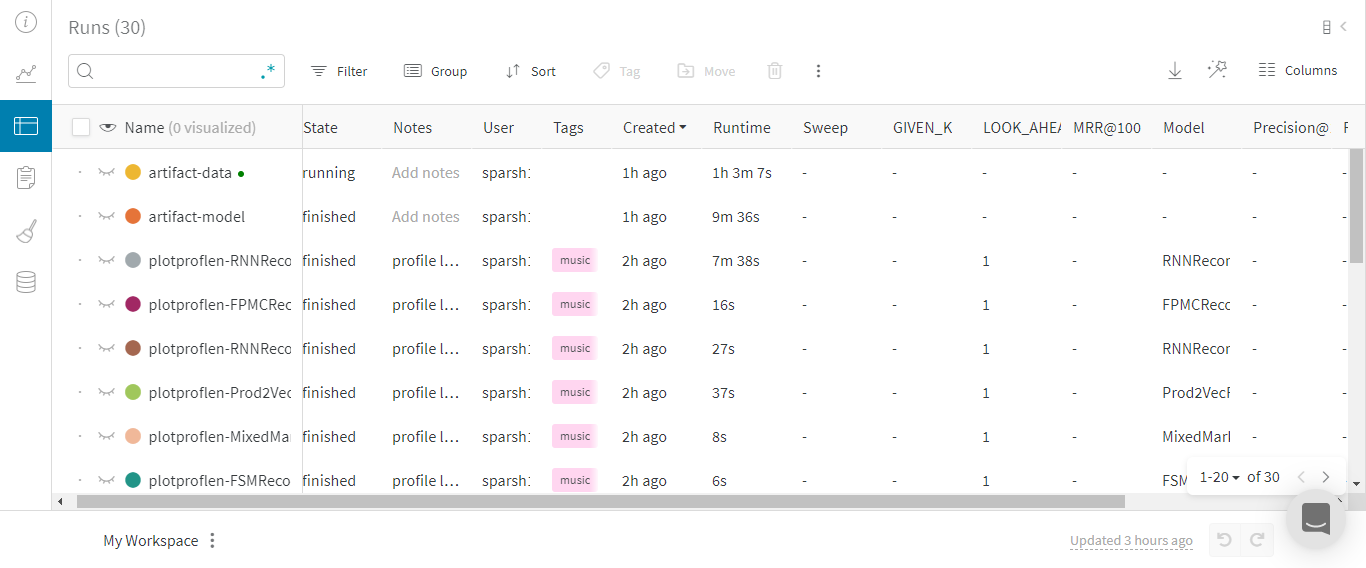

[Credits](https://github.com/mquad/sars_tutorial/)